#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.83646286,  0.1123198 , -0.53638992],
       [ 0.45171557,  0.69549635, -0.55878248],
       [ 0.31029489, -0.70969647, -0.63249347]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001400


In [29]:
Ret

array([[[-0.83646286,  0.1123198 , -0.53638992],
        [ 0.45171557,  0.69549635, -0.55878248],
        [ 0.31029489, -0.70969647, -0.63249347]],

       [[-0.01331857,  0.02331437, -0.99963946],
        [ 0.04217879,  0.9988514 ,  0.02273403],
        [ 0.9990213 , -0.0418608 , -0.01428665]],

       [[ 0.93425032,  0.09147806, -0.34468552],
        [-0.35602834,  0.29480897, -0.88675334],
        [ 0.02049791,  0.95116741,  0.30799416]],

       [[ 0.19451853,  0.08559683,  0.97715696],
        [-0.90376016,  0.40286898,  0.14461729],
        [-0.38128745, -0.91124627,  0.15572449]]])

In [30]:
Ret.shape

(4, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([0.50114753, 0.41465587, 1.75600733, 4.87039407])

In [34]:
C1(dx,dy,dz,Ret)

array([[-0.40143656,  4.1751562 ,  1.35453852,  0.95301475],
       [ 0.11441047, -1.96069356, -1.45855745, -4.40180706],
       [ 0.36636041,  0.55350439, -1.40299681, -1.8538171 ]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000287


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[ -2303.85806965,  23961.36310059,   7773.74253794,
          5469.38400751],
       [   656.60558952, -11252.4868597 ,  -8370.71070408,
        -25262.12011944],
       [  2102.55481255,   3176.58045545,  -8051.84632113,
        -10639.1192666 ]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[ -2303.85806965,    656.60558952,   2102.55481255],
       [ 23961.36310059, -11252.4868597 ,   3176.58045545],
       [  7773.74253794,  -8370.71070408,  -8051.84632113],
       [  5469.38400751, -25262.12011944, -10639.1192666 ]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000397


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000443


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000964


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000469


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.001850


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000246


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000977


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 249690.66403006],
       [     0.        ,      0.        , 112244.1403009 ]])

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[  2303.85806965, -23961.36310059,  -7773.74253794,
         -5469.38400751],
       [  -656.60558952,  11252.4868597 ,   8370.71070408,
         25262.12011944],
       [ -2230.71935478,  -3304.74499768,   7923.6817789 ,
         10510.95472437]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000797


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000580


In [91]:
Re_b(Ret).shape

(4, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[6.99670121e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.83715178e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 8.00095987e+01]],

       [[1.77384424e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.97704114e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.08216649e-02]],

       [[8.72823657e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.69123306e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.89720802e+01]],

       [[3.78374583e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.62303417e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.85002318e+00]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000115


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000529


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000896


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000791


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.44310449e+04,  9.35548644e+07,  1.64332947e+05],
       [ 9.69816119e+07,  6.56702870e+07, -8.47995546e+06],
       [-7.98150485e+06,  7.87811303e+07,  1.49039805e+07]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[  2303.85806965, -23961.36310059,  -7773.74253794,
         -5469.38400751],
       [  -656.60558952,  11252.4868597 ,   8370.71070408,
         25262.12011944],
       [ -2230.71935478,  -3304.74499768,   7923.6817789 ,
         10510.95472437]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[ 0.00000000e+00, -4.42249268e+02,  2.42333365e+06,
        -2.55116737e+06],
       [ 0.00000000e+00, -2.40885846e+05,  4.02401321e+04,
         2.14737512e+05],
       [ 0.00000000e+00,  8.07392271e+02,  7.75436973e+04,
        -8.88193862e+04]])

In [111]:
Re_b(Ret).shape

(4, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[  2303.85806965,   -656.60558952,  -2230.71935478],
       [-23961.36310059,  11252.4868597 ,  -3304.74499768],
       [ -7773.74253794,   8370.71070408,   7923.6817789 ],
       [ -5469.38400751,  25262.12011944,  10510.95472437]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([140.10783134, 129.09412109,  -9.48115328,  41.70677954]),
 array([-185.07150126,   -4.62519473,   73.76768429,   32.96201264]),
 array([-0.70791775,  0.64393778, -1.32514427,  2.20689693]),
 numpy.ndarray,
 array([-0.1641674 , -1.96465172,  0.30360825,  0.07431527]))

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[  1499.5519116 ,   1173.90308454,    361.06214516],
       [-20076.33375878,  21406.2576785 , -27666.48152934],
       [-17001.80600623,   6579.79267335,  18166.73117365],
       [  5899.92943563,  41902.52187376,  -8786.8375031 ]])

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[  2303.85806965,   -656.60558952,  -2230.71935478],
       [-23961.36310059,  11252.4868597 ,  -3304.74499768],
       [ -7773.74253794,   8370.71070408,   7923.6817789 ],
       [ -5469.38400751,  25262.12011944,  10510.95472437]])

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

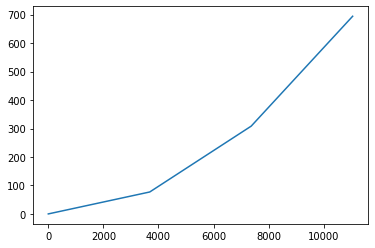

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
# #     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
# #         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)

    def eq_left(self,η, dη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)

        return -(np.matmul(self.D, dη) + np.dot(C,self.G))
        
    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(η,dη, ddη)

In [135]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
sampleTime = 1e-5                # sample time [seconds]
N = int(2e5)                         # number of samples

In [138]:
N

200000

In [139]:
# vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [140]:
# [simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [141]:
# vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [142]:
# [simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [143]:
# simData_1.shape

In [144]:
# simData=np.concatenate([simData_1,simData_2], axis=0)
# simData=simData_1

In [145]:
# simData.shape

In [146]:
# ans_t = simTime_1

In [147]:
# simData[250]

In [148]:
# simData.shape

In [149]:
# ans_t=[]
# sum_=0
# for i in range(simData.shape[0]):
#     ans_t.append(sum_)
#     sum_+=sampleTime

In [150]:
# plotVehicleStates(simTime_1, simData_1, 1)                    
# plotControls(simTime_1, simData_1, vehicle_1, 2)

In [151]:
# plotVehicleStates(simTime_2, simData_2, 1)                    
# plotControls(simTime_2, simData_2, vehicle_2, 2)

In [152]:
# numDataPoints = 5                 # number of 3D data points
# FPS = 10                            # frames per second (animated GIF)
# filename = '3D_animation.gif'       # data file for animated GIF
# browser = 'safari'                  # browser for visualization of animated GIF

In [153]:
# plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [154]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

In [155]:
# simData[1]

In [156]:
# simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [157]:
# diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [158]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [159]:
# diff=diff_1

In [160]:
V=VesselSemisub()

In [161]:
# thres =0.1

In [162]:
# def retrieve_name(var):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [163]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [164]:
# simD = simD_1

In [165]:
# SD0=simD[:, 0]
# SD1=simD[:, 1]
# SD2=simD[:, 2]
# SD3=simD[:, 3]
# SD4=simD[:, 4]
# SD5=simD[:, 5]
# SD6=simD[:, 6]
# SD7=simD[:, 7]
# SD8=simD[:, 8]
# SD9=simD[:, 9]
# SD10=simD[:, 10]
# SD11=simD[:, 11]
# Diff6=diff[:, 6]
# Diff7=diff[:, 7]
# Diff8=diff[:, 8]
# Diff9=diff[:, 9]
# Diff10=diff[:, 10]
# Diff11=diff[:, 11]

In [166]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [167]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [168]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [169]:
# q0

In [170]:
# Jv(x, y, z )

In [171]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [172]:
# co=Time()

In [173]:
# def asymptote(t):
#     return t/np.sqrt(t**2+1)

In [174]:
from scipy.integrate import solve_ivp

In [175]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
    print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
#     x_ve = SD0[idx]
#     y_ve = SD1[idx]
#     z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
#     u_ve = SD6[idx]
#     v_ve = SD7[idx]
#     w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
#     p_ve = ssa(SD9[idx])
#     q_ve = ssa(SD10[idx])
#     r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
#     du_ve = Diff6[idx]/sampleTime
#     dv_ve = Diff7[idx]/sampleTime
#     dw_ve = Diff8[idx]/sampleTime
#     dp_ve = Diff9[idx]/sampleTime
#     dq_ve = Diff10[idx]/sampleTime
#     dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
#     η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
#     tau_force = V.tau(η,dη, ddη)
#     co.time += 1
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
  
    
    
    
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
    ddη=np.linalg.lstsq(V.M, left, rcond=None)[0]
 
    tau_force = V.tau(η,dη,ddη)
    print(η,dη,ddη)
#     print(tau_force)
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        - Z0 
       )
#     print(Z1,Z2, - Z0,Z)
#     print()
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
#     ddx,ddy, ddz = 1/Ws*torch.linalg.lstsq(torch.from_numpy(Re_b(Ret).astype(np.float64)),torch.from_numpy(Z.astype(np.float64))).solution.cpu().numpy().T
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    
#     print(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [176]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [177]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [178]:
# q0.shape

In [179]:
# import numpy as np

In [180]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [181]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [182]:
# grayscott1d(4,q0)

In [183]:
# grayscott1d(4,q0).shape

In [184]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [185]:
import scipy

In [186]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [187]:
tspan = (0., 2)

In [188]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [ ]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, method='BDF'
#              ,rtol=1000, atol=1000
            )
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
8.486471866069971e-08
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [-8.461834619757206e-08, -3.3006278643840476e-16, 9.988589999613884e-07, -1.8614659587822853e-13, -6.462018375935786e-15, -5.932790452192317e-14] [-1.00762082e+01  5.06891182e+00  3.97277498e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [

[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
0.0
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, -1.4901161193847656e-14] [-1.00762082e+01  5.06891182e+00  3.97278206e-02 -3.90794979e-01
 -5.64781099e-01 -4.70760156e-04]
8.48647186606997e-06
[11052.68484446162, 0.0, 694.4218951076863, 0.0, 0.0, 0.0] [-8.461834619757205e-06, -3.300627864384047e-14, 9.988589999613885e-05, -1.861465958782285e-11, -6.462018375935785e-13, -5.932790452

[11052.684838160989, -4.295557393184615e-14, 694.4219694768594, -1.3764329363372318e-11, -6.576730625506596e-14, -4.402410932344006e-12] [-0.0042202779225599465, -3.0913004686663056e-11, 0.0498116553214043, -9.216918370435039e-09, -3.4514852824344005e-11, -2.9510160196759918e-09] [-1.00761857e+01  5.06891180e+00  3.61997529e-02 -3.90794978e-01
 -5.64781983e-01 -4.70760113e-04]
0.004232502266233315
[11052.684838160989, -4.295557393184615e-14, 694.4219694768594, -1.3765819479491701e-11, -6.576730625506596e-14, -4.402410932344006e-12] [-0.0042202779225599465, -3.0913004686663056e-11, 0.0498116553214043, -9.216918370435039e-09, -3.4514852824344005e-11, -2.9510160196759918e-09] [-1.00761857e+01  5.06891180e+00  3.61997529e-02 -3.90794978e-01
 -5.64781983e-01 -4.70760113e-04]
0.004232502266233315
[11052.684838160989, -4.295557393184615e-14, 694.4219694768594, -1.3764329363372318e-11, -6.576730625506596e-14, -4.402410932344006e-12] [-0.0042202779225599465, -3.0913004686663056e-11, 0.049811655

0.0024711231322589785
[11052.68484120015, -2.19941237364868e-14, 694.4219336045124, -7.1252896251357525e-12, -3.5086062204943344e-14, -2.2786581160028914e-12] [-0.002463980076795387, -1.751729655717732e-11, 0.029082747971617515, -5.381904815864115e-09, -2.254001584895408e-11, -1.7223647599342043e-09] [-1.00761951e+01  5.06891181e+00  3.76679432e-02 -3.90794978e-01
 -5.64781615e-01 -4.70760131e-04]
0.0024711231322589785
[11052.684840833226, -6.1418192064496865e-12, 694.4219379223556, -8.325643870207138e-12, 5.872920680709105e-13, -2.4026117344049953e-12] [-0.002466004848511152, -1.2363573065671439e-08, 0.02908078016540436, -6.191908867942931e-09, 1.238729906012574e-09, -1.4559091113872348e-09] [-1.00761950e+01  5.06891181e+00  3.76680826e-02 -3.90794978e-01
 -5.64781616e-01 -4.70760134e-04]
0.0021775599432632556
[11052.684841706676, -1.8500548703926908e-14, 694.421927625788, -6.0187830020963245e-12, -2.997252152992291e-14, -1.9246993132793726e-12] [-0.0021712637691679603, -1.52846785355

[11052.684838465859, 3.327440804702458e-13, 694.421965877595, -1.3123947008876875e-11, -2.5096352352703815e-14, -4.173150000092049e-12] [-0.00363466919566345, 1.2334743865138746e-09, 0.04289785918143986, -8.106053577474056e-09, 2.0394696902254088e-10, -2.449217162632551e-09] [-1.00761888e+01  5.06891181e+00  3.66894443e-02 -3.90794978e-01
 -5.64781861e-01 -4.70760119e-04]
0.0036453758882418704
[11052.684838465859, 3.327440804702458e-13, 694.421965877595, -1.3123947008876875e-11, -2.5096352352703815e-14, -4.173150000092049e-12] [-0.00363466919566345, 1.2334743865138746e-09, 0.04289785918143986, -8.106053577474056e-09, 2.0394696902254088e-10, -2.449217162632551e-09] [-1.00761888e+01  5.06891181e+00  3.66894443e-02 -3.90794978e-01
 -5.64781861e-01 -4.70760119e-04]
0.0036453758882418704
[11052.684838465859, 3.327440804702458e-13, 694.421965877595, -1.3123947008876875e-11, -2.5096352352703815e-14, -4.173150000092049e-12] [-0.00363466919566345, 1.2334743865138746e-09, 0.04289785918143986, -8

0.0036453758882418704
[11052.684837522082, 4.771280062048006e-13, 694.4219770119308, -1.5279434590767948e-11, 1.3545336546544443e-13, -4.743035522638814e-12] [-0.003634803010584769, 4.2008477626282845e-10, 0.042893784064688655, -8.104910960942615e-09, 2.5735856487173566e-10, -2.386794638321562e-09] [-1.00761888e+01  5.06891181e+00  3.66897330e-02 -3.90794978e-01
 -5.64781861e-01 -4.70760119e-04]
0.0036453758882418704
[11052.684836995122, 5.434441445245497e-13, 694.4219832261963, -1.6482802867771932e-11, 2.3874129098029e-13, -5.0384639668489055e-12] [-0.003634915632474744, 4.114606051178045e-10, 0.042891034389844186, -8.104319683787252e-09, 2.774424617452676e-10, -2.351644488245116e-09] [-1.00761888e+01  5.06891181e+00  3.66899277e-02 -3.90794978e-01
 -5.64781861e-01 -4.70760119e-04]
0.006335876461286664
[11052.68482306652, 1.6497278995822147e-12, 694.4221475583106, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692748138779734e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0

[11052.68482306652, 1.6497278995822147e-12, 694.4221475583106, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692748138779734e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0.07450567370501238, -1.422636741205967e-08, 2.8368440689855003e-10, -3.53774478725025e-09] [-1.00761744e+01  5.06891180e+00  3.44507212e-02 -3.90794977e-01
 -5.64782422e-01 -4.70760092e-04]
0.006335876461286664
[11052.68482306652, 1.6497278995822147e-12, 694.422157906007, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692748138779734e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0.07450567370501238, -1.422636741205967e-08, 2.8368440689855003e-10, -3.53774478725025e-09] [-1.00761744e+01  5.06891180e+00  3.44507212e-02 -3.90794977e-01
 -5.64782422e-01 -4.70760092e-04]
0.006335876461286664
[11052.68482306652, 1.6497278995822147e-12, 694.4221475583106, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692748138779734e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0.07450567370501238, -1.4

0.006335876461286664
[11052.68482306652, 1.6497278995822147e-12, 694.4221475583106, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692763039940928e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0.07450567370501238, -1.422636741205967e-08, 2.8368440689855003e-10, -3.53774478725025e-09] [-1.00761744e+01  5.06891180e+00  3.44507212e-02 -3.90794977e-01
 -5.64782422e-01 -4.70760092e-04]
0.006335876461286664
[11052.68482306652, 1.6497278995822147e-12, 694.4221475583106, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692748138779734e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0.07450567370501238, -1.422636741205967e-08, 2.8368440689855003e-10, -3.53774478725025e-09] [-1.00761744e+01  5.06891180e+00  3.44507212e-02 -3.90794977e-01
 -5.64782422e-01 -4.70760092e-04]
0.006335876461286664
[11052.68482306652, 1.6497278995822147e-12, 694.4221475583106, -4.7763439750993265e-11, 1.363317388594232e-12, -1.3692748138779734e-11] [-0.00631789293342795, -1.8086367358461463e-10, 0.0

0.03699802434239078
[11052.684146453903, 1.8058092128464042e-09, 694.429836212576, 1.4154960589321986e-08, -2.8152908760203068e-08, -3.969306714390389e-09] [-0.038565362050549196, 4.941503138108887e-07, 0.42175550933325145, 1.3447161127603006e-06, -4.094085358192954e-06, -4.7620290309766267e-07] [-1.00759825e+01  5.06891401e+00  9.85564492e-03 -3.90795158e-01
 -5.64788052e-01 -4.70759737e-04]
0.03699802434239078
[11052.684146453903, 1.8058092128464042e-09, 694.429836212576, 1.4154960589321986e-08, -2.8152908760203068e-08, -3.969306714390389e-09] [-0.038565362050549196, 4.941503287120499e-07, 0.42175550933325145, 1.3447161127603006e-06, -4.094085358192954e-06, -4.7620290309766267e-07] [-1.00759825e+01  5.06891401e+00  9.85564492e-03 -3.90795158e-01
 -5.64788052e-01 -4.70759737e-04]
0.03699802434239078
[11052.684146453903, 1.8058092128464042e-09, 694.429836212576, 1.4154960589321986e-08, -2.8152908760203068e-08, -3.969306714390389e-09] [-0.038565362050549196, 4.941503287120499e-07, 0.421

0.03699802434239078
[11052.684146453903, 1.8058092128464042e-09, 694.429836212576, 1.4154960589321986e-08, -2.8152908760203068e-08, -3.969306714390389e-09] [-0.038565362050549196, 4.941503287120499e-07, 0.42175550933325145, 1.3447161127603006e-06, -4.094085358192954e-06, -4.7620290309766267e-07] [-1.00759825e+01  5.06891401e+00  9.85564492e-03 -3.90795158e-01
 -5.64788052e-01 -4.70759737e-04]
0.03699802434239078
[11052.684146453903, 1.8058092128464042e-09, 694.429836212576, 1.4154960589321986e-08, -2.8152908760203068e-08, -3.969306714390389e-09] [-0.038565362050549196, 4.941503287120499e-07, 0.42175550933325145, 1.3447161127603006e-06, -4.094085358192954e-06, -4.7620290309766267e-07] [-1.00759825e+01  5.06891401e+00  9.85564492e-03 -3.90795158e-01
 -5.64788052e-01 -4.70759737e-04]
0.03699802434239078
[11052.684146453903, 1.8058092128464042e-09, 694.429836212576, 1.4154960589321986e-08, -2.8152908760203068e-08, -3.969306714390389e-09] [-0.038565362050549196, 4.941503287120499e-07, 0.421

0.03293484956594027
[11052.684293795073, 4.918978503761549e-10, 694.4282082133982, 9.237648607829389e-09, -1.630310105624677e-08, -2.488486247865936e-09] [-0.03381285345229592, 2.4064509934152663e-07, 0.3779037450118515, 8.760092327020675e-07, -2.3368942299566608e-06, -3.1470279956891764e-07] [-1.00760156e+01  5.06891325e+00  1.29615907e-02 -3.90795096e-01
 -5.64787508e-01 -4.70759833e-04]
0.03293484956594027
[11052.684293795073, 4.91882949214961e-10, 694.4282082133982, 9.237648607829389e-09, -1.630310105624677e-08, -2.488486247865936e-09] [-0.03381285345229592, 2.4064509934152663e-07, 0.3779037450118515, 8.760092327020675e-07, -2.3368942299566608e-06, -3.1470279956891764e-07] [-1.00760156e+01  5.06891325e+00  1.29615907e-02 -3.90795096e-01
 -5.64787508e-01 -4.70759833e-04]
0.03293484956594027
[11052.684293795073, 4.91882949214961e-10, 694.4282082133982, 9.237648607829389e-09, -1.630310105624677e-08, -2.488486247865936e-09] [-0.03381285345229592, 2.4064509934152663e-07, 0.3779037450118

0.03293484956594027
[11052.684293795073, 4.91882949214961e-10, 694.4282082133982, 9.237648607829389e-09, -1.630310105624677e-08, -2.488486247865936e-09] [-0.03381285345229592, 2.4064509934152663e-07, 0.3779037450118515, 8.760092327020675e-07, -2.3368942299566608e-06, -3.1470279956891764e-07] [-1.00760156e+01  5.06891325e+00  1.29615907e-02 -3.90795096e-01
 -5.64787508e-01 -4.70759833e-04]
0.03293484956594027
[11052.684293795073, 4.91882949214961e-10, 694.4282082133982, 9.237648607829389e-09, -1.630310105624677e-08, -2.488486247865936e-09] [-0.03381285345229592, 2.4064509934152663e-07, 0.3779037450118515, 8.760092327020675e-07, -2.336894229608436e-06, -3.1470279956891764e-07] [-1.00760156e+01  5.06891325e+00  1.29615907e-02 -3.90795096e-01
 -5.64787508e-01 -4.70759833e-04]
0.03293484956594027
[11052.684293795073, 4.91882949214961e-10, 694.4282082133982, 9.237648607829389e-09, -1.630310105624677e-08, -2.488486247865936e-09] [-0.03381285345229592, 2.4064509934152663e-07, 0.377903745011851

0.032427069388666754
[11052.684310821298, 4.170436746653073e-10, 694.4280177044199, 8.801408831882592e-09, -1.5163199965227136e-08, -2.332298634633619e-09] [-0.03328697150068497, 1.7331476672099927e-07, 0.3723611980579464, 8.417037425008075e-07, -2.2152918349747088e-06, -3.0147529887707685e-07] [-1.00760189e+01  5.06891319e+00  1.33541596e-02 -3.90795091e-01
 -5.64787426e-01 -4.70759829e-04]
0.032511699418212345
[11052.684308000578, 4.295822027412475e-10, 694.4280492563436, 8.875927092739182e-09, -1.5351194450584535e-08, -2.357898389144449e-09] [-0.033371825192532414, 1.3529765600561278e-07, 0.3732855257164103, 8.68354586396277e-07, -2.2224067992997975e-06, -3.0354761531848457e-07] [-1.00760185e+01  5.06891323e+00  1.32886912e-02 -3.90795095e-01
 -5.64787442e-01 -4.70759835e-04]
0.032511699418212345
[11052.684308000626, 4.2985917491981673e-10, 694.428049256479, 8.875046115271923e-09, -1.5351037424468117e-08, -2.357896354372077e-09] [-0.03337192466201876, 1.5811354637457658e-07, 0.37328

0.03332544238219771
[11052.684280511936, 5.115139856758583e-10, 694.4283566297668, 9.583769315681976e-09, -1.7185089675160923e-08, -2.6129305696621694e-09] [-0.03418849288917809, 2.5859293487142897e-07, 0.38215513317957833, 8.572615929947084e-07, -2.1384532067267088e-06, -3.16376462681646e-07] [-1.00760141e+01  5.06891322e+00  1.26604745e-02 -3.90795093e-01
 -5.64787614e-01 -4.70759941e-04]
0.03332544238219771
[11052.684280511936, 5.115139856758583e-10, 694.4283566297668, 9.583769315681976e-09, -1.7185089675160923e-08, -2.6129305696621694e-09] [-0.03418849288917809, 2.5859291997026776e-07, 0.38215513317957833, 8.572615929947084e-07, -2.1384532067267088e-06, -3.16376462681646e-07] [-1.00760141e+01  5.06891322e+00  1.26604745e-02 -3.90795093e-01
 -5.64787614e-01 -4.70759941e-04]
0.03332544238219771
[11052.684280511936, 5.115139856758583e-10, 694.4283566297668, 9.583769315681976e-09, -1.7185089675160923e-08, -2.6129305696621694e-09] [-0.03418849288917809, 2.5859293487142897e-07, 0.3821551

0.03332544238219771
[11052.684280511936, 5.115139856758583e-10, 694.4283566297668, 9.583769315681976e-09, -1.7185089675160923e-08, -2.6129305696621694e-09] [-0.03418849288917809, 2.5859293487142897e-07, 0.38215513317957833, 8.572615929947084e-07, -2.1384532067267088e-06, -3.16376462681646e-07] [-1.00760141e+01  5.06891322e+00  1.26604745e-02 -3.90795093e-01
 -5.64787614e-01 -4.70759941e-04]
0.03332544238219771
[11052.684280511936, 5.115139856758583e-10, 694.4283566297668, 9.583769315681976e-09, -1.7185089675160923e-08, -2.6129305696621694e-09] [-0.03418849288917809, 2.5859293487142897e-07, 0.38215513317957833, 8.572615929947084e-07, -2.1384532067267088e-06, -3.16376462681646e-07] [-1.00760141e+01  5.06891322e+00  1.26604745e-02 -3.90795093e-01
 -5.64787614e-01 -4.70759941e-04]
0.03332544238219771
[11052.684280511936, 5.115139856758583e-10, 694.4283566297668, 9.583769315681976e-09, -1.7185089675160923e-08, -2.6129305711522856e-09] [-0.03418849288917809, 2.5859293487142897e-07, 0.3821551

0.03478366825107725
[11052.684229587192, 6.30812862948687e-10, 694.4289254438061, 1.084831806570203e-08, -1.9810601212134167e-08, -3.0727138675277345e-09] [-0.035656746807123885, 1.1896703020909647e-07, 0.3979655021990666, 8.623001562796906e-07, -1.2545468379382518e-06, -3.043306214039755e-07] [-1.00760080e+01  5.06891323e+00  1.15406638e-02 -3.90795094e-01
 -5.64788031e-01 -4.70760571e-04]
0.03478366825107725
[11052.684229587192, 6.30812862948687e-10, 694.4289254438061, 1.084831806570203e-08, -1.9810601212134167e-08, -3.0727138675277345e-09] [-0.035656746807123885, 1.1896703020909647e-07, 0.3979655021990666, 8.623001562796906e-07, -1.2545468379382518e-06, -3.043306214039755e-07] [-1.00760080e+01  5.06891323e+00  1.15406638e-02 -3.90795094e-01
 -5.64788031e-01 -4.70760571e-04]
0.03478366825107725
[11052.684229587192, 6.30812862948687e-10, 694.4289254438061, 1.0848318065924076e-08, -1.9810601212134167e-08, -3.0727138675277345e-09] [-0.035656746807123885, 1.1896703020909647e-07, 0.397965

0.03478366825107725
[11052.684229587192, 6.30812862948687e-10, 694.4289254438061, 1.084831806570203e-08, -1.9810601212134167e-08, -3.0727138675277345e-09] [-0.035656746807123885, 1.1896703020909647e-07, 0.3979655021990666, 8.623001562796906e-07, -1.2545468377513097e-06, -3.043306214039755e-07] [-1.00760080e+01  5.06891323e+00  1.15406638e-02 -3.90795094e-01
 -5.64788031e-01 -4.70760571e-04]
0.03478366825107725
[11052.684229587192, 6.30812862948687e-10, 694.4289254438061, 1.084831806570203e-08, -1.9810601212134167e-08, -3.0727138675277345e-09] [-0.035656746807123885, 1.1896703020909647e-07, 0.3979655021990666, 8.623001562796906e-07, -1.2545468379382518e-06, -3.043306214039755e-07] [-1.00760080e+01  5.06891323e+00  1.15406638e-02 -3.90795094e-01
 -5.64788031e-01 -4.70760571e-04]
0.03478366825107725
[11052.68422958637, 6.454542811848279e-10, 694.4289254253697, 1.084718726933061e-08, -1.982467309357309e-08, -3.064897234140979e-09] [-0.035657132590780204, 7.758083058147028e-08, 0.3979659394

0.03441911178385737
[11052.684242518704, 6.169666515037118e-10, 694.4287810667229, 1.0531628676929888e-08, -1.919096621504159e-08, -2.954221547855638e-09] [-0.035288853249546004, 8.001273434639589e-08, 0.39402326278994815, 8.663175235066549e-07, -1.7883293565839827e-06, -3.1154031527054595e-07] [-1.00760088e+01  5.06891324e+00  1.18198805e-02 -3.90795095e-01
 -5.64787880e-01 -4.70760362e-04]
0.03441911178385737
[11052.684242518704, 6.169666515037118e-10, 694.4287810667229, 1.0531628676929888e-08, -1.919096621504159e-08, -2.954221547855638e-09] [-0.035288853249546004, 8.001273434639589e-08, 0.39402326278994815, 8.663175235066549e-07, -1.7883293565839827e-06, -3.1154031527054595e-07] [-1.00760088e+01  5.06891324e+00  1.18198805e-02 -3.90795095e-01
 -5.64787880e-01 -4.70760362e-04]
0.03441911178385737
[11052.684242518704, 6.169666515037118e-10, 694.4287810667229, 1.0531628676929888e-08, -1.919096621504159e-08, -2.954221547855638e-09] [-0.035288853249546004, 8.001273434639589e-08, 0.394023

0.0343279726670524
[11052.684245730743, 6.099627848333179e-10, 694.4287452003915, 1.0452055176047668e-08, -1.9035639854738568e-08, -2.9256114790215754e-09] [-0.03519732450387315, 8.43956452315125e-08, 0.39303638390435297, 8.555214313209603e-07, -1.7721076939422797e-06, -3.1292740992552226e-07] [-1.00760093e+01  5.06891322e+00  1.18897794e-02 -3.90795093e-01
 -5.64787865e-01 -4.70760313e-04]
0.03428240310864991
[11052.684247333626, 6.060813075048089e-10, 694.4287273011743, 1.0413166529338343e-08, -1.895421833073755e-08, -2.9113506925237366e-09] [-0.035151539423333544, 8.014059966158376e-08, 0.39254291996520885, 8.667205989465245e-07, -1.7696309338565644e-06, -3.135156519069937e-07] [-1.00760096e+01  5.06891324e+00  1.19247305e-02 -3.90795095e-01
 -5.64787856e-01 -4.70760292e-04]
0.03428240310864991
[11052.684247333626, 6.060728678516709e-10, 694.428727301132, 1.04133671747739e-08, -1.8954578922492913e-08, -2.9113325882350525e-09] [-0.035151533856305525, 7.866726690051597e-08, 0.39254288

0.03428240310864991
[11052.684247333626, 6.061461454283566e-10, 694.4287273011212, 1.0413154174689105e-08, -1.895442940117481e-08, -2.911328777353243e-09] [-0.03515152759952014, 8.09030494385736e-08, 0.39254285830877483, 8.66091095582978e-07, -1.7696049519421349e-06, -3.135378698619059e-07] [-1.00760096e+01  5.06891323e+00  1.19247349e-02 -3.90795095e-01
 -5.64787856e-01 -4.70760292e-04]
0.03428240310864991
[11052.684247333626, 6.061461454283566e-10, 694.4287273011212, 1.0413154174689105e-08, -1.895442940117481e-08, -2.911328777353243e-09] [-0.03515152759952014, 8.09030494385736e-08, 0.39254285830877483, 8.66091095582978e-07, -1.7696049519421349e-06, -3.135378698619059e-07] [-1.00760096e+01  5.06891323e+00  1.19247349e-02 -3.90795095e-01
 -5.64787856e-01 -4.70760292e-04]
0.03428240310864991
[11052.684247333626, 6.061461454283566e-10, 694.4287273011212, 1.0413154174689105e-08, -1.895442940117481e-08, -2.911328777353243e-09] [-0.03515152759952014, 8.09030494385736e-08, 0.392542858308862,

0.03428240310864991
[11052.684247333626, 6.061461454283566e-10, 694.4287273011212, 1.0413154174689105e-08, -1.895442940117481e-08, -2.911328777353243e-09] [-0.03515152759952014, 8.09030494385736e-08, 0.39254285830877483, 8.66091095582978e-07, -1.7696049519421349e-06, -3.135378698619059e-07] [-1.00760096e+01  5.06891323e+00  1.19247349e-02 -3.90795095e-01
 -5.64787856e-01 -4.70760292e-04]
0.03428240310864991
[11052.684247333626, 6.061461454283566e-10, 694.4287273011212, 1.0413154174689105e-08, -1.895442940117481e-08, -2.911328777353243e-09] [-0.03515152759952014, 8.09030494385736e-08, 0.39254285830877483, 8.66091095582978e-07, -1.7696049519421349e-06, -3.135378698619059e-07] [-1.00760096e+01  5.06891323e+00  1.19247349e-02 -3.90795095e-01
 -5.64787856e-01 -4.70760292e-04]
0.03428240310864991
[11052.684247333626, 6.061461454283566e-10, 694.4287273011212, 1.0413154174689105e-08, -1.895442940117481e-08, -2.911328777353243e-09] [-0.03515152759952014, 8.09030494385736e-08, 0.3925428583087748

0.03440771939425675
[11052.68424292785, 6.162138595984077e-10, 694.4287765008693, 1.052173409088573e-08, -1.9176271815687748e-08, -2.9506181260379426e-09] [-0.03527741958613091, 8.0319861169624e-08, 0.3939000148686336, 8.660360016226162e-07, -1.7723970030850379e-06, -3.123628072684153e-07] [-1.00760089e+01  5.06891324e+00  1.18286101e-02 -3.90795095e-01
 -5.64787880e-01 -4.70760348e-04]
0.03440771939425675
[11052.68424292785, 6.162138595984077e-10, 694.4287765008693, 1.052173409088573e-08, -1.9176271815687748e-08, -2.9506181260379426e-09] [-0.03527741958613091, 8.0319861169624e-08, 0.3939000148686336, 8.660360016226162e-07, -1.7723970030850379e-06, -3.123628072684153e-07] [-1.00760089e+01  5.06891324e+00  1.18286101e-02 -3.90795095e-01
 -5.64787880e-01 -4.70760348e-04]
0.03440771939425675
[11052.68424292785, 6.162138595984077e-10, 694.4287765008693, 1.052173409088573e-08, -1.9176271815687748e-08, -2.9506181260379426e-09] [-0.03527741958613091, 8.0319861169624e-08, 0.3939000148686336, 8

0.03440771939425675
[11052.68424292785, 6.162138595984077e-10, 694.4287765008693, 1.052173409088573e-08, -1.9176271815687748e-08, -2.9506181260379426e-09] [-0.03527741958613091, 8.0319861169624e-08, 0.3939000148686336, 8.660360016226162e-07, -1.7723970030850379e-06, -3.123628072684153e-07] [-1.00760089e+01  5.06891324e+00  1.18286101e-02 -3.90795095e-01
 -5.64787880e-01 -4.70760348e-04]
0.03440771939425675
[11052.68424292785, 6.162138595984077e-10, 694.4287765008693, 1.052173409088573e-08, -1.9176271815687748e-08, -2.9506181260379426e-09] [-0.03527741958613091, 8.0319861169624e-08, 0.3939000148686336, 8.660360016226162e-07, -1.7723970030850379e-06, -3.123628072684153e-07] [-1.00760089e+01  5.06891324e+00  1.18286101e-02 -3.90795095e-01
 -5.64787880e-01 -4.70760348e-04]
0.03440771939425675
[11052.68424292785, 6.162138595984077e-10, 694.4287765008693, 1.052173409088573e-08, -1.9176271815687748e-08, -2.9506181260379426e-09] [-0.03527741958613091, 8.0319861169624e-08, 0.3939000148686336, 8

0.03544003558054376
[11052.684206402197, 6.991826134592659e-10, 694.4291842952317, 1.1415452003118914e-08, -2.0776887122169135e-08, -3.2720573877187973e-09] [-0.0363142479076203, 8.023396540901477e-08, 0.40506779400293946, 8.628811187499387e-07, -1.0475653443894403e-07, -3.025803207760899e-07] [-1.00760072e+01  5.06891323e+00  1.10376318e-02 -3.90795094e-01
 -5.64788332e-01 -4.70760808e-04]
0.03544003558054376
[11052.684206402197, 6.991826134592659e-10, 694.4291842952317, 1.1415452003118914e-08, -2.0776887122169135e-08, -3.2720573877187973e-09] [-0.0363142479076203, 8.023396540901477e-08, 0.40506779400293946, 8.628811187499387e-07, -1.0475653443894403e-07, -3.025803207760899e-07] [-1.00760072e+01  5.06891323e+00  1.10376318e-02 -3.90795094e-01
 -5.64788332e-01 -4.70760808e-04]
0.03544003558054376
[11052.684041704368, 6.991826134592659e-10, 694.4291842952317, 1.1415452003118914e-08, -2.0776887122169135e-08, -3.2720573877187973e-09] [-0.0363142479076203, 8.023396540901477e-08, 0.40506779

[11052.684206402197, 6.991826134592659e-10, 694.4291842952317, 1.1415452003118914e-08, -2.0776887122169135e-08, -3.2720573877187973e-09] [-0.0363142479076203, 8.023396540901477e-08, 0.40506779400293946, 8.628811187499387e-07, -1.0475653443894403e-07, -3.025803207760899e-07] [-1.00760072e+01  5.06891323e+00  1.10376318e-02 -3.90795094e-01
 -5.64788332e-01 -4.70760808e-04]
0.03544003558054376
[11052.684206402197, 6.991826134592659e-10, 694.4291842952317, 1.1415452003118914e-08, -2.0776887122169135e-08, -3.2720573877187973e-09] [-0.0363142479076203, 8.023396540901477e-08, 0.40506779400293946, 8.628811187499387e-07, -1.0475653443894403e-07, -3.025803207760899e-07] [-1.00760072e+01  5.06891323e+00  1.10376318e-02 -3.90795094e-01
 -5.64788332e-01 -4.70760808e-04]
0.03544003558054376
[11052.684206402197, 6.991826134592659e-10, 694.4291842952317, 1.1415452003118914e-08, -2.0776887122169135e-08, -3.2720573877187973e-09] [-0.0363142479076203, 8.023396540901477e-08, 0.40506779400293946, 8.6288111

0.042382779683076015
[11052.683928913559, 1.2511432589713386e-09, 694.4322654096984, 1.732858758021233e-08, -2.0189289504055873e-07, -5.127038485799051e-09] [-0.04329926723664823, 7.857440852928364e-08, 0.4784478618724755, 8.415379597892888e-07, -8.152597446766318e-05, -2.3401824953365117e-07] [-1.00757643e+01  5.06891322e+00  5.83957192e-03 -3.90795093e-01
 -5.64777399e-01 -4.70763903e-04]
0.042382779683076015
[11052.683928589604, 1.2503901973804418e-09, 694.4322675685579, 1.7327756269901457e-08, -2.6731982985854286e-07, -5.122201495926974e-09] [-0.04329956190418527, 7.851801772998905e-08, 0.4784046076516195, 8.415873542774565e-07, -8.386676981768326e-05, -2.339953338593465e-07] [-1.00757585e+01  5.06891322e+00  5.84261565e-03 -3.90795093e-01
 -5.64777046e-01 -4.70763903e-04]
0.045394955589201744
[11052.683793790935, 1.4858450591029786e-09, 694.4337545930169, 1.9849611345730057e-08, -5.679278419614132e-07, -5.7842075942716865e-09] [-0.04633576894435512, 7.76695676663542e-08, 0.5094094

0.05345512674789863
[11052.683386163151, 2.107279525914266e-09, 694.4381988285486, 2.645946655312469e-08, -3.2880047203777037e-06, -7.059965678113994e-09] [-0.05448135837152866, 7.888627468967511e-08, 0.589271550143951, 8.087771976691028e-07, -0.0005376689883615342, -1.1637119628735231e-07] [-1.00745612e+01  5.06891318e+00 -2.01372521e-03 -3.90795090e-01
 -5.64710745e-01 -4.70768828e-04]
0.05345512674789863
[11052.683386163151, 2.107279525914266e-09, 694.4381988285486, 2.645946655312469e-08, -3.2880047203777037e-06, -7.059965678113994e-09] [-0.05448135837152866, 7.88862895908363e-08, 0.589271550143951, 8.087771976691028e-07, -0.0005376689883615342, -1.1637119628735231e-07] [-1.00745612e+01  5.06891318e+00 -2.01372521e-03 -3.90795090e-01
 -5.64710745e-01 -4.70768828e-04]
0.05345512674789863
[11052.683386163151, 2.107279525914266e-09, 694.4381988285486, 2.645946655312469e-08, -3.2880047203777037e-06, -7.059965678113994e-09] [-0.05448135837152866, 7.888627468967511e-08, 0.589271550143951,

0.05345512674789863
[11052.683386163151, 2.107279525914266e-09, 694.4381988285486, 2.645946655312469e-08, -3.2880047203777037e-06, -7.059965678113994e-09] [-0.05448135837152866, 7.888627468967511e-08, 0.589271550143951, 8.087771976691028e-07, -0.0005376689883535222, -1.1637119628735231e-07] [-1.00745612e+01  5.06891318e+00 -2.01372521e-03 -3.90795090e-01
 -5.64710745e-01 -4.70768828e-04]
0.05345512674789863
[11052.683386163151, 2.107279525914266e-09, 694.4381988285486, 2.645946655312469e-08, -3.2880047203777037e-06, -7.059965678113994e-09] [-0.05448135837152866, 7.888627468967511e-08, 0.589271550143951, 8.087771976691028e-07, -0.0005376689883615342, -1.1637119628735231e-07] [-1.00745612e+01  5.06891318e+00 -2.01372521e-03 -3.90795090e-01
 -5.64710745e-01 -4.70768828e-04]
0.05345512674789863
[11052.683386163151, 2.107279525914266e-09, 694.4381988285486, 2.645946655312469e-08, -3.2880047203777037e-06, -7.059965678113994e-09] [-0.05448135837152866, 7.888627468967511e-08, 0.589271550143951

0.05753788477713759
[11052.682991215825, 2.4353326834342774e-09, 694.4406778603342, 2.9738281700439402e-08, -6.014978667028234e-06, -7.448974894110525e-09] [-0.05861900635510818, 8.18572715851808e-08, 0.6279554933267043, 7.967877234030322e-07, -0.0008208646742362145, -7.061842372097172e-08] [-1.00738299e+01  5.06891317e+00 -4.75603648e-03 -3.90795089e-01
 -5.64668818e-01 -4.70770640e-04]
0.05753788477713759
[11052.683155913637, 2.4353326834342774e-09, 694.4406778603342, 2.9738281700439402e-08, -6.014978667028234e-06, -7.448974894110525e-09] [-0.05861900635510818, 8.18572715851808e-08, 0.6279554933267043, 7.967877234030322e-07, -0.0008208646742362145, -7.061842372097172e-08] [-1.00738299e+01  5.06891317e+00 -4.75603648e-03 -3.90795089e-01
 -5.64668818e-01 -4.70770640e-04]
0.05753788477713759
[11052.683155913637, 2.4353326834342774e-09, 694.4406778603342, 2.9738281700439402e-08, -6.014978667028234e-06, -7.448974894110525e-09] [-0.05861900635510818, 8.18572715851808e-08, 0.627955493326704

0.05753788477713759
[11052.683155913637, 2.4353326834342774e-09, 694.4406778603342, 2.9738281700439402e-08, -6.014978667028234e-06, -7.448974894110525e-09] [-0.05861900635510818, 8.18572715851808e-08, 0.6279554933267043, 7.967877234030322e-07, -0.0008208646742362145, -7.061842372097172e-08] [-1.00738299e+01  5.06891317e+00 -4.75603648e-03 -3.90795089e-01
 -5.64668818e-01 -4.70770640e-04]
0.05753788477713759
[11052.683155913637, 2.4353326834342774e-09, 694.4406778603342, 2.9738281700439402e-08, -6.014978667028234e-06, -7.448974894110525e-09] [-0.05861900635510818, 8.18572715851808e-08, 0.6279554933267043, 7.967877234030322e-07, -0.0008208646742362145, -7.061842372097172e-08] [-1.00738299e+01  5.06891317e+00 -4.75603648e-03 -3.90795089e-01
 -5.64668818e-01 -4.70770640e-04]
0.05753788477713759
[11052.683155913637, 2.4353326834342774e-09, 694.4406778603342, 2.9738281700439402e-08, -6.014978667028234e-06, -7.448974894110525e-09] [-0.05861900635510818, 8.18572715851808e-08, 0.627955493326704

0.05298428633166167
[11052.683412937035, 2.078323940196741e-09, 694.4379079092137, 2.608176345444359e-08, -3.100739803155992e-06, -7.016005686968604e-09] [-0.05401156845012106, 8.05195337809944e-08, 0.5847667785149009, 8.087088075626802e-07, -0.0005093601110402323, -1.219797892837766e-07] [-1.00746346e+01  5.06891318e+00 -1.69442081e-03 -3.90795090e-01
 -5.64714924e-01 -4.70768614e-04]
0.05421101922454002
[11052.683345901147, 2.17295419689981e-09, 694.4386326569355, 2.70726100418232e-08, -3.771189532337549e-06, -7.1577296190198206e-09] [-0.05525744096835554, 4.141924149842675e-08, 0.5965761646350102, 8.04850334762428e-07, -0.0005856473259929169, -1.0984096288394118e-07] [-1.00744369e+01  5.06891318e+00 -2.53150392e-03 -3.90795090e-01
 -5.64703655e-01 -4.70769141e-04]
0.05421101922454002
[11052.683345916148, 2.2418800570102843e-09, 694.4386323491783, 2.7053238266292803e-08, -3.771909376836761e-06, -7.157863519066803e-09] [-0.05526076067108848, 1.8825745133312401e-07, 0.5963608866710515,

0.05421101922454002
[11052.683345901147, 2.17295419689981e-09, 694.4386326569355, 2.70726100418232e-08, -3.771189532337549e-06, -7.1577296190198206e-09] [-0.05525744096835554, 4.141924149842675e-08, 0.5965761646350102, 8.04850334762428e-07, -0.0005856473259929169, -1.0984096288394118e-07] [-1.00744369e+01  5.06891318e+00 -2.53150392e-03 -3.90795090e-01
 -5.64703655e-01 -4.70769141e-04]
0.05421101922454002
[11052.683345901147, 2.17295419689981e-09, 694.4386326569355, 2.70726100418232e-08, -3.771189532337549e-06, -7.1577296190198206e-09] [-0.05525744096835554, 4.141924149842675e-08, 0.5965761646350102, 8.04850334762428e-07, -0.0005856473259929169, -1.0984096288394118e-07] [-1.00744369e+01  5.06891318e+00 -2.53150392e-03 -3.90795090e-01
 -5.64703655e-01 -4.70769141e-04]
0.05421101922454002
[11052.683345901147, 2.17295419689981e-09, 694.4386326569355, 2.7072610042045245e-08, -3.771189532337549e-06, -7.1577296190198206e-09] [-0.05525744096835554, 4.141924149842675e-08, 0.5965761646350102, 8

[11052.683404642865, 2.0899151820790765e-09, 694.4379976921073, 2.6206063886991617e-08, -3.1795503266996327e-06, -7.03461787275918e-09] [-0.05416723173226568, 7.964613543014211e-08, 0.5862508687108434, 8.091775297045883e-07, -0.0005185500259000663, -1.2076055314492884e-07] [-1.00746107e+01  5.06891318e+00 -1.79961401e-03 -3.90795090e-01
 -5.64713568e-01 -4.70768677e-04]
0.05306095713746657
[11052.683408792887, 2.0838063933334207e-09, 694.4379527725491, 2.6144013713789394e-08, -3.1399681509077913e-06, -7.02532774790087e-09] [-0.05408960993991552, 7.748428828515655e-08, 0.5855087701599474, 8.094032930798405e-07, -0.0005139422552273391, -1.2118518677963297e-07] [-1.00746227e+01  5.06891318e+00 -1.74701351e-03 -3.90795090e-01
 -5.64714248e-01 -4.70768648e-04]
0.05306095713746657
[11052.683408792926, 2.083795055212334e-09, 694.4379527722149, 2.614401397454546e-08, -3.139968883986315e-06, -7.025332493229754e-09] [-0.054089476447704066, 7.769638833272307e-08, 0.5855088641220312, 8.09414115682

0.053907439328091944
[11052.683362643662, 2.1455894825453013e-09, 694.438451858944, 2.6828321562275443e-08, -3.596694759197742e-06, -7.128091919355548e-09] [-0.05494868338421877, 6.940651920944509e-08, 0.5936773249478897, 8.096482530957782e-07, -0.0005663507283017274, -1.434420147281483e-07] [-1.00744868e+01  5.06891318e+00 -2.32602103e-03 -3.90795090e-01
 -5.64706507e-01 -4.70768629e-04]
0.053907439328091944
[11052.683362643662, 2.1455894825453013e-09, 694.438451858944, 2.6828321562275443e-08, -3.596694759197742e-06, -7.128091919355548e-09] [-0.05494868338421877, 6.940651920944509e-08, 0.5936773249480215, 8.096482530957782e-07, -0.0005663507283017274, -1.434420147281483e-07] [-1.00744868e+01  5.06891318e+00 -2.32602103e-03 -3.90795090e-01
 -5.64706507e-01 -4.70768629e-04]
0.053907439328091944
[11052.683362643662, 2.1455894825453013e-09, 694.438451858944, 2.6828321562275443e-08, -3.596694759197742e-06, -7.128091919355548e-09] [-0.05494868338421877, 6.940651920944509e-08, 0.593677324947

0.054257890346067136
[11052.68334349307, 2.173208678603994e-09, 694.43865890139, 2.711137550064622e-08, -3.7739447502899816e-06, -7.1780251189231424e-09] [-0.05530443331327171, 7.422528235090638e-08, 0.5970558819382583, 8.06018877902721e-07, -0.0005324658183087352, -1.5580152096492626e-07] [-1.00745691e+01  5.06891318e+00 -2.56502983e-03 -3.90795090e-01
 -5.64711670e-01 -4.70768581e-04]
0.054257890346067136
[11052.68334349307, 2.173208678603994e-09, 694.43865890139, 2.711137550064622e-08, -3.7739447502899816e-06, -7.1780251189231424e-09] [-0.05530443331327171, 7.422528235090638e-08, 0.5970558819382583, 8.06018877902721e-07, -0.0005324658183087352, -1.5580152096492626e-07] [-1.00745691e+01  5.06891318e+00 -2.56502983e-03 -3.90795090e-01
 -5.64711670e-01 -4.70768581e-04]
0.054257890346067136
[11052.68334349307, 2.173208678603994e-09, 694.43865890139, 2.711137550064622e-08, -3.7739447502899816e-06, -7.1780251189231424e-09] [-0.05530443331327171, 7.422528235090638e-08, 0.5970558819382583, 

0.054257890346067136
[11052.68334349307, 2.173208678603994e-09, 694.43865890139, 2.711137550064622e-08, -3.7739447502899816e-06, -7.1780251189231424e-09] [-0.05530443331327171, 7.422528235090638e-08, 0.5970558819382583, 8.06018877902721e-07, -0.0005324658183087352, -1.5580152096492626e-07] [-1.00745691e+01  5.06891318e+00 -2.56502983e-03 -3.90795090e-01
 -5.64711670e-01 -4.70768581e-04]
0.054257890346067136
[11052.68334349307, 2.173208678603994e-09, 694.43865890139, 2.711137550064622e-08, -3.7739447502899816e-06, -7.1780251189231424e-09] [-0.05530443331327171, 7.422528235090638e-08, 0.5970558819382583, 8.06018877902721e-07, -0.0005324658183087352, -1.5580152096492626e-07] [-1.00745691e+01  5.06891318e+00 -2.56502983e-03 -3.90795090e-01
 -5.64711670e-01 -4.70768581e-04]
0.054257890346067136
[11052.68334349307, 2.173208678603994e-09, 694.43865890139, 2.711137550064622e-08, -3.7739447502899816e-06, -7.1780251189231424e-09] [-0.05530443331327171, 7.422528235090638e-08, 0.5970558819383909, 

0.0540056061154282
[11052.683357296542, 2.1544715192515116e-09, 694.4385096876417, 2.6907586372274738e-08, -3.639631428343641e-06, -7.144861091477359e-09] [-0.05504831556508166, 7.424323981054578e-08, 0.5946247768461362, 8.067818018257175e-07, -0.000532444975948478, -1.451628838707676e-07] [-1.00745707e+01  5.06891318e+00 -2.39283930e-03 -3.90795090e-01
 -5.64711628e-01 -4.70768637e-04]
0.0540056061154282
[11052.683357225353, 2.1589150533361525e-09, 694.4385103625427, 2.6904241803090312e-08, -3.6396433690262995e-06, -7.146832654075518e-09] [-0.05504835469101716, 9.514168674749147e-08, 0.5946210180780117, 7.920662079506769e-07, -0.0005324449780911464, -1.4071560887770494e-07] [-1.00745707e+01  5.06891316e+00 -2.39257307e-03 -3.90795088e-01
 -5.64711628e-01 -4.70768689e-04]
0.053879464000108734
[11052.68336419828, 2.1451029395752703e-09, 694.4384350807675, 2.6805691808088996e-08, -3.5724747673704708e-06, -7.128279077754468e-09] [-0.05492025669098664, 7.425221854036548e-08, 0.593409224300

0.054005606115428206
[11052.683357252623, 2.154506065153203e-09, 694.4385101042391, 2.6905887086635546e-08, -3.6396411508342557e-06, -7.146276725260195e-09] [-0.05504834019101173, 7.460340981520248e-08, 0.5946218180275009, 7.920437572731243e-07, -0.0005324449845292569, -1.4168448327522027e-07] [-1.00745707e+01  5.06891316e+00 -2.39262973e-03 -3.90795088e-01
 -5.64711628e-01 -4.70768678e-04]
0.054005606115428206
[11052.683357252623, 2.154506065153203e-09, 694.4385101042391, 2.6905887086635546e-08, -3.6396411508342557e-06, -7.146276725260195e-09] [-0.05504834019101173, 7.460340832508636e-08, 0.5946218180275009, 7.920437572731243e-07, -0.0005324449845292569, -1.4168448327522027e-07] [-1.00745707e+01  5.06891316e+00 -2.39262973e-03 -3.90795088e-01
 -5.64711628e-01 -4.70768678e-04]
0.054005606115428206
[11052.683357252623, 2.154506065153203e-09, 694.4385101042391, 2.6905887086635546e-08, -3.6396411508342557e-06, -7.146276725260195e-09] [-0.05504834019101173, 7.460340832508636e-08, 0.5946218

[11052.683357252623, 2.154506065153203e-09, 694.4385101042391, 2.6905887086635546e-08, -3.6396411508342557e-06, -7.146276725260195e-09] [-0.05504834019101173, 7.460340832508636e-08, 0.5946218180275009, 7.920437572731243e-07, -0.0005324449845292569, -1.4168448327522027e-07] [-1.00745707e+01  5.06891316e+00 -2.39262973e-03 -3.90795088e-01
 -5.64711628e-01 -4.70768678e-04]
0.054005606115428206
[11052.683357252623, 2.154506065153203e-09, 694.4385101042391, 2.6905887086635546e-08, -3.6396411508342557e-06, -7.146276725260195e-09] [-0.05504834019101173, 7.460340832508636e-08, 0.5946218180275009, 7.920437572731243e-07, -0.0005324449845292569, -1.4168448327522027e-07] [-1.00745707e+01  5.06891316e+00 -2.39262973e-03 -3.90795088e-01
 -5.64711628e-01 -4.70768678e-04]
0.054005606115428206
[11052.683357252623, 2.154506065153203e-09, 694.4385101042391, 2.6905887086635546e-08, -3.6396411508342557e-06, -7.146276725260195e-09] [-0.05504834019101173, 7.460340832508636e-08, 0.5946218180275009, 7.92043757

0.055267027268622926
[11052.68328782797, 2.2482005428108893e-09, 694.4392600339978, 2.7916332960102846e-08, -4.311276937078325e-06, -7.324526581013698e-09] [-0.05632917795399562, 7.261254528833939e-08, 0.606750449548036, 8.134698089725946e-07, -0.000532549316735217, -1.7695878650038292e-07] [-1.00745627e+01  5.06891319e+00 -3.25167751e-03 -3.90795091e-01
 -5.64711834e-01 -4.70768622e-04]
0.055267027268622926
[11052.68328782797, 2.2482005428108893e-09, 694.4392600339978, 2.7916332960102846e-08, -4.311276937078325e-06, -7.324526581013698e-09] [-0.05632917795399562, 7.261254528833939e-08, 0.606750449548036, 8.134698089725946e-07, -0.000532549316735217, -1.7695878650038292e-07] [-1.00745627e+01  5.06891319e+00 -3.25167751e-03 -3.90795091e-01
 -5.64711834e-01 -4.70768622e-04]
0.055267027268622926
[11052.68328782797, 2.2482005428108893e-09, 694.4392600339978, 2.7916332960102846e-08, -4.311276937078325e-06, -7.324526581013698e-09] [-0.05632917795399562, 7.261254528833939e-08, 0.60675044954803

0.054320961403726886
[11052.683339286763, 2.17955656718036e-09, 694.4386985748747, 2.7158408390880154e-08, -4.0424159251121375e-06, -7.1937462014758225e-09] [-0.057266275942033075, 8.044405472702221e-08, 0.5976414295390433, 8.006999693274727e-07, -0.0014149844322108604, -1.5047556910214172e-07] [-1.00723527e+01  5.06891317e+00 -2.61397978e-03 -3.90795089e-01
 -5.64578883e-01 -4.70768665e-04]
0.054163283759577546
[11052.68334855961, 2.1662048255389108e-09, 694.4386039868932, 2.7032192555121695e-08, -3.7235972598922083e-06, -7.168983648675665e-09] [-0.05520845492555157, 7.406007967073423e-08, 0.5961369344797464, 8.025915166735344e-07, -0.0005324580322198367, -1.460518603275104e-07] [-1.00745697e+01  5.06891317e+00 -2.49994253e-03 -3.90795089e-01
 -5.64711654e-01 -4.70768673e-04]
0.054163283759577546
[11052.683348521932, 2.16640773355568e-09, 694.4386042198797, 2.703217277878882e-08, -3.7351381277583875e-06, -7.169666221999592e-09] [-0.055306489037347535, 7.581366375912206e-08, 0.59613462

0.05400622204372567
[11052.683357201657, 2.15453689678527e-09, 694.4385106321006, 2.6906380164507465e-08, -3.639970967896845e-06, -7.14685040098874e-09] [-0.05504897704794711, 7.426676333906999e-08, 0.5946266394635583, 8.010368399528978e-07, -0.0005324447189183014, -1.416436917586847e-07] [-1.00745707e+01  5.06891317e+00 -2.39297122e-03 -3.90795089e-01
 -5.64711629e-01 -4.70768680e-04]
0.05400622204372567
[11052.683357201655, 2.154536895896242e-09, 694.438510632111, 2.6906380164259264e-08, -3.6399709679626073e-06, -7.14685043066273e-09] [-0.05504897704871214, 7.42668189614394e-08, 0.5946266393565853, 8.010363214917093e-07, -0.000532444701535918, -1.416423733461513e-07] [-1.00745707e+01  5.06891317e+00 -2.39297121e-03 -3.90795089e-01
 -5.64711629e-01 -4.70768680e-04]
0.05400930168521298
[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286581451629e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8.01

0.05400930168521298
[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286581451629e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8.010279620976567e-07, -0.0005324430774250768, -1.4165685898354247e-07] [-1.00745707e+01  5.06891317e+00 -2.39506813e-03 -3.90795089e-01
 -5.64711629e-01 -4.70768681e-04]
0.05400930168521298
[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286581451629e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8.010279620976567e-07, -0.0005324430774250768, -1.4165685898354247e-07] [-1.00745707e+01  5.06891317e+00 -2.39506813e-03 -3.90795089e-01
 -5.64711629e-01 -4.70768681e-04]
0.05400930168521298
[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286581451629e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8

[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286581451629e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8.010279620976567e-07, -0.0005324430774250768, -1.4165685898354247e-07] [-1.00745707e+01  5.06891317e+00 -2.39506813e-03 -3.90795089e-01
 -5.64711629e-01 -4.70768681e-04]
0.05400930168521298
[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286730463241e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8.010279620976567e-07, -0.0005324430774250768, -1.4165685898354247e-07] [-1.00745707e+01  5.06891317e+00 -2.39506813e-03 -3.90795089e-01
 -5.64711629e-01 -4.70768681e-04]
0.05400930168521298
[11052.683357032125, 2.154765612714985e-09, 694.4385124633286, 2.690884706940695e-08, -3.6416107066108845e-06, -7.147286581451629e-09] [-0.05505210411788899, 7.426682976793906e-08, 0.59465624539806, 8.010279620976567e-07

0.05438193830517758
[11052.683336496444, 2.182443405522298e-09, 694.4387342551734, 2.720727652196764e-08, -3.84000750938415e-06, -7.200153204447334e-09] [-0.05543049437304079, 7.433231227958641e-08, 0.5982370126954225, 7.9990824157225e-07, -0.0005322474756558102, -1.4308206607395766e-07] [-1.00745689e+01  5.06891317e+00 -2.64868511e-03 -3.90795089e-01
 -5.64711724e-01 -4.70768776e-04]
0.05438193830517758
[11052.683336496444, 2.182443405522298e-09, 694.4387342551734, 2.720727652196764e-08, -3.84000750938415e-06, -7.200153204447334e-09] [-0.05543049437304079, 7.433231227958641e-08, 0.5982370126955553, 7.9990824157225e-07, -0.0005322474756558102, -1.4308206607395766e-07] [-1.00745689e+01  5.06891317e+00 -2.64868511e-03 -3.90795089e-01
 -5.64711724e-01 -4.70768776e-04]
0.05438193830517758
[11052.683336496444, 2.182443405522298e-09, 694.4387342551734, 2.720727652196764e-08, -3.84000750938415e-06, -7.200153204447334e-09] [-0.05543049437304079, 7.433231227958641e-08, 0.5982370126954225, 7.999

0.054227956230812044
[11052.683345019592, 2.1379336618185293e-09, 694.4386428002574, 2.708357172443473e-08, -3.7055830004789343e-06, -7.178355997982935e-09] [-0.05482836927854334, -1.802404649719877e-07, 0.596755226488973, 7.978629172974838e-07, -0.00012882951538181124, -1.4226938371248012e-07] [-1.00755792e+01  5.06891317e+00 -2.54031175e-03 -3.90795089e-01
 -5.64772414e-01 -4.70768739e-04]
0.054150965193629275
[11052.683349225861, 2.165287630505385e-09, 694.438596774384, 2.7022301621184137e-08, -3.7170346404569108e-06, -7.167382066358272e-09] [-0.05519595450482471, 7.429085996056362e-08, 0.5960175760245298, 8.006022943852496e-07, -0.000532368716427019, -1.4219872035126954e-07] [-1.00745700e+01  5.06891317e+00 -2.49148785e-03 -3.90795089e-01
 -5.64711665e-01 -4.70768717e-04]
0.054150965193629275
[11052.683349221948, 2.1635342412368908e-09, 694.4385968259005, 2.7022257664521012e-08, -3.7143123687074797e-06, -7.1673991994389e-09] [-0.055172351136330004, 4.7288951056670734e-08, 0.5960171

0.05408840997591831
[11052.683187975486, 2.1606412898699588e-09, 694.4385595410394, 2.697220392695198e-08, -3.68372943150206e-06, -7.158506928192715e-09] [-0.05513243340980599, 7.427765817915245e-08, 0.5954164710735536, 8.0078907567786e-07, -0.0005324013510350953, -1.4193855512391656e-07] [-1.00745703e+01  5.06891317e+00 -2.44891305e-03 -3.90795089e-01
 -5.64711649e-01 -4.70768701e-04]
0.05408840997591831
[11052.683352673303, 2.1606412898699588e-09, 694.4385595410394, 2.697220392695198e-08, -3.68372943150206e-06, -7.158506928192715e-09] [-0.05513243340980599, 7.427765817915245e-08, 0.5954164710735536, 8.0078907567786e-07, -0.0005324013510350953, -1.4193855512391656e-07] [-1.00745703e+01  5.06891317e+00 -2.44891305e-03 -3.90795089e-01
 -5.64711649e-01 -4.70768701e-04]
0.05408840997591831
[11052.683352673303, 2.1606412898699588e-09, 694.4385595410394, 2.697220392695198e-08, -3.68372943150206e-06, -7.158506928192715e-09] [-0.05513243340980599, 7.427765817915245e-08, 0.5954164710735536, 8.

0.05408840997591831
[11052.683352673303, 2.1606412898699588e-09, 694.4385595410394, 2.697220392695198e-08, -3.68372943150206e-06, -7.158506928192715e-09] [-0.05513243340980599, 7.427765817915245e-08, 0.5954164710735536, 8.0078907567786e-07, -0.0005324013510350953, -1.4193855512391656e-07] [-1.00745703e+01  5.06891317e+00 -2.44891305e-03 -3.90795089e-01
 -5.64711649e-01 -4.70768701e-04]
0.05408840997591831
[11052.683352673303, 2.1606412898699588e-09, 694.4385595410394, 2.697220392695198e-08, -3.68372943150206e-06, -7.158506928192715e-09] [-0.05513243340980599, 7.427765817915245e-08, 0.5954164710735536, 8.0078907567786e-07, -0.0005324013510350953, -1.4193855512391656e-07] [-1.00745703e+01  5.06891317e+00 -2.44891305e-03 -3.90795089e-01
 -5.64711649e-01 -4.70768701e-04]
0.05408840997591831
[11052.683352673303, 2.1606412898699588e-09, 694.4385595410394, 2.697220392695198e-08, -3.68372943150206e-06, -7.158506928192715e-09] [-0.05513243340980599, 7.427765817915245e-08, 0.5954164710735536, 8.

0.05407713199195596
[11052.683353294944, 2.1598035935788693e-09, 694.4385528272838, 2.6963172208964606e-08, -3.6777249423379407e-06, -7.156906474039192e-09] [-0.055120981175911916, 7.42771949578379e-08, 0.595308106141884, 8.008239460281868e-07, -0.0005324074311166256, -1.4191238473565894e-07] [-1.00745704e+01  5.06891317e+00 -2.44123783e-03 -3.90795089e-01
 -5.64711647e-01 -4.70768698e-04]
0.05407713199195596
[11052.683353294944, 2.159803593611689e-09, 694.4385528272906, 2.696317220575658e-08, -3.6777249419612614e-06, -7.156906475666966e-09] [-0.055120981174731014, 7.427718262895408e-08, 0.5953081060929754, 8.008222919003629e-07, -0.0005324074310349594, -1.4191216200961754e-07] [-1.00745704e+01  5.06891317e+00 -2.44123783e-03 -3.90795089e-01
 -5.64711647e-01 -4.70768698e-04]
0.05407675605915722
[11052.683353315664, 2.1597756703691663e-09, 694.438552603492, 2.696287115169836e-08, -3.677524792699137e-06, -7.156853125567408e-09] [-0.05512059943478211, 7.427717951712743e-08, 0.595304493977

0.05408089131994341
[11052.683353087725, 2.1600828259250414e-09, 694.4385550652454, 2.696618276830295e-08, -3.67972643631736e-06, -7.1574399674992975e-09] [-0.055124798578870135, 7.427732507398553e-08, 0.5953442274729508, 8.008129067750952e-07, -0.0005324054041066689, -1.4191636773304962e-07] [-1.00745704e+01  5.06891317e+00 -2.44379622e-03 -3.90795089e-01
 -5.64711648e-01 -4.70768699e-04]
0.05408089131994341
[11052.683353087725, 2.1600828259250414e-09, 694.4385550652454, 2.696618276830295e-08, -3.67972643631736e-06, -7.1574399674992975e-09] [-0.055124798578870135, 7.427732507398553e-08, 0.5953442274729508, 8.008129067750952e-07, -0.0005324054041066689, -1.4191636773304962e-07] [-1.00745704e+01  5.06891317e+00 -2.44379622e-03 -3.90795089e-01
 -5.64711648e-01 -4.70768699e-04]
0.05408089131994341
[11052.683353087725, 2.1600828259250414e-09, 694.4385550652454, 2.696618276830295e-08, -3.67972643631736e-06, -7.1574399674992975e-09] [-0.055124798578870135, 7.427732656410166e-08, 0.5953442274

0.05408089131994341
[11052.683353087725, 2.1600828259250414e-09, 694.4385550652454, 2.696618276830295e-08, -3.67972643631736e-06, -7.1574399674992975e-09] [-0.055124798578870135, 7.427732507398553e-08, 0.5953442274729508, 8.008129067750952e-07, -0.0005324054041066689, -1.4191636773304962e-07] [-1.00745704e+01  5.06891317e+00 -2.44379622e-03 -3.90795089e-01
 -5.64711648e-01 -4.70768699e-04]
0.05408089131994341
[11052.683353087725, 2.1600828259250414e-09, 694.4385550652454, 2.696618276830295e-08, -3.67972643631736e-06, -7.1574399674992975e-09] [-0.055124798578870135, 7.427732507398553e-08, 0.5953442274729508, 8.008129067750952e-07, -0.0005324054041065507, -1.4191636773304962e-07] [-1.00745704e+01  5.06891317e+00 -2.44379622e-03 -3.90795089e-01
 -5.64711648e-01 -4.70768699e-04]
0.05408089131994341
[11052.683353087725, 2.1600828259250414e-09, 694.4385550652454, 2.696618276830295e-08, -3.67972643631736e-06, -7.1574399674992975e-09] [-0.055124798578870135, 7.427732507398553e-08, 0.5953442274

0.054535770006424705
[11052.683327980956, 2.1938499641532983e-09, 694.4388261741907, 2.7330362692481906e-08, -3.921889473890862e-06, -7.22203071795613e-09] [-0.05558672667488135, 7.393080136647452e-08, 0.5997126154910102, 7.994727006448262e-07, -0.0005321600031462295, -1.4244083492524617e-07] [-1.00745682e+01  5.06891317e+00 -2.75319838e-03 -3.90795089e-01
 -5.64711764e-01 -4.70768830e-04]
0.054535770006424705
[11052.68316328314, 2.1938499641532983e-09, 694.4388261741907, 2.7330362692481906e-08, -3.921889473890862e-06, -7.22203071795613e-09] [-0.05558672667488135, 7.393080136647452e-08, 0.5997126154910102, 7.994727006448262e-07, -0.0005321600031462295, -1.4244083492524617e-07] [-1.00745682e+01  5.06891317e+00 -2.75319838e-03 -3.90795089e-01
 -5.64711764e-01 -4.70768830e-04]
0.054535770006424705
[11052.683327980956, 2.1938499641532983e-09, 694.4388261741907, 2.7330362692481906e-08, -3.921889473890862e-06, -7.22203071795613e-09] [-0.05558672667488135, 7.393080136647452e-08, 0.59971261549

[11052.683327980956, 2.1938499641532983e-09, 694.4388261741907, 2.7330362692481906e-08, -3.921889473890862e-06, -7.22203071795613e-09] [-0.05558672667488135, 7.393080136647452e-08, 0.5997126154910102, 7.994727006448262e-07, -0.0005321600031462295, -1.4244083492524617e-07] [-1.00745682e+01  5.06891317e+00 -2.75319838e-03 -3.90795089e-01
 -5.64711764e-01 -4.70768830e-04]
0.054535770006424705
[11052.683327980956, 2.1938499641532983e-09, 694.4388261741907, 2.7330362692481906e-08, -3.921889473890862e-06, -7.22203071795613e-09] [-0.05558672667488135, 7.393080136647452e-08, 0.5997126154910102, 7.994727006448262e-07, -0.0005321600031462295, -1.4244083492524617e-07] [-1.00745682e+01  5.06891317e+00 -2.75319838e-03 -3.90795089e-01
 -5.64711764e-01 -4.70768830e-04]
0.054535770006424705
[11052.683327980956, 2.1938499641532983e-09, 694.4388261741907, 2.7330362692481906e-08, -3.921889473890862e-06, -7.22203071795613e-09] [-0.05558672667488135, 7.393080136647452e-08, 0.5997126154910102, 7.99472700644

0.05434780360705227
[11052.683338356337, 2.1798971065861392e-09, 694.4387141392338, 2.7179877105986337e-08, -3.821822466306428e-06, -7.195339548486807e-09] [-0.05539584683856038, 7.40781233476963e-08, 0.5979075434782305, 8.00025497252771e-07, -0.0005322613993329206, -1.4222418278128227e-07] [-1.00745691e+01  5.06891317e+00 -2.62534958e-03 -3.90795089e-01
 -5.64711716e-01 -4.70768776e-04]
0.05434780360705227
[11052.683338345645, 2.1823300470957625e-09, 694.4387144355788, 2.717978280274591e-08, -3.8063832335356295e-06, -7.195378515275425e-09] [-0.0552654709417434, 8.956862570796069e-08, 0.5979054038000864, 8.000038180106488e-07, -0.00043503262829978093, -1.4224534386519944e-07] [-1.00748126e+01  5.06891317e+00 -2.62437362e-03 -3.90795089e-01
 -5.64726349e-01 -4.70768776e-04]
0.05425382040736605
[11052.683343544028, 2.1729206778025597e-09, 694.4386581217553, 2.7104634312738553e-08, -3.7717889625142117e-06, -7.181993963752146e-09] [-0.0553004069203999, 7.415178433830718e-08, 0.597005007471

0.054177459057621
[11052.68334775886, 2.1672522399825585e-09, 694.4386126090963, 2.704349906482379e-08, -3.731136654018749e-06, -7.1711508556091906e-09] [-0.055222862111268936, 7.422559712311126e-08, 0.5962716857555108, 8.00524321163909e-07, -0.0005323532787215985, -1.4202499025633162e-07] [-1.00745699e+01  5.06891317e+00 -2.50948580e-03 -3.90795089e-01
 -5.64711672e-01 -4.70768727e-04]
0.054177459057621
[11052.68334775886, 2.1672522399825585e-09, 694.4386126090963, 2.704349906482379e-08, -3.731136654018749e-06, -7.1711508556091906e-09] [-0.055222862111268936, 7.422559712311126e-08, 0.5962716857555108, 8.00524321163909e-07, -0.0005323532787215985, -1.4202499025633162e-07] [-1.00745699e+01  5.06891317e+00 -2.50948580e-03 -3.90795089e-01
 -5.64711672e-01 -4.70768727e-04]
0.054177459057621
[11052.683183061044, 2.1672522399825585e-09, 694.4386126090963, 2.704349906482379e-08, -3.731136654018749e-06, -7.1711508556091906e-09] [-0.055222862111268936, 7.422559712311126e-08, 0.5962716857555108,

[11052.68334775886, 2.1672522399825585e-09, 694.4386126090963, 2.704349906482379e-08, -3.731136654018749e-06, -7.1711508556091906e-09] [-0.055222862111268936, 7.422559712311126e-08, 0.5962716857555108, 8.00524321163909e-07, -0.0005323532787215985, -1.4202499025633162e-07] [-1.00745699e+01  5.06891317e+00 -2.50948580e-03 -3.90795089e-01
 -5.64711672e-01 -4.70768727e-04]
0.054177459057621
[11052.68334775886, 2.1672522399825585e-09, 694.4386126090963, 2.704349906482379e-08, -3.731136654018749e-06, -7.1711508556091906e-09] [-0.055222862111268936, 7.422559712311126e-08, 0.5962716857555108, 8.005243211624188e-07, -0.0005323532787215985, -1.4202499025633162e-07] [-1.00745699e+01  5.06891317e+00 -2.50948580e-03 -3.90795089e-01
 -5.64711672e-01 -4.70768727e-04]
0.054177459057621
[11052.68334775886, 2.1672522399825585e-09, 694.4386126090963, 2.704349906482379e-08, -3.731136654018749e-06, -7.1711508556091906e-09] [-0.055222862111268936, 7.422559712311126e-08, 0.5962716857555108, 8.00524321163909e

[11052.683338817533, 2.17918375397679e-09, 694.4387091250284, 2.7172819194461116e-08, -3.817118452133238e-06, -7.194112610511517e-09] [-0.05538691543401527, 7.375392646745018e-08, 0.5978199528848835, 8.006088433478221e-07, -0.0005322660383514306, -1.4218088582716478e-07] [-1.00745691e+01  5.06891317e+00 -2.61914574e-03 -3.90795089e-01
 -5.64711714e-01 -4.70768774e-04]
0.05433899268208171
[11052.68333883635, 2.179242301235291e-09, 694.4387089474661, 2.717280423839518e-08, -3.817128458484667e-06, -7.194094741117728e-09] [-0.05538690353722144, 7.42318284848796e-08, 0.5978224958827978, 8.00043783798976e-07, -0.000532266037845103, -1.4218259934911588e-07] [-1.00745691e+01  5.06891317e+00 -2.61932586e-03 -3.90795089e-01
 -5.64711714e-01 -4.70768774e-04]
0.05433899268208171
[11052.68333883635, 2.179242301235291e-09, 694.4387089474661, 2.717280423839518e-08, -3.817128458484667e-06, -7.194094741117728e-09] [-0.05538690353722144, 7.42318284848796e-08, 0.5978224958827978, 8.00043783798976e-07, -0

0.05433899268208171
[11052.68333883635, 2.179242301235291e-09, 694.4387089474661, 2.717280423839518e-08, -3.817128458484667e-06, -7.194094741117728e-09] [-0.05538690353722144, 7.42318284848796e-08, 0.5978224958827978, 8.00043783798976e-07, -0.000532266037845103, -1.4218259934911588e-07] [-1.00745691e+01  5.06891317e+00 -2.61932586e-03 -3.90795089e-01
 -5.64711714e-01 -4.70768774e-04]
0.05433899268208171
[11052.68333883635, 2.179242301235291e-09, 694.4387089474661, 2.717280423839518e-08, -3.817128458484667e-06, -7.194094741117728e-09] [-0.05538690353722144, 7.42318284848796e-08, 0.5978224958827978, 8.00043783798976e-07, -0.000532266037845103, -1.4218259934911588e-07] [-1.00745691e+01  5.06891317e+00 -2.61932586e-03 -3.90795089e-01
 -5.64711714e-01 -4.70768774e-04]
0.05433899268208171
[11052.68333883635, 2.179242301235291e-09, 694.4387089474661, 2.717280423839518e-08, -3.817128458484667e-06, -7.194094741117728e-09] [-0.05538690353722144, 7.42318284848796e-08, 0.5978224958827978, 8.000437

0.054192717560499745
[11052.683346915865, 2.1683848292390026e-09, 694.4386217108843, 2.7055712731487514e-08, -3.739259366964669e-06, -7.173318308805054e-09] [-0.055238357606339585, 7.422649176085509e-08, 0.596418163709281, 8.00478414160093e-07, -0.0005323450533049933, -1.4203985397087193e-07] [-1.00745698e+01  5.06891317e+00 -2.51986048e-03 -3.90795089e-01
 -5.64711676e-01 -4.70768731e-04]
0.05419243074653586
[11052.68334693171, 2.168363540021677e-09, 694.4386215398172, 2.7055483145022018e-08, -3.7391066833113474e-06, -7.17327756916704e-09] [-0.055238066338769536, 7.422648077453301e-08, 0.5964154102280351, 8.004793496799898e-07, -0.0005323451928347914, -1.4203956827908562e-07] [-1.00745698e+01  5.06891317e+00 -2.51966545e-03 -3.90795089e-01
 -5.64711676e-01 -4.70768731e-04]
0.05419243074653586
[11052.68334693171, 2.1683635400472843e-09, 694.438621539824, 2.705548314288311e-08, -3.7391066829268957e-06, -7.173277569860724e-09] [-0.05523806633923493, 7.422648097184672e-08, 0.5964154101774

0.054192717560499745
[11052.683346915865, 2.1683848292338017e-09, 694.438621710883, 2.7055712731925178e-08, -3.739259367032211e-06, -7.173318308657829e-09] [-0.055238357606237076, 7.422649172590709e-08, 0.5964181637191852, 8.004784345263112e-07, -0.0005323450379294969, -1.4203981128924205e-07] [-1.00745698e+01  5.06891317e+00 -2.51986048e-03 -3.90795089e-01
 -5.64711676e-01 -4.70768731e-04]
0.054192717560499745
[11052.683346915865, 2.1683848292338017e-09, 694.438621710883, 2.7055712731925178e-08, -3.739259367032211e-06, -7.173318308657829e-09] [-0.055238357606237076, 7.422649172590709e-08, 0.5964181637191852, 8.004784345263112e-07, -0.0005323450379294969, -1.4203981128924205e-07] [-1.00745698e+01  5.06891317e+00 -2.51986048e-03 -3.90795089e-01
 -5.64711676e-01 -4.70768731e-04]
0.054192717560499745
[11052.683346915865, 2.1683848292338017e-09, 694.438621710883, 2.7055712731925178e-08, -3.739259367032211e-06, -7.173318308657829e-09] [-0.055238357606237076, 7.422649172590709e-08, 0.5964181

0.054192717560499745
[11052.683346915865, 2.1683848292338017e-09, 694.438621710883, 2.7055712731925178e-08, -3.739259367032211e-06, -7.173318308657829e-09] [-0.055238357606237076, 7.422649172590709e-08, 0.5964181637191852, 8.004784345263112e-07, -0.0005323450379294969, -1.4203981128924205e-07] [-1.00745698e+01  5.06891317e+00 -2.51986048e-03 -3.90795089e-01
 -5.64711676e-01 -4.70768731e-04]
0.054192717560499745
[11052.683346915865, 2.1683848292338017e-09, 694.438621710883, 2.7055712731925178e-08, -3.739259367032211e-06, -7.173318310147945e-09] [-0.055238357606237076, 7.422649172590709e-08, 0.5964181637191852, 8.004784345263112e-07, -0.0005323450379294969, -1.4203981128924205e-07] [-1.00745698e+01  5.06891317e+00 -2.51986048e-03 -3.90795089e-01
 -5.64711676e-01 -4.70768731e-04]
0.054192717560499745
[11052.683346915865, 2.1683848292338017e-09, 694.438621710883, 2.7055712731925178e-08, -3.739259367032211e-06, -7.173318308657829e-09] [-0.055238357606237076, 7.422649172590709e-08, 0.5964181

0.05482944456032339
[11052.683311564198, 2.2156564543995763e-09, 694.4390031637582, 2.7564859141231065e-08, -4.0781221717649275e-06, -7.263908765550903e-09] [-0.05588518454528258, 7.426281305456468e-08, 0.6025188948057195, 7.985362575409906e-07, -0.000532001150893321, -1.4257706772463467e-07] [-1.00745668e+01  5.06891317e+00 -2.95196021e-03 -3.90795089e-01
 -5.64711839e-01 -4.70768917e-04]
0.05482944456032339
[11052.683311564198, 2.2156564543995763e-09, 694.4390031637582, 2.7564859141231065e-08, -4.0781221717649275e-06, -7.263908765550903e-09] [-0.05588518454528258, 7.426281305456468e-08, 0.6025188948057195, 7.985362575409906e-07, -0.000532001150893321, -1.4257706772463467e-07] [-1.00745668e+01  5.06891317e+00 -2.95196021e-03 -3.90795089e-01
 -5.64711839e-01 -4.70768917e-04]
0.05482944456032339
[11052.683311564198, 2.2156564543995763e-09, 694.4390031637582, 2.7564859141231065e-08, -4.0781221717649275e-06, -7.263908765550903e-09] [-0.05588518454528258, 7.426281305456468e-08, 0.602518894

0.05482944456032339
[11052.683311564198, 2.2156564543995763e-09, 694.4390031637582, 2.7564859141231065e-08, -4.0781221717649275e-06, -7.263908765550903e-09] [-0.05588518454528258, 7.426281305456468e-08, 0.6025188948057195, 7.985362575409906e-07, -0.000532001150893321, -1.4257706772463467e-07] [-1.00745668e+01  5.06891317e+00 -2.95196021e-03 -3.90795089e-01
 -5.64711839e-01 -4.70768917e-04]
0.05482944456032339
[11052.683311564198, 2.2156564543995763e-09, 694.4390031637582, 2.7564859141231065e-08, -4.0781221717649275e-06, -7.2639087670410195e-09] [-0.05588518454528258, 7.426281305456468e-08, 0.6025188948057195, 7.985362575409906e-07, -0.000532001150893321, -1.4257706772463467e-07] [-1.00745668e+01  5.06891317e+00 -2.95196021e-03 -3.90795089e-01
 -5.64711839e-01 -4.70768917e-04]
0.05482944456032339
[11052.683311564198, 2.2156564543995763e-09, 694.4390031637582, 2.7564859141231065e-08, -4.0781221717649275e-06, -7.263908765550903e-09] [-0.05588518454528258, 7.426281305456468e-08, 0.60251889

0.054544871330531715
[11052.683327371436, 2.194528864609644e-09, 694.4388326100393, 2.7337328102714283e-08, -3.926677756555838e-06, -7.223414849657362e-09] [-0.05559608749644081, 7.424586873674492e-08, 0.5997927867081219, 7.994048251485389e-07, -0.0005321587568748859, -1.423375176250975e-07] [-1.00745681e+01  5.06891317e+00 -2.75887673e-03 -3.90795089e-01
 -5.64711766e-01 -4.70768834e-04]
0.054543750963485294
[11052.683327433764, 2.1944456798414975e-09, 694.4388319376981, 2.733643258839611e-08, -3.926081560310794e-06, -7.223255348375809e-09] [-0.05559494952768463, 7.424583960394754e-08, 0.5997820612815974, 7.994082998633153e-07, -0.0005321554498723528, -1.4233659412372276e-07] [-1.00745681e+01  5.06891317e+00 -2.75811704e-03 -3.90795089e-01
 -5.64711766e-01 -4.70768834e-04]
0.054543750963485294
[11052.683327433719, 2.1944456824254666e-09, 694.4388319381211, 2.7336432453715084e-08, -3.926081537367207e-06, -7.223255385559359e-09] [-0.05559494940446901, 7.424582000992529e-08, 0.5997820577

0.054549352798717435
[11052.683327122288, 2.194861595069828e-09, 694.4388352979664, 2.7340910618521852e-08, -3.929062585582928e-06, -7.2240527279692654e-09] [-0.055600639547332985, 7.42460420201342e-08, 0.5998357003571638, 7.993913837081908e-07, -0.0005321524284253394, -1.4234067075584997e-07] [-1.00745681e+01  5.06891317e+00 -2.76191617e-03 -3.90795089e-01
 -5.64711768e-01 -4.70768836e-04]
0.054549352798717435
[11052.683327122288, 2.194861595069828e-09, 694.4388352979664, 2.7340910618521852e-08, -3.929062585582928e-06, -7.2240527279692654e-09] [-0.055600639547332985, 7.42460420201342e-08, 0.5998357003571638, 7.993913837081908e-07, -0.0005321524284253394, -1.4234067075584997e-07] [-1.00745681e+01  5.06891317e+00 -2.76191617e-03 -3.90795089e-01
 -5.64711768e-01 -4.70768836e-04]
0.054549352798717435
[11052.683327122288, 2.194861595069828e-09, 694.4388352979664, 2.7340910618521852e-08, -3.929062585582928e-06, -7.2240527279692654e-09] [-0.055600639547332985, 7.42460420201342e-08, 0.5998357

0.054549352798717435
[11052.683327122288, 2.194861595069828e-09, 694.4388352979664, 2.7340910618521852e-08, -3.929062585582928e-06, -7.2240527279692654e-09] [-0.055600639547332985, 7.42460420201342e-08, 0.5998357003571638, 7.993913837081908e-07, -0.0005321524284253394, -1.4234067075584997e-07] [-1.00745681e+01  5.06891317e+00 -2.76191617e-03 -3.90795089e-01
 -5.64711768e-01 -4.70768836e-04]
0.054549352798717435
[11052.683327122288, 2.194861595069828e-09, 694.4388352979664, 2.7340910618521852e-08, -3.929062585582928e-06, -7.2240527279692654e-09] [-0.055600639547332985, 7.42460420201342e-08, 0.5998357003571638, 7.993913837081908e-07, -0.0005321524284253394, -1.4234067075584997e-07] [-1.00745681e+01  5.06891317e+00 -2.76191617e-03 -3.90795089e-01
 -5.64711768e-01 -4.70768836e-04]
0.054549352798717435
[11052.683327122288, 2.194861595069828e-09, 694.4388352979664, 2.7340910618521852e-08, -3.929062585582928e-06, -7.2240527279692654e-09] [-0.055600639547332985, 7.42460420201342e-08, 0.5998357

[11052.68292223178, 2.709478609029006e-09, 694.4431683826103, 3.2734453450888326e-08, -7.555409155078538e-06, -8.213411345763394e-09] [-0.06253426399203149, 9.505831472972e-08, 0.6636301906577647, 7.760038699881012e-07, -0.0005280253217294077, -1.4516334120931815e-07] [-1.00745357e+01  5.06891314e+00 -7.28031663e-03 -3.90795087e-01
 -5.64713558e-01 -4.70770840e-04]
0.06138919361716197
[11052.68292223178, 2.7096276206409446e-09, 694.4431683826103, 3.2734453450888326e-08, -7.555409155078538e-06, -8.213411345763394e-09] [-0.06253426399203149, 9.505831472972e-08, 0.6636301906577647, 7.760038699881012e-07, -0.0005280253217294077, -1.4516334120931815e-07] [-1.00745357e+01  5.06891314e+00 -7.28031663e-03 -3.90795087e-01
 -5.64713558e-01 -4.70770840e-04]
0.06138919361716197
[11052.68292223178, 2.709478609029006e-09, 694.4431683826103, 3.2734453450888326e-08, -7.555409155078538e-06, -8.213411345763394e-09] [-0.06253426399203149, 9.505831472972e-08, 0.6636301906577647, 7.760038699881012e-07, -0.

0.058588276001091316
[11052.683093659207, 2.4967766676058175e-09, 694.4413413389524, 3.054281574334025e-08, -6.073514244877873e-06, -7.804707931930487e-09] [-0.05969815352874418, 8.059941573751089e-08, 0.6378954998718723, 7.863492156530645e-07, -0.0005298152799984813, -1.4452042158737128e-07] [-1.00745488e+01  5.06891315e+00 -5.45759573e-03 -3.90795088e-01
 -5.64712816e-01 -4.70770019e-04]
0.058588276001091316
[11052.683093854497, 2.372305577357249e-09, 694.4413389902328, 3.0560211151227815e-08, -6.07347886498493e-06, -7.804684946327297e-09] [-0.059697406803032774, 1.3854011401168065e-09, 0.6378908100013132, 7.970301838427472e-07, -0.0005298190112367766, -1.4502409305183795e-07] [-1.00745488e+01  5.06891317e+00 -5.45726359e-03 -3.90795089e-01
 -5.64712815e-01 -4.70770021e-04]
0.05718781719305599
[11052.683176452101, 2.3914529943068957e-09, 694.4404551542624, 2.9438157518237844e-08, -5.3309591961351925e-06, -7.602204650647054e-09] [-0.058278432207388, 7.647154273721956e-08, 0.6248260514

0.058063103948078024
[11052.683126966802, 2.4566944175360845e-09, 694.4409878260051, 3.013544480735034e-08, -5.796285088549542e-06, -7.727302573611389e-09] [-0.05917172403821862, 7.390371694384703e-08, 0.6331498222143853, 7.887588603128959e-07, -0.0005301462985234992, -1.4451368071771282e-07] [-1.00745513e+01  5.06891316e+00 -5.12147182e-03 -3.90795088e-01
 -5.64712679e-01 -4.70769865e-04]
0.058063103948078024
[11052.683126966802, 2.4566944175360845e-09, 694.4409878260051, 3.013544480735034e-08, -5.796285088549542e-06, -7.727302573611389e-09] [-0.05917172403821862, 7.390371694384703e-08, 0.6331498222143853, 7.887588603128959e-07, -0.0005301462985234992, -1.4451368071771282e-07] [-1.00745513e+01  5.06891316e+00 -5.12147182e-03 -3.90795088e-01
 -5.64712679e-01 -4.70769865e-04]
0.058063103948078024
[11052.683126966802, 2.4566944175360845e-09, 694.4409878260051, 3.013544480735034e-08, -5.796285088549542e-06, -7.727302573611389e-09] [-0.05917172403823175, 7.390371694384703e-08, 0.6331498222

[11052.683126966802, 2.4566944175360845e-09, 694.4409878260051, 3.013544480735034e-08, -5.796285088549542e-06, -7.727302573611389e-09] [-0.05917172403821862, 7.390371694384703e-08, 0.6331498222143853, 7.887588603128959e-07, -0.0005301462985234992, -1.4451368071771282e-07] [-1.00745513e+01  5.06891316e+00 -5.12147182e-03 -3.90795088e-01
 -5.64712679e-01 -4.70769865e-04]
0.058063103948078024
[11052.683126966802, 2.4566944175360845e-09, 694.4409878260051, 3.013544480735034e-08, -5.796285088549542e-06, -7.727302573611389e-09] [-0.05917172403821862, 7.390371694384703e-08, 0.6331498222143853, 7.887588603128959e-07, -0.0005301462985234992, -1.4451368071771282e-07] [-1.00745513e+01  5.06891316e+00 -5.12147182e-03 -3.90795088e-01
 -5.64712679e-01 -4.70769865e-04]
0.058063103948078024
[11052.683126966802, 2.4566944175360845e-09, 694.4409878260051, 3.013544480735034e-08, -5.796285088549542e-06, -7.727302573611389e-09] [-0.05917172403821862, 7.390371694384703e-08, 0.6331498222143853, 7.88758860312

0.05718781719305596
[11052.683176371356, 2.3905765205196093e-09, 694.4404555541406, 2.943809231149066e-08, -5.336973710173365e-06, -7.602129029670016e-09] [-0.05832358182355261, 7.360189554031791e-08, 0.6248719368666935, 7.914211055364719e-07, -0.0005388673718698997, -1.4393368444531157e-07] [-1.00745346e+01  5.06891316e+00 -4.53523945e-03 -3.90795088e-01
 -5.64711216e-01 -4.70769609e-04]
0.05675017381554493
[11052.683202203134, 2.358681278674198e-09, 694.440179347088, 2.9092595984296762e-08, -5.0988383219451666e-06, -7.538986397066514e-09] [-0.05783650774099269, 7.444677751901395e-08, 0.620732989484308, 7.927139447510066e-07, -0.0005309095908042807, -1.4374039040737533e-07] [-1.00745575e+01  5.06891316e+00 -4.24201888e-03 -3.90795088e-01
 -5.64712337e-01 -4.70769481e-04]
0.05675017381554493
[11052.683202001735, 2.358503755448841e-09, 694.4401811755363, 2.9091999784778874e-08, -5.100374706475175e-06, -7.539093579447094e-09] [-0.05784946370703179, 7.417153539454406e-08, 0.62073299289818

0.0563125312727724
[11052.683227281863, 2.32601029468478e-09, 694.4399098546302, 2.8744980372788637e-08, -4.866356509799936e-06, -7.476214457982098e-09] [-0.05739143649083145, 7.462779769103463e-08, 0.6165940531309838, 7.940323037113378e-07, -0.0005311640210981776, -1.4348262781266515e-07] [-1.00745596e+01  5.06891316e+00 -3.94886846e-03 -3.90795088e-01
 -5.64712223e-01 -4.70769352e-04]
0.0563125321075109
[11052.683227281816, 2.3260103569826576e-09, 694.4399098551447, 2.8744981035631712e-08, -4.866356953189497e-06, -7.476214577745972e-09] [-0.0573914373397455, 7.462779766864679e-08, 0.6165940610210184, 7.940323011654269e-07, -0.0005311640206535602, -1.4348262865147746e-07] [-1.00745596e+01  5.06891316e+00 -3.94886902e-03 -3.90795088e-01
 -5.64712223e-01 -4.70769352e-04]
0.0563125321075109
[11052.683227281816, 2.3260103569799725e-09, 694.4399098551448, 2.874498103560324e-08, -4.866356953184009e-06, -7.476214577751542e-09] [-0.0573914373397465, 7.462779771936239e-08, 0.6165940610203354, 

[11052.683227281337, 2.3260109799318996e-09, 694.4399098602917, 2.8744987663749238e-08, -4.866361387024743e-06, -7.476215775445982e-09] [-0.05739144582889706, 7.462779801368752e-08, 0.6165941399138527, 7.940322759577274e-07, -0.00053116401615367, -1.4348263828541278e-07] [-1.00745596e+01  5.06891316e+00 -3.94887461e-03 -3.90795088e-01
 -5.64712223e-01 -4.70769352e-04]
0.05631254045489591
[11052.683227281337, 2.3260109799318996e-09, 694.4399202082527, 2.8744987663749238e-08, -4.866361387024743e-06, -7.476215775445982e-09] [-0.05739144582889706, 7.462779801368752e-08, 0.6165941399138527, 7.940322759577274e-07, -0.00053116401615367, -1.4348263828541278e-07] [-1.00745596e+01  5.06891316e+00 -3.94887461e-03 -3.90795088e-01
 -5.64712223e-01 -4.70769352e-04]
0.05631254045489591
[11052.683227281337, 2.3260109799318996e-09, 694.4399098602917, 2.8744987663749238e-08, -4.866361387024743e-06, -7.476215775445982e-09] [-0.05739144582889706, 7.462779801368752e-08, 0.6165941399138527, 7.94032275957727

[11052.683227281337, 2.3260109799318996e-09, 694.4399098602917, 2.8744987663749238e-08, -4.866361387024743e-06, -7.476215775445982e-09] [-0.05739144582889706, 7.462779801368752e-08, 0.6165941399138527, 7.940322759577274e-07, -0.00053116401615367, -1.4348263828541278e-07] [-1.00745596e+01  5.06891316e+00 -3.94887461e-03 -3.90795088e-01
 -5.64712223e-01 -4.70769352e-04]
0.05631254045489591
[11052.683227281337, 2.3260109799318996e-09, 694.4399098602917, 2.8744987663749238e-08, -4.866361387024743e-06, -7.476215775445982e-09] [-0.05739144582889706, 7.462779801368752e-08, 0.6165941399138527, 7.940322759577274e-07, -0.00053116401615367, -1.4348263828541278e-07] [-1.00745596e+01  5.06891316e+00 -3.94887461e-03 -3.90795088e-01
 -5.64712223e-01 -4.70769352e-04]
0.05631254045489591
[11052.683227281337, 2.3260109799318996e-09, 694.4399098602917, 2.8744987663749238e-08, -4.866361387024743e-06, -7.476215775445982e-09] [-0.05739144582889706, 7.462779801368752e-08, 0.6165941399138527, 7.94032275957727

0.0564980276971017
[11052.683216613736, 2.33990496212957e-09, 694.4400244369912, 2.8892306689914983e-08, -4.964873758064567e-06, -7.502846653995227e-09] [-0.05758009847671476, 7.464270279821421e-08, 0.6183457723984327, 7.948808005649682e-07, -0.0005310640306132272, -1.4362302306447307e-07] [-1.00745587e+01  5.06891316e+00 -4.07293838e-03 -3.90795089e-01
 -5.64712270e-01 -4.70769406e-04]
0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.6262250343490796, 7.915280992890046e-07, -0.000530614068760353, -1.4426261541117357e-07] [-1.00745546e+01  5.06891316e+00 -4.63100691e-03 -3.90795088e-01
 -5.64712482e-01 -4.70769649e-04]
0.05733276619764531
[11052.683167953117, 2.511808152964821e-09, 694.4405461171834, 2.9529313775415898e-08, -5.4078574497420225e-06, -7.62271423212052e-09] [-0.05842944196903359, 2.2985342048937718e-07, 0.62621289765017

0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.6262250343490796, 7.915280992890046e-07, -0.000530614068760353, -1.4426261541117357e-07] [-1.00745546e+01  5.06891316e+00 -4.63100691e-03 -3.90795088e-01
 -5.64712482e-01 -4.70769649e-04]
0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.6262250343490796, 7.915280992890046e-07, -0.000530614068760353, -1.4426261541117357e-07] [-1.00745546e+01  5.06891316e+00 -4.63100691e-03 -3.90795088e-01
 -5.64712482e-01 -4.70769649e-04]
0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.626225034349

0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.6262250343490796, 7.915280992890046e-07, -0.000530614068760353, -1.4426261541117357e-07] [-1.00745546e+01  5.06891316e+00 -4.63100691e-03 -3.90795088e-01
 -5.64712482e-01 -4.70769649e-04]
0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.6262250343490796, 7.915280992890046e-07, -0.000530614068760353, -1.4426261541266368e-07] [-1.00745546e+01  5.06891316e+00 -4.63100691e-03 -3.90795088e-01
 -5.64712482e-01 -4.70769649e-04]
0.05733276619764531
[11052.683168562233, 2.4033609332969215e-09, 694.4405404749284, 2.9554657152741496e-08, -5.408180146471177e-06, -7.622726621827702e-09] [-0.05842911376564935, 8.397295710574858e-08, 0.626225034349

0.057750135447917114
[11052.68314428693, 2.4354307883798983e-09, 694.4408008072727, 2.988516291347568e-08, -5.629701226441525e-06, -7.682851856575828e-09] [-0.05885376747724705, 7.662338064855853e-08, 0.6301469182214923, 7.897305829963939e-07, -0.0005303899661918038, -1.4456552519490408e-07] [-1.00745526e+01  5.06891316e+00 -4.90878417e-03 -3.90795088e-01
 -5.64712587e-01 -4.70769770e-04]
0.057750135447917114
[11052.68314428693, 2.4354307883798983e-09, 694.4408008072727, 2.988516291347568e-08, -5.629701226441525e-06, -7.682851856575828e-09] [-0.05885376747711637, 7.662338064855853e-08, 0.6301469182214923, 7.897305829963939e-07, -0.0005303899661918038, -1.4456552519490408e-07] [-1.00745526e+01  5.06891316e+00 -4.90878417e-03 -3.90795088e-01
 -5.64712587e-01 -4.70769770e-04]
0.057750135447917114
[11052.68314428693, 2.4354307883798983e-09, 694.4408008072727, 2.988516291347568e-08, -5.629701226441525e-06, -7.682851856575828e-09] [-0.05885376747711637, 7.662338064855853e-08, 0.6301469182214

0.057750135447917114
[11052.68314428693, 2.4354307883798983e-09, 694.4408008072727, 2.988516291347568e-08, -5.629701226441525e-06, -7.682851856575828e-09] [-0.05885376747711637, 7.662338064855853e-08, 0.6301469182214923, 7.897305829963939e-07, -0.0005303899661918038, -1.4456552519490408e-07] [-1.00745526e+01  5.06891316e+00 -4.90878417e-03 -3.90795088e-01
 -5.64712587e-01 -4.70769770e-04]
0.057750135447917114
[11052.68314428693, 2.4354307883798983e-09, 694.4408008072727, 2.988516291347568e-08, -5.62970131033061e-06, -7.682851856575828e-09] [-0.05885376747711637, 7.662338064855853e-08, 0.6301469182214923, 7.897305829963939e-07, -0.0005303899661918038, -1.4456552519490408e-07] [-1.00745526e+01  5.06891316e+00 -4.90878417e-03 -3.90795088e-01
 -5.64712587e-01 -4.70769770e-04]
0.057750135447917114
[11052.68314428693, 2.4354307883798983e-09, 694.4408008072727, 2.988516291347568e-08, -5.629701226441525e-06, -7.682851856575828e-09] [-0.05885376747711637, 7.662338064855853e-08, 0.63014691822149

0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0005298365605438599, -1.3735004478273796e-07] [-1.00745475e+01  5.06891257e+00 -5.59696958e-03 -3.90795041e-01
 -5.64712848e-01 -4.70770006e-04]
0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0005298365605438599, -1.3735004478273796e-07] [-1.00745475e+01  5.06891257e+00 -5.59696958e-03 -3.90795041e-01
 -5.64712848e-01 -4.70770006e-04]
0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.25747

[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0005298365605438599, -1.3735004478273796e-07] [-1.00745475e+01  5.06891257e+00 -5.59696958e-03 -3.90795041e-01
 -5.64712848e-01 -4.70770006e-04]
0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0005298365605438599, -1.3735004478273796e-07] [-1.00745475e+01  5.06891257e+00 -5.59696958e-03 -3.90795041e-01
 -5.64712848e-01 -4.70770006e-04]
0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0

0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0005298365605438599, -1.3735004478422807e-07] [-1.00745475e+01  5.06891257e+00 -5.59696958e-03 -3.90795041e-01
 -5.64712848e-01 -4.70770006e-04]
0.05878110626004157
[11052.6830821821, 3.241677847775778e-09, 694.4414636915814, 3.039868598901882e-08, -6.17576377021133e-06, -7.827022745243254e-09] [-0.059904263108662065, 8.487909397689715e-07, 0.639863275732173, 4.257470215239519e-07, -0.0005298365605438599, -1.3735004478273796e-07] [-1.00745475e+01  5.06891257e+00 -5.59696958e-03 -3.90795041e-01
 -5.64712848e-01 -4.70770006e-04]
0.05878110626004157
[11052.683082260819, 2.4186592286271938e-09, 694.4414628561192, 3.049885412309053e-08, -6.17580966927448e-06, -7.827169697317328e-09] [-0.05991564005518449, -4.7473287056837e-07, 0.639813898955982, 6.5113

[11052.682980630574, 3.627248805949383e-09, 694.4425459412397, 3.161101113492669e-08, -7.06117056022949e-06, -8.055861447601452e-09] [-0.061607375421241985, 4.812371054847512e-07, 0.6551784706947936, 6.186545181276098e-07, -0.0005289381950921031, -1.345541313809364e-07] [-1.00745392e+01  5.06891289e+00 -6.68170610e-03 -3.90795066e-01
 -5.64713265e-01 -4.70770526e-04]
0.06045355810786075
[11052.682980630574, 3.627248805949383e-09, 694.4425459412397, 3.161101113492669e-08, -7.06117056022949e-06, -8.055861447601452e-09] [-0.06160737542122831, 4.812371054847512e-07, 0.6551784706947936, 6.186545181276098e-07, -0.0005289381950921031, -1.345541313809364e-07] [-1.00745392e+01  5.06891289e+00 -6.68170610e-03 -3.90795066e-01
 -5.64713265e-01 -4.70770526e-04]
0.06045355810786075
[11052.682980630574, 3.627248805949383e-09, 694.4425459412397, 3.161101113492669e-08, -7.06117056022949e-06, -8.055861447601452e-09] [-0.06160737542122831, 4.812371054847512e-07, 0.6551784706947936, 6.186545181276098e-07,

0.06045355810786075
[11052.682980630574, 3.627248805949383e-09, 694.4425459412397, 3.161101113492669e-08, -7.06117056022949e-06, -8.055861447601452e-09] [-0.06160737542122831, 4.812371054847512e-07, 0.6551784706947936, 6.186545181276098e-07, -0.0005289381950921031, -1.345541313809364e-07] [-1.00745392e+01  5.06891289e+00 -6.68170610e-03 -3.90795066e-01
 -5.64713265e-01 -4.70770526e-04]
0.06045355810786075
[11052.682980630574, 3.627248805949383e-09, 694.4425459412397, 3.161101113492669e-08, -7.061170570751455e-06, -8.055861447601452e-09] [-0.06160737542122831, 4.812371054847512e-07, 0.6551784706947936, 6.186545181276098e-07, -0.0005289381950921031, -1.345541313809364e-07] [-1.00745392e+01  5.06891289e+00 -6.68170610e-03 -3.90795066e-01
 -5.64713265e-01 -4.70770526e-04]
0.06045355810786075
[11052.682980630574, 3.627248805949383e-09, 694.4425459412397, 3.161101113492669e-08, -7.06117056022949e-06, -8.055861447601452e-09] [-0.06160737542122831, 4.812371054847512e-07, 0.6551784706947936, 6.

0.059614590043905194
[11052.683032011548, 3.315948745641318e-09, 694.4419990330913, 3.1051617940455036e-08, -6.617246719861966e-06, -7.942566347997742e-09] [-0.06075336950204862, 3.8188397429542206e-07, 0.6474620617540515, 6.596346203975539e-07, -0.000529386212693889, -1.3696643999915534e-07] [-1.00745434e+01  5.06891295e+00 -6.13517230e-03 -3.90795071e-01
 -5.64713056e-01 -4.70770290e-04]
0.059614590043905194
[11052.683032011157, 3.3157921178607795e-09, 694.4419990362801, 3.1051688693645576e-08, -6.617246366251891e-06, -7.942562791547207e-09] [-0.06075333043804244, 3.834150287060818e-07, 0.6474619713886719, 6.59340674393326e-07, -0.0005293851911668978, -1.3697036125447898e-07] [-1.00745434e+01  5.06891295e+00 -6.13516589e-03 -3.90795071e-01
 -5.64713056e-01 -4.70770289e-04]
0.059754418054564454
[11052.68302350644, 3.3694528595114552e-09, 694.4420896573782, 3.1143809930244444e-08, -6.691263930165384e-06, -7.961686458542138e-09] [-0.06089586979294282, 3.824013195057876e-07, 0.6487495409

[11052.683014981298, 3.4228863777857165e-09, 694.4421804626145, 3.123597033659878e-08, -6.765269258899204e-06, -7.980745643013397e-09] [-0.06103839790589795, 3.829667706840606e-07, 0.6500356380179937, 6.585505544114697e-07, -0.0005292165190023273, -1.361119795685801e-07] [-1.00745420e+01  5.06891295e+00 -6.31745205e-03 -3.90795071e-01
 -5.64713129e-01 -4.70770370e-04]
0.059894246065223714
[11052.683014981298, 3.4228863777857165e-09, 694.4421804626145, 3.123597033659878e-08, -6.765269258899204e-06, -7.980745643013397e-09] [-0.06103839790589795, 3.829667706840606e-07, 0.6500356380179937, 6.585505544114697e-07, -0.0005292165190023273, -1.361119795685801e-07] [-1.00745420e+01  5.06891295e+00 -6.31745205e-03 -3.90795071e-01
 -5.64713129e-01 -4.70770370e-04]
0.059894246065223714
[11052.683014981298, 3.4228863777857165e-09, 694.4421804626145, 3.123597033659878e-08, -6.765269258899204e-06, -7.980745643013397e-09] [-0.06103839790589795, 3.829667706840606e-07, 0.6500356380179937, 6.5855055441146

0.059894246065223714
[11052.683014981298, 3.4228863777857165e-09, 694.4421804626145, 3.123597033659878e-08, -6.765269258899204e-06, -7.980745643013397e-09] [-0.06103839790589795, 3.829667706840606e-07, 0.6500356380179937, 6.585505544114697e-07, -0.0005292165190023273, -1.361119795685801e-07] [-1.00745420e+01  5.06891295e+00 -6.31745205e-03 -3.90795071e-01
 -5.64713129e-01 -4.70770370e-04]
0.059894246065223714
[11052.683014981298, 3.4228863777857165e-09, 694.4421804626145, 3.123597033659878e-08, -6.765269258899204e-06, -7.980745643013397e-09] [-0.06103839790589795, 3.829667706840606e-07, 0.6500356380179937, 6.585505544114697e-07, -0.0005292165190023273, -1.361119795685801e-07] [-1.00745420e+01  5.06891295e+00 -6.31745205e-03 -3.90795071e-01
 -5.64713129e-01 -4.70770370e-04]
0.059894246065223714
[11052.683014981298, 3.4228863777857165e-09, 694.4421804626145, 3.123597033659878e-08, -6.765269258899204e-06, -7.980745644503513e-09] [-0.06103839790589795, 3.829667706840606e-07, 0.650035638017

0.06024381609187186
[11052.6829935818, 3.556933716808031e-09, 694.4424082575729, 3.146607092928286e-08, -6.95023916058924e-06, -8.028216138242734e-09] [-0.061394866593906736, 3.706370316095254e-07, 0.6532447402045766, 6.542700211570324e-07, -0.0005290396854087434, -1.3655595596432903e-07] [-1.00745402e+01  5.06891294e+00 -6.54474474e-03 -3.90795071e-01
 -5.64713214e-01 -4.70770451e-04]
0.06024381609187186
[11052.6829935818, 3.556933716808031e-09, 694.4424082575729, 3.146607092928286e-08, -6.95023916058924e-06, -8.028216138242734e-09] [-0.061394866593906736, 3.706370316095254e-07, 0.6532447402045766, 6.542700211570324e-07, -0.0005290396854087434, -1.3655595596432903e-07] [-1.00745402e+01  5.06891294e+00 -6.54474474e-03 -3.90795071e-01
 -5.64713214e-01 -4.70770451e-04]
0.06024381609187186
[11052.6829935818, 3.556933716808031e-09, 694.4424186055711, 3.146607092928286e-08, -6.95023916058924e-06, -8.028216138242734e-09] [-0.061394866593906736, 3.706370316095254e-07, 0.6532447402045766, 6.54

0.06024381609187186
[11052.6829935818, 3.556933716808031e-09, 694.4424082575729, 3.146607092928286e-08, -6.95023916058924e-06, -8.028216138242734e-09] [-0.061394866593906736, 3.706370316095254e-07, 0.6532447402045766, 6.542700211570324e-07, -0.0005290396854087434, -1.3655595596432903e-07] [-1.00745402e+01  5.06891294e+00 -6.54474474e-03 -3.90795071e-01
 -5.64713214e-01 -4.70770451e-04]
0.06024381609187186
[11052.6829935818, 3.556933716808031e-09, 694.4424082575729, 3.146607092928286e-08, -6.95023916058924e-06, -8.028216138242734e-09] [-0.061394866593906736, 3.706370316095254e-07, 0.6532447402045766, 6.542700211570324e-07, -0.0005290396854087434, -1.3655595596432903e-07] [-1.00745402e+01  5.06891294e+00 -6.54474474e-03 -3.90795071e-01
 -5.64713214e-01 -4.70770451e-04]
0.06024381609187186
[11052.6829935818, 3.556933716808031e-09, 694.4424082575729, 3.146607092928286e-08, -6.95023916058924e-06, -8.028216138242734e-09] [-0.061394866593906736, 3.706370316095254e-07, 0.6532447402045766, 6.54

0.06443865641164966
[11052.68273392103, 5.160582579971939e-09, 694.4451675105416, 3.421978607705838e-08, -9.16834422777787e-06, -8.618814824504357e-09] [-0.06567451643985354, 3.741363803185004e-07, 0.6915480999636863, 6.451477586346505e-07, -0.0005267426276071938, -1.8385946967195848e-07] [-1.00745193e+01  5.06891293e+00 -9.25767423e-03 -3.90795070e-01
 -5.64714265e-01 -4.70770901e-04]
0.06443865641164966
[11052.68273392103, 5.160582579971939e-09, 694.4451675105416, 3.421978607705838e-08, -9.16834422777787e-06, -8.618814824504357e-09] [-0.06567451643985354, 3.741363803185004e-07, 0.6915480999636863, 6.451477586346505e-07, -0.0005267426276071938, -1.8385946967195848e-07] [-1.00745193e+01  5.06891293e+00 -9.25767423e-03 -3.90795070e-01
 -5.64714265e-01 -4.70770901e-04]
0.06443865641164966
[11052.68273392103, 5.160582579971939e-09, 694.4451675105416, 3.421978607705838e-08, -9.16834422777787e-06, -8.618814824504357e-09] [-0.06567451643985354, 3.741363803185004e-07, 0.6915480999636863, 6.45

0.06443865641164966
[11052.68273392103, 5.160582579971939e-09, 694.4451675105416, 3.421978607705838e-08, -9.16834422777787e-06, -8.618814824504357e-09] [-0.06567451643985354, 3.741363803185004e-07, 0.6915480999636863, 6.451477586346505e-07, -0.0005267426276071938, -1.8385946967195848e-07] [-1.00745193e+01  5.06891293e+00 -9.25767423e-03 -3.90795070e-01
 -5.64714265e-01 -4.70770901e-04]
0.06443865641164966
[11052.68273392103, 5.160582579971939e-09, 694.4451675105416, 3.421978607705838e-08, -9.16834422777787e-06, -8.618814824504357e-09] [-0.06567451643985354, 3.741363803185004e-07, 0.6915480999636863, 6.451477586331604e-07, -0.0005267426276071938, -1.8385946967195848e-07] [-1.00745193e+01  5.06891293e+00 -9.25767423e-03 -3.90795070e-01
 -5.64714265e-01 -4.70770901e-04]
0.06443865641164966
[11052.68273392103, 5.160582579971939e-09, 694.4451675105416, 3.421978607705838e-08, -9.16834422777787e-06, -8.618814824504357e-09] [-0.06567451643985354, 3.741363803185004e-07, 0.6915480999636863, 6.45

0.0609566112243341
[11052.682949561, 3.82975939114128e-09, 694.442876206629, 3.1934335709408196e-08, -7.327202923255107e-06, -8.127877263954302e-09] [-0.06212204297893406, 3.817772123507938e-07, 0.6597605720819227, 6.557804445341173e-07, -0.0005291153979476844, -1.4302961725867035e-07] [-1.00745355e+01  5.06891295e+00 -7.00624850e-03 -3.90795071e-01
 -5.64713323e-01 -4.70770548e-04]
0.06094978368475113
[11052.682949986043, 3.827154751396997e-09, 694.4428716940064, 3.19298610215779e-08, -7.323588670102017e-06, -8.126891183060862e-09] [-0.06211502913476539, 3.8178062176553323e-07, 0.6596984061005761, 6.55799282681663e-07, -0.0005286546863322584, -1.4295221454222134e-07] [-1.00745367e+01  5.06891295e+00 -7.00184150e-03 -3.90795071e-01
 -5.64713391e-01 -4.70770547e-04]
0.06094978368475113
[11052.682949984975, 3.8271524004675364e-09, 694.4428717035631, 3.192985785117978e-08, -7.323588736626497e-06, -8.126902428830653e-09] [-0.06211503530623888, 3.8178642867501627e-07, 0.6596983286729471, 6.

0.060948076799855436
[11052.682950090864, 3.826500414305306e-09, 694.442870578729, 3.1928738072643375e-08, -7.322685673471416e-06, -8.126659792113476e-09] [-0.062113288355112505, 3.817894004861326e-07, 0.659682760483787, 6.558052428547242e-07, -0.000528655678122883, -1.4288961634051152e-07] [-1.00745367e+01  5.06891295e+00 -7.00073336e-03 -3.90795071e-01
 -5.64713391e-01 -4.70770547e-04]
0.060948076799855436
[11052.682950090864, 3.826500414305306e-09, 694.442870578729, 3.1928738072643375e-08, -7.322685673471416e-06, -8.126659792113476e-09] [-0.0621132883551263, 3.817894004861326e-07, 0.659682760483787, 6.558052428547242e-07, -0.000528655678122883, -1.4288961634051152e-07] [-1.00745367e+01  5.06891295e+00 -7.00073336e-03 -3.90795071e-01
 -5.64713391e-01 -4.70770547e-04]
0.060948076799855436
[11052.682950090864, 3.826500414305306e-09, 694.442870578729, 3.1928738072643375e-08, -7.322685673471416e-06, -8.126659792113476e-09] [-0.062113288355112505, 3.817894004861326e-07, 0.659682760483787,

[11052.682950090864, 3.826500414305306e-09, 694.442870578729, 3.1928738072643375e-08, -7.322685673471416e-06, -8.126659792113476e-09] [-0.062113288355112505, 3.817894004861326e-07, 0.659682760483787, 6.558052428547242e-07, -0.000528655678122883, -1.4288961634051152e-07] [-1.00745367e+01  5.06891295e+00 -7.00073336e-03 -3.90795071e-01
 -5.64713391e-01 -4.70770547e-04]
0.060948076799855436
[11052.682950090864, 3.826500414305306e-09, 694.442870578729, 3.1928738072643375e-08, -7.322685673471416e-06, -8.126659792113476e-09] [-0.062113288355112505, 3.817894004861326e-07, 0.659682760483787, 6.558052428547242e-07, -0.000528655678122883, -1.4288961634051152e-07] [-1.00745367e+01  5.06891295e+00 -7.00073336e-03 -3.90795071e-01
 -5.64713391e-01 -4.70770547e-04]
0.060948076799855436
[11052.682950090864, 3.826500414305306e-09, 694.442870578729, 3.1928738072643375e-08, -7.322685673471416e-06, -8.126659792113476e-09] [-0.062113288355112505, 3.817894004861326e-07, 0.659682760483787, 6.558052428547242e

0.06094487639067589
[11052.68295028962, 3.8252784742942935e-09, 694.4428684677699, 3.192663913110277e-08, -7.320993740355704e-06, -8.126202721419218e-09] [-0.06211002275301931, 3.817932495823355e-07, 0.6596535839898573, 6.558145370641012e-07, -0.0005286562222951322, -1.4287905724240245e-07] [-1.00745367e+01  5.06891295e+00 -6.99866685e-03 -3.90795071e-01
 -5.64713390e-01 -4.70770547e-04]
0.060944342989145965
[11052.682950322751, 3.82507482925157e-09, 694.4428681158915, 3.1926289324590345e-08, -7.320711755828859e-06, -8.12612649155178e-09] [-0.062109478490307846, 3.8179386543069357e-07, 0.6596487216582879, 6.558160853854155e-07, -0.0005286576827672388, -1.4287775154658124e-07] [-1.00745367e+01  5.06891295e+00 -6.99832247e-03 -3.90795071e-01
 -5.64713390e-01 -4.70770546e-04]
0.060944342989145965
[11052.68295032275, 3.825074824551282e-09, 694.4428681159116, 3.1926289317969015e-08, -7.320711754513566e-06, -8.126126512835656e-09] [-0.06210947849162943, 3.817938764893572e-07, 0.6596487214973

0.060943992944392
[11052.682950344488, 3.8249411788569225e-09, 694.442878233013, 3.192605975203356e-08, -7.3205267006122264e-06, -8.126076502967053e-09] [-0.06210912131627011, 3.817942885143417e-07, 0.6596455304597025, 6.558171149643229e-07, -0.0005286578707573937, -1.428762426857172e-07] [-1.00745367e+01  5.06891295e+00 -6.99809645e-03 -3.90795071e-01
 -5.64713390e-01 -4.70770546e-04]
0.060943992944392
[11052.682950344488, 3.8249411788569225e-09, 694.4428678850078, 3.192605975203356e-08, -7.3205267006122264e-06, -8.126076502967053e-09] [-0.06210912131627011, 3.817942885143417e-07, 0.6596455304597025, 6.558171149643229e-07, -0.0005286578707573937, -1.428762426857172e-07] [-1.00745367e+01  5.06891295e+00 -6.99809645e-03 -3.90795071e-01
 -5.64713390e-01 -4.70770546e-04]
0.060943992944392
[11052.682950344488, 3.8249411788569225e-09, 694.4428678850078, 3.192605975203356e-08, -7.3205267006122264e-06, -8.126076502967053e-09] [-0.06210912131627011, 3.817942885143417e-07, 0.6596455304597025, 6

0.060943992944392
[11052.682950344488, 3.8249411788569225e-09, 694.4428678850078, 3.192605975203356e-08, -7.3205267006122264e-06, -8.126076502967053e-09] [-0.06210912131627011, 3.817942885143417e-07, 0.6596455304597025, 6.558171149643229e-07, -0.0005286578707573937, -1.428762426857172e-07] [-1.00745367e+01  5.06891295e+00 -6.99809645e-03 -3.90795071e-01
 -5.64713390e-01 -4.70770546e-04]
0.060943992944392
[11052.682950344488, 3.8249411788569225e-09, 694.4428678850078, 3.192605975203356e-08, -7.3205267006122264e-06, -8.126076502967053e-09] [-0.06210912131627011, 3.817942885143417e-07, 0.6596455304597025, 6.558171149643229e-07, -0.0005286578707573937, -1.428762426857172e-07] [-1.00745367e+01  5.06891295e+00 -6.99809645e-03 -3.90795071e-01
 -5.64713390e-01 -4.70770546e-04]
0.060943992944392
[11052.682950344488, 3.8249411788569225e-09, 694.4428678850078, 3.192605975203356e-08, -7.3205267006122264e-06, -8.126076502967053e-09] [-0.06210912131627011, 3.817942885143417e-07, 0.6596455304597025, 

0.061962456490843074
[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.25935114959455e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.6689179032582458, 6.528772620782896e-07, -0.000528111504971888, -1.4382991040606424e-07] [-1.00745316e+01  5.06891294e+00 -7.65483507e-03 -3.90795071e-01
 -5.64713643e-01 -4.70770787e-04]
0.061962456490843074
[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.25935114959455e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.6689179032582458, 6.528772620782896e-07, -0.000528111504971888, -1.4382991040606424e-07] [-1.00745316e+01  5.06891294e+00 -7.65483507e-03 -3.90795071e-01
 -5.64713643e-01 -4.70770787e-04]
0.061962456490843074
[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.25935114959455e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.668917903258245

[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.25935114959455e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.6689179032582458, 6.528772620782896e-07, -0.000528111504971888, -1.4382991040606424e-07] [-1.00745316e+01  5.06891294e+00 -7.65483507e-03 -3.90795071e-01
 -5.64713643e-01 -4.70770787e-04]
0.061962456490843074
[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.25935114959455e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.6689179032582458, 6.528772620782896e-07, -0.000528111504971888, -1.4382991040606424e-07] [-1.00745316e+01  5.06891294e+00 -7.65483507e-03 -3.90795071e-01
 -5.64713643e-01 -4.70770787e-04]
0.061962456490843074
[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.259351149616754e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.6689179032582458, 6.528772620782896

[11052.682886921884, 4.213591472740974e-09, 694.4435411980336, 3.25935114959455e-08, -7.858857819944408e-06, -8.271744493981177e-09] [-0.06314845919871682, 3.8060706808837616e-07, 0.6689179032582458, 6.528772620782896e-07, -0.000528111504971888, -1.4382991040606424e-07] [-1.00745316e+01  5.06891294e+00 -7.65483507e-03 -3.90795071e-01
 -5.64713643e-01 -4.70770787e-04]
0.061962456490843074
[11052.682886318313, 4.212836223598144e-09, 694.4435466202551, 3.2591804066697626e-08, -7.857877435800103e-06, -8.272266359652888e-09] [-0.0631407113510555, 3.805195338093372e-07, 0.668902741333321, 6.528964496784663e-07, -0.0005271727744147819, -1.437781238483992e-07] [-1.00745340e+01  5.06891294e+00 -7.65375326e-03 -3.90795071e-01
 -5.64713784e-01 -4.70770787e-04]
0.06154573654548666
[11052.682912876262, 4.054573908287772e-09, 694.4432656655861, 3.232042487128273e-08, -7.63859353259139e-06, -8.212138487478114e-09] [-0.06272319516909595, 3.810914100541543e-07, 0.6651242611292918, 6.540789098327027e-07

0.06154573654548666
[11052.68291279607, 4.054481800047175e-09, 694.443266379926, 3.2320193940592904e-08, -7.638551432024585e-06, -8.212210783766324e-09] [-0.06272322291754698, 3.81087124853806e-07, 0.66511868388942, 6.540542838829606e-07, -0.0005283353546324184, -1.4343317279357937e-07] [-1.00745337e+01  5.06891294e+00 -7.38574600e-03 -3.90795071e-01
 -5.64713539e-01 -4.70770688e-04]
0.06154573654548666
[11052.68291279607, 4.054481800047175e-09, 694.443266379926, 3.2320193940592904e-08, -7.638551432024585e-06, -8.212210783766324e-09] [-0.06272322291754698, 3.81087124853806e-07, 0.66511868388942, 6.540542838814704e-07, -0.0005283353546324184, -1.4343317279357937e-07] [-1.00745337e+01  5.06891294e+00 -7.38574600e-03 -3.90795071e-01
 -5.64713539e-01 -4.70770688e-04]
0.06154573654548666
[11052.68291279607, 4.054481800047175e-09, 694.443266379926, 3.2320193940592904e-08, -7.638551432024585e-06, -8.212210783766324e-09] [-0.06272322291754698, 3.81087124853806e-07, 0.66511868388942, 6.54054283

0.061441556559147556
[11052.68291929101, 4.014742933068374e-09, 694.4431974292961, 3.22519335120832e-08, -7.585097563659541e-06, -8.197302361214574e-09] [-0.06263084575546, 3.812869868974678e-07, 0.6641708621424753, 6.542409674241376e-07, -0.0005466840371240627, -1.433364766175314e-07] [-1.00744885e+01  5.06891294e+00 -7.31876939e-03 -3.90795071e-01
 -5.64710760e-01 -4.70770664e-04]
0.061389466565978004
[11052.682922559034, 3.9948847539674486e-09, 694.4431627873806, 3.221787305535305e-08, -7.555968111979755e-06, -8.189831420219596e-09] [-0.06256373850077002, 3.8127036004110345e-07, 0.6636981595560142, 6.545141365220188e-07, -0.0005284190764513316, -1.4328957577152555e-07] [-1.00745345e+01  5.06891294e+00 -7.28513387e-03 -3.90795071e-01
 -5.64713500e-01 -4.70770652e-04]
0.061389466565978004
[11052.682922555077, 3.994880577711734e-09, 694.443162822123, 3.221786084853871e-08, -7.556104905185912e-06, -8.189834923775554e-09] [-0.06256496425436472, 3.812773232453133e-07, 0.663697881391664, 6

0.06134714344652774
[11052.68292520282, 3.978743485838357e-09, 694.4431347341797, 3.219016014314512e-08, -7.533601612645982e-06, -8.183770656716954e-09] [-0.06252054579056258, 3.813199695283452e-07, 0.6633134047118332, 6.546394043080838e-07, -0.0005284417551027666, -1.4324994586901414e-07] [-1.00745347e+01  5.06891294e+00 -7.25788267e-03 -3.90795071e-01
 -5.64713490e-01 -4.70770642e-04]
0.06134714344652774
[11052.68292520282, 3.978743485838357e-09, 694.4431347341797, 3.219016014314512e-08, -7.533601612645982e-06, -8.183770656716954e-09] [-0.06252054579056258, 3.813199695283452e-07, 0.6633134047118332, 6.546394043080838e-07, -0.0005284417551027666, -1.4324994586901414e-07] [-1.00745347e+01  5.06891294e+00 -7.25788267e-03 -3.90795071e-01
 -5.64713490e-01 -4.70770642e-04]
0.06134714344652774
[11052.68292520282, 3.978743485838357e-09, 694.4431347341797, 3.219016014314512e-08, -7.533601612645982e-06, -8.183770656716954e-09] [-0.06252054579056258, 3.813199695283452e-07, 0.6633134047118332, 6

0.06134307391581137
[11052.682925457211, 3.977191648857562e-09, 694.4431320351432, 3.218749596119077e-08, -7.531451082785818e-06, -8.183187728244782e-09] [-0.0625163921341758, 3.813247482393812e-07, 0.6632764243388275, 6.546510648345522e-07, -0.0005284439337457422, -1.4324651860200213e-07] [-1.00745347e+01  5.06891294e+00 -7.25526344e-03 -3.90795071e-01
 -5.64713489e-01 -4.70770641e-04]
0.06134307391581137
[11052.682925457193, 3.9771916284472215e-09, 694.4431320353013, 3.218749591000867e-08, -7.531451073481585e-06, -8.183187743085886e-09] [-0.06251639214101469, 3.8132475282671417e-07, 0.6632764230041205, 6.54650742121358e-07, -0.0005284439372819674, -1.4324650666355555e-07] [-1.00745347e+01  5.06891294e+00 -7.25526335e-03 -3.90795071e-01
 -5.64713489e-01 -4.70770641e-04]
0.061341039150453185
[11052.682925584406, 3.976415730367166e-09, 694.4431306856251, 3.2186163870213596e-08, -7.530375817855736e-06, -8.182896264008696e-09] [-0.06251431530598239, 3.8132713759489917e-07, 0.6632579341523

0.061363421569393214
[11052.682924185143, 3.984950704803366e-09, 694.4431455313235, 3.220081654933349e-08, -7.542203673332978e-06, -8.186102465275736e-09] [-0.06253716056743364, 3.813008625526382e-07, 0.6634613178653662, 6.545911318677691e-07, -0.00052843306280691, -1.432641738897666e-07] [-1.00745346e+01  5.06891294e+00 -7.26835898e-03 -3.90795071e-01
 -5.64713494e-01 -4.70770645e-04]
0.061363421569393214
[11052.682924185143, 3.984950704803366e-09, 694.4431455313235, 3.220081654933349e-08, -7.542203673332978e-06, -8.186102465275736e-09] [-0.06253716056743364, 3.813008625526382e-07, 0.6634613178653662, 6.545911318677691e-07, -0.00052843306280691, -1.432641738897666e-07] [-1.00745346e+01  5.06891294e+00 -7.26835898e-03 -3.90795071e-01
 -5.64713494e-01 -4.70770645e-04]
0.061363421569393214
[11052.682924185143, 3.984950704803366e-09, 694.4431455313235, 3.220081654933349e-08, -7.542203673332978e-06, -8.186102465275736e-09] [-0.06253716056743364, 3.8130086106252205e-07, 0.6634613178653662, 

0.061363421569393214
[11052.682924185143, 3.984950704803366e-09, 694.4431455313235, 3.220081654933349e-08, -7.542203673332978e-06, -8.186102480176897e-09] [-0.06253716056743364, 3.813008625526382e-07, 0.6634613178653662, 6.545911318677691e-07, -0.00052843306280691, -1.432641738897666e-07] [-1.00745346e+01  5.06891294e+00 -7.26835898e-03 -3.90795071e-01
 -5.64713494e-01 -4.70770645e-04]
0.061363421569393214
[11052.682924185143, 3.984950704803366e-09, 694.4431455313235, 3.220081654933349e-08, -7.542203673332978e-06, -8.186102465275736e-09] [-0.06253716056743364, 3.813008625526382e-07, 0.6634613178653662, 6.545911318677691e-07, -0.00052843306280691, -1.432641738897666e-07] [-1.00745346e+01  5.06891294e+00 -7.26835898e-03 -3.90795071e-01
 -5.64713494e-01 -4.70770645e-04]
0.061363421569393214
[11052.682924185143, 3.984950704803366e-09, 694.4431455313235, 3.220081654933349e-08, -7.542203673332978e-06, -8.186102465275736e-09] [-0.06253716056743364, 3.813008625526382e-07, 0.6634613178653662, 6

0.06158724575879351
[11052.682910183643, 4.0702901405740636e-09, 694.4432940671295, 3.234731862632087e-08, -7.66047758271805e-06, -8.2181719836462e-09] [-0.06276561977259476, 3.81033519286612e-07, 0.6654945172873782, 6.539568143037568e-07, -0.0005283132394947261, -1.4345774925981603e-07] [-1.00745335e+01  5.06891294e+00 -7.41236533e-03 -3.90795071e-01
 -5.64713549e-01 -4.70770698e-04]
0.06158724575879351
[11052.682910183643, 4.0702901405740636e-09, 694.4432940671295, 3.234731862632087e-08, -7.66047758271805e-06, -8.2181719836462e-09] [-0.06276561977259476, 3.8103352077672813e-07, 0.6654945172873782, 6.539568143037568e-07, -0.0005283132394947261, -1.4345774925981603e-07] [-1.00745335e+01  5.06891294e+00 -7.41236533e-03 -3.90795071e-01
 -5.64713549e-01 -4.70770698e-04]
0.06158724575879351
[11052.682910183643, 4.0702901405740636e-09, 694.4432940671295, 3.234731862632087e-08, -7.66047758271805e-06, -8.2181719836462e-09] [-0.06276561977259476, 3.8103352077672813e-07, 0.6654945172873782, 6.5

0.06158724575879351
[11052.682910183643, 4.0702901405740636e-09, 694.4432940671295, 3.234731862632087e-08, -7.66047758271805e-06, -8.2181719836462e-09] [-0.06276561977259476, 3.8103352077672813e-07, 0.6654945172873782, 6.539568143037568e-07, -0.0005283132394947261, -1.4345774926130615e-07] [-1.00745335e+01  5.06891294e+00 -7.41236533e-03 -3.90795071e-01
 -5.64713549e-01 -4.70770698e-04]
0.06158724575879351
[11052.682910183643, 4.0702901405740636e-09, 694.4432940671295, 3.234731862632087e-08, -7.66047758271805e-06, -8.218172132657813e-09] [-0.06276561977259476, 3.8103352077672813e-07, 0.6654945172873782, 6.539568143037568e-07, -0.0005283132394947261, -1.4345774925981603e-07] [-1.00745335e+01  5.06891294e+00 -7.41236533e-03 -3.90795071e-01
 -5.64713549e-01 -4.70770698e-04]
0.06158724575879351
[11052.682910183643, 4.0702901405740636e-09, 694.4432940671295, 3.234731862632087e-08, -7.66047758271805e-06, -8.2181719836462e-09] [-0.06276561977259476, 3.8103352077672813e-07, 0.6654945172873782,

[11052.682922713053, 3.993920654193632e-09, 694.4431611474861, 3.221621496649315e-08, -7.554635695791504e-06, -8.189473699337078e-09] [-0.0625611749991651, 3.812763719644852e-07, 0.6636750103792805, 6.54526783049679e-07, -0.0005284204463992968, -1.4328631180808605e-07] [-1.00745345e+01  5.06891294e+00 -7.28349428e-03 -3.90795071e-01
 -5.64713500e-01 -4.70770651e-04]
0.061386948543847214
[11052.682922713053, 3.993920654193632e-09, 694.4431611474861, 3.221621496649315e-08, -7.554635695791504e-06, -8.189473699337078e-09] [-0.0625611749991651, 3.812763719644852e-07, 0.6636750103791331, 6.54526783049679e-07, -0.0005284204463992968, -1.4328631180808605e-07] [-1.00745345e+01  5.06891294e+00 -7.28349428e-03 -3.90795071e-01
 -5.64713500e-01 -4.70770651e-04]
0.061386948543847214
[11052.682922713053, 3.993920654193632e-09, 694.4431611474861, 3.221621496649315e-08, -7.554635695791504e-06, -8.189473699337078e-09] [-0.0625611749991651, 3.812763719644852e-07, 0.6636750103791331, 6.54526783049679e-07,

0.061386948543847214
[11052.682922713053, 3.993920654193632e-09, 694.4431611474861, 3.221621496649315e-08, -7.554635695791504e-06, -8.189473699337078e-09] [-0.0625611749991651, 3.812763719644852e-07, 0.6636750103791331, 6.54526783049679e-07, -0.0005284204463992968, -1.4328631180808605e-07] [-1.00745345e+01  5.06891294e+00 -7.28349428e-03 -3.90795071e-01
 -5.64713500e-01 -4.70770651e-04]
0.061386948543847214
[11052.68292271305, 3.993920651165412e-09, 694.4431611475155, 3.221621495751002e-08, -7.5546356940591455e-06, -8.189473703366284e-09] [-0.06256117500141513, 3.8127479970203405e-07, 0.6636750101416236, 6.545264315776825e-07, -0.0005284204463998474, -1.432861852035892e-07] [-1.00745345e+01  5.06891294e+00 -7.28349426e-03 -3.90795071e-01
 -5.64713500e-01 -4.70770651e-04]
0.061402845148207985
[11052.682921718548, 3.99998163136467e-09, 694.4431716976402, 3.2226619720450486e-08, -7.5630357880365445e-06, -8.191751458242105e-09] [-0.06257740086002175, 3.812590442319471e-07, 0.66381940778766

0.06157770779617647
[11052.68291077355, 4.066646097287006e-09, 694.4432877975124, 3.2341056604789925e-08, -7.655433963553149e-06, -8.2168142659787e-09] [-0.06275588933570142, 3.8104565765280957e-07, 0.6654073893009199, 6.5397820858097e-07, -0.0005283183490326386, -1.4356259320796129e-07] [-1.00745336e+01  5.06891294e+00 -7.40619427e-03 -3.90795071e-01
 -5.64713547e-01 -4.70770695e-04]
0.06157770779617647
[11052.68291077355, 4.066646097287006e-09, 694.4432877975124, 3.2341056604789925e-08, -7.655433963553149e-06, -8.2168142659787e-09] [-0.06275588933570142, 3.8104565765280957e-07, 0.6654073893009199, 6.5397820858097e-07, -0.0005283183490326386, -1.4356259320796129e-07] [-1.00745336e+01  5.06891294e+00 -7.40619427e-03 -3.90795071e-01
 -5.64713547e-01 -4.70770695e-04]
0.06157770779617647
[11052.68291077355, 4.066646097287006e-09, 694.4432877975124, 3.2341056604789925e-08, -7.655433963553149e-06, -8.2168142659787e-09] [-0.06275588933570142, 3.8104565765280957e-07, 0.6654073893009199, 6.539

0.06141876115760338
[11052.682920722129, 4.00604920383869e-09, 694.4431822668608, 3.223703519087582e-08, -7.57144576964619e-06, -8.194032947369424e-09] [-0.06259364704083052, 3.812370106237608e-07, 0.6639639313778051, 6.544340422947653e-07, -0.0005284034196595356, -1.4333101129115944e-07] [-1.00745344e+01  5.06891294e+00 -7.30395782e-03 -3.90795071e-01
 -5.64713508e-01 -4.70770658e-04]
0.061418780562638
[11052.682920720914, 4.006056601766603e-09, 694.4431822797449, 3.2237047890215796e-08, -7.571456023337541e-06, -8.194035728700011e-09] [-0.0625936668482587, 3.8123698775816666e-07, 0.6639641075991776, 6.544339720154967e-07, -0.0005284034092454433, -1.433310306637082e-07] [-1.00745344e+01  5.06891294e+00 -7.30397030e-03 -3.90795071e-01
 -5.64713508e-01 -4.70770658e-04]
0.061418780562638
[11052.682920720914, 4.0060566017573505e-09, 694.443182279745, 3.223704789019362e-08, -7.571456023333405e-06, -8.194035728710978e-09] [-0.0625936668482656, 3.8123698782755534e-07, 0.663964107598608, 6.544

[11052.682920720914, 4.006056601766603e-09, 694.4431822797449, 3.2237047890215796e-08, -7.571456023337541e-06, -8.194035728700011e-09] [-0.0625936668482587, 3.8123698775816666e-07, 0.6639641075991776, 6.544339720154967e-07, -0.0005284034092454433, -1.433310306637082e-07] [-1.00745344e+01  5.06891294e+00 -7.30397030e-03 -3.90795071e-01
 -5.64713508e-01 -4.70770658e-04]
0.061418780562638
[11052.682920720914, 4.006056601766603e-09, 694.4431822797449, 3.2237047890215796e-08, -7.571456023337541e-06, -8.194035728700011e-09] [-0.0625936668482587, 3.8123698775816666e-07, 0.6639641075991776, 6.544339720154967e-07, -0.0005284034092454433, -1.433310306637082e-07] [-1.00745344e+01  5.06891294e+00 -7.30397030e-03 -3.90795071e-01
 -5.64713508e-01 -4.70770658e-04]
0.061418780562638
[11052.682920720914, 4.006056601766603e-09, 694.4431822797449, 3.2237047890215796e-08, -7.571456023337541e-06, -8.194035728700011e-09] [-0.0625936668482587, 3.8123698775816666e-07, 0.663964107599325, 6.544339720154967e-07,

0.061418780562638
[11052.682920720914, 4.006056601766603e-09, 694.4431822797449, 3.2237047890215796e-08, -7.571456023337541e-06, -8.194035728700011e-09] [-0.0625936668482587, 3.8123698775816666e-07, 0.6639641075991776, 6.544339720154967e-07, -0.0005284034092454433, -1.4333103066519832e-07] [-1.00745344e+01  5.06891294e+00 -7.30397030e-03 -3.90795071e-01
 -5.64713508e-01 -4.70770658e-04]
0.061418780562638
[11052.682920720914, 4.006056601766603e-09, 694.4431822797449, 3.2237047890215796e-08, -7.571456023337541e-06, -8.194035728700011e-09] [-0.0625936668482587, 3.8123698775816666e-07, 0.6639641075991776, 6.544339720154967e-07, -0.0005284034092454433, -1.433310306637082e-07] [-1.00745344e+01  5.06891294e+00 -7.30397030e-03 -3.90795071e-01
 -5.64713508e-01 -4.70770658e-04]
0.061418780562638
[11052.682920720914, 4.0060566017573505e-09, 694.443182279745, 3.223704789019358e-08, -7.571456023333405e-06, -8.194035728710978e-09] [-0.06259366684826562, 3.812369878318625e-07, 0.663964107598608, 6.54

0.06165591008570459
[11052.682905869067, 4.096448747836552e-09, 694.4433398056541, 3.239220802367877e-08, -7.696751325972806e-06, -8.228031205066499e-09] [-0.06283572048412538, 3.8095897030294426e-07, 0.666116873132855, 6.537516925200002e-07, -0.0005282763528539247, -1.4353060611162657e-07] [-1.00745332e+01  5.06891294e+00 -7.45644521e-03 -3.90795071e-01
 -5.64713566e-01 -4.70770714e-04]
0.06165591008570459
[11052.682905869067, 4.096448747836552e-09, 694.4433398056541, 3.239220802367877e-08, -7.696751325972806e-06, -8.228031205066499e-09] [-0.06283572048412538, 3.8095897030294426e-07, 0.666116873132855, 6.537516925200002e-07, -0.0005282763528539247, -1.4353060611162657e-07] [-1.00745332e+01  5.06891294e+00 -7.45644521e-03 -3.90795071e-01
 -5.64713566e-01 -4.70770714e-04]
0.06165591008570459
[11052.682905869067, 4.096448747836552e-09, 694.4433398056541, 3.239220802390081e-08, -7.696751325972806e-06, -8.228031205066499e-09] [-0.06283572048412538, 3.8095897030294426e-07, 0.666116873132855

0.06165591008570459
[11052.682905869067, 4.096448747836552e-09, 694.4433398056541, 3.239220802367877e-08, -7.696751325972806e-06, -8.228031205066499e-09] [-0.06283572048412538, 3.8095897030294426e-07, 0.666116873132855, 6.537516925200002e-07, -0.0005282763528539247, -1.435306061131167e-07] [-1.00745332e+01  5.06891294e+00 -7.45644521e-03 -3.90795071e-01
 -5.64713566e-01 -4.70770714e-04]
0.06165591008570459
[11052.682905869067, 4.096448747836552e-09, 694.4433398056541, 3.239220802367877e-08, -7.696751325972806e-06, -8.228031205066499e-09] [-0.06283572048412538, 3.8095897030294426e-07, 0.666116873132855, 6.537516925200002e-07, -0.0005282763528539247, -1.4353060611162657e-07] [-1.00745332e+01  5.06891294e+00 -7.45644521e-03 -3.90795071e-01
 -5.64713566e-01 -4.70770714e-04]
0.06165591008570459
[11052.682905780766, 4.096407998374366e-09, 694.4433400984032, 3.239211770132916e-08, -7.736834333372066e-06, -8.228057968340069e-09] [-0.06317327821457537, 3.809416911074314e-07, 0.6661110760236935,

0.06146261774866113
[11052.682917975748, 4.022767535309229e-09, 694.4432113970655, 3.2265732948007506e-08, -7.594619092593493e-06, -8.20031997794509e-09] [-0.06263841400966091, 3.8118552649643686e-07, 0.6643621120513717, 6.543078751852847e-07, -0.0005283799229271212, -1.433679360288099e-07] [-1.00745341e+01  5.06891294e+00 -7.33215994e-03 -3.90795071e-01
 -5.64713518e-01 -4.70770669e-04]
0.06146261774866113
[11052.682917975748, 4.0227675356795574e-09, 694.4432113970627, 3.226573294891004e-08, -7.594619092761874e-06, -8.200319977677878e-09] [-0.06263841400939052, 3.811855267462257e-07, 0.6643621120746164, 6.543078732641571e-07, -0.000528379921034124, -1.4336791851344444e-07] [-1.00745341e+01  5.06891294e+00 -7.33215994e-03 -3.90795071e-01
 -5.64713518e-01 -4.70770669e-04]
0.06146261774866113
[11052.682917975748, 4.0227675356795574e-09, 694.4432113970627, 3.226573294891004e-08, -7.594619092761874e-06, -8.200319977677878e-09] [-0.06263841400939052, 3.811855267462257e-07, 0.664362112074616

0.06146261774866113
[11052.682917975748, 4.0227675356795574e-09, 694.4432113970627, 3.226573294891004e-08, -7.594619092761874e-06, -8.200319977677878e-09] [-0.06263841400939052, 3.811855267462257e-07, 0.6643621120746164, 6.543078732641571e-07, -0.000528379921034124, -1.4336791851344444e-07] [-1.00745341e+01  5.06891294e+00 -7.33215994e-03 -3.90795071e-01
 -5.64713518e-01 -4.70770669e-04]
0.06146261774866113
[11052.682917975748, 4.0227675356795574e-09, 694.4432113970627, 3.226573294891004e-08, -7.594619092761874e-06, -8.200319977677878e-09] [-0.06263841400939052, 3.811855267462257e-07, 0.6643621120746164, 6.543078732626669e-07, -0.000528379921034124, -1.4336791851344444e-07] [-1.00745341e+01  5.06891294e+00 -7.33215994e-03 -3.90795071e-01
 -5.64713518e-01 -4.70770669e-04]
0.06146261774866113
[11052.682917975748, 4.0227675356795574e-09, 694.4432113970627, 3.226573294891004e-08, -7.594619092761874e-06, -8.200319977677878e-09] [-0.06263841400939052, 3.811855267462257e-07, 0.664362112074616

[11052.682917500904, 4.025656911680169e-09, 694.4432164333375, 3.227069255233793e-08, -7.598624240328174e-06, -8.201406753194944e-09] [-0.06264615157574463, 3.811766130621334e-07, 0.6644309210194473, 6.542861980659095e-07, -0.0005283758484374274, -1.4337455899433416e-07] [-1.00745341e+01  5.06891294e+00 -7.33703351e-03 -3.90795071e-01
 -5.64713520e-01 -4.70770670e-04]
0.06150809829855397
[11052.682915126614, 4.04010371077411e-09, 694.4432416153372, 3.229549037331918e-08, -7.6186499411250746e-06, -8.206840692666284e-09] [-0.06268483945261732, 3.811320596549033e-07, 0.6647749606467551, 6.541784004896283e-07, -0.0005283554659292767, -1.4340848362729988e-07] [-1.00745339e+01  5.06891294e+00 -7.36140096e-03 -3.90795071e-01
 -5.64713530e-01 -4.70770679e-04]
0.06150809829855397
[11052.682915125353, 4.040102271190707e-09, 694.4432416265378, 3.229548681006108e-08, -7.618649266659169e-06, -8.20684179237398e-09] [-0.06268484146664807, 3.8113241490676083e-07, 0.6647748740462235, 6.541767479633413e

0.06230400792167867
[11052.682864956569, 4.343185579706589e-09, 694.4437731850716, 3.28153620715796e-08, -8.038998940260497e-06, -8.321215330783945e-09] [-0.0634977308218617, 3.803709617956817e-07, 0.6719780879957171, 6.518591313235374e-07, -0.0005278430564466525, -1.440913029098072e-07] [-1.00745301e+01  5.06891294e+00 -7.87157939e-03 -3.90795070e-01
 -5.64713740e-01 -4.70770867e-04]
0.06230400792167867
[11052.682864956569, 4.343185579706589e-09, 694.4437731850716, 3.28153620715796e-08, -8.038998940260497e-06, -8.321215330783945e-09] [-0.0634977308218617, 3.8037096030556555e-07, 0.6719780879957171, 6.518591313235374e-07, -0.0005278430564466525, -1.440913029098072e-07] [-1.00745301e+01  5.06891294e+00 -7.87157939e-03 -3.90795070e-01
 -5.64713740e-01 -4.70770867e-04]
0.06230400792167867
[11052.682864956569, 4.343185579706589e-09, 694.4437731850716, 3.28153620715796e-08, -8.038998940260497e-06, -8.321215330783945e-09] [-0.0634977308218617, 3.803709617956817e-07, 0.6719780879957171, 6.518

0.06230400792167867
[11052.682864956569, 4.343185579706589e-09, 694.4437731850716, 3.28153620715796e-08, -8.038998940260497e-06, -8.321215330783945e-09] [-0.0634977308218617, 3.803709617956817e-07, 0.6719780879957171, 6.518591313235374e-07, -0.0005278430564466525, -1.440913029098072e-07] [-1.00745301e+01  5.06891294e+00 -7.87157939e-03 -3.90795070e-01
 -5.64713740e-01 -4.70770867e-04]
0.06230400792167867
[11052.682864956569, 4.343185579706589e-09, 694.4437731850716, 3.28153620715796e-08, -8.038998940260497e-06, -8.321215330783945e-09] [-0.0634977308218617, 3.803709617956817e-07, 0.6719780879957171, 6.518591313235374e-07, -0.0005278430564466525, -1.440913029098072e-07] [-1.00745301e+01  5.06891294e+00 -7.87157939e-03 -3.90795070e-01
 -5.64713740e-01 -4.70770867e-04]
0.06230400792167867
[11052.682864956569, 4.343185579706589e-09, 694.4437731850716, 3.28153620715796e-08, -8.038998940260497e-06, -8.321215332274061e-09] [-0.0634977308218617, 3.803709617956817e-07, 0.6719780879957171, 6.5185

0.06419903083388034
[11052.682744577065, 5.063809227733149e-09, 694.4450470237823, 3.405051855985565e-08, -9.039317959966437e-06, -8.594294044671835e-09] [-0.06543331111935982, 3.7813254777657456e-07, 0.6890597433688185, 6.464065698055044e-07, -0.000526861929752267, -1.4563746626198694e-07] [-1.00745204e+01  5.06891294e+00 -9.08142971e-03 -3.90795070e-01
 -5.64714203e-01 -4.70771315e-04]
0.06419903083388034
[11052.682744577065, 5.063809227733149e-09, 694.4450470237823, 3.405051855985565e-08, -9.039317959966437e-06, -8.594294044671835e-09] [-0.06543331111921454, 3.7813254777657456e-07, 0.6890597433688185, 6.464065698055044e-07, -0.000526861929752267, -1.4563746626198694e-07] [-1.00745204e+01  5.06891294e+00 -9.08142971e-03 -3.90795070e-01
 -5.64714203e-01 -4.70771315e-04]
0.06419903083388034
[11052.682744577065, 5.063809227733149e-09, 694.4450470237823, 3.405051855985565e-08, -9.039317959966437e-06, -8.594294044671835e-09] [-0.06543331111921454, 3.7813254777657456e-07, 0.689059743368818

0.06419903083388034
[11052.682744577065, 5.063809227733149e-09, 694.4450470237823, 3.405051855985565e-08, -9.03931797343607e-06, -8.594294044671835e-09] [-0.06543331111921454, 3.7813254777657456e-07, 0.6890597433688185, 6.464065698055044e-07, -0.000526861929752267, -1.4563746626198694e-07] [-1.00745204e+01  5.06891294e+00 -9.08142971e-03 -3.90795070e-01
 -5.64714203e-01 -4.70771315e-04]
0.06419903083388034
[11052.682744577065, 5.063809227733149e-09, 694.4450470237823, 3.405051855985565e-08, -9.039317959966437e-06, -8.594294044671835e-09] [-0.06543331111921454, 3.7813254777657456e-07, 0.6890597433688185, 6.464065698055044e-07, -0.000526861929752267, -1.4563746626198694e-07] [-1.00745204e+01  5.06891294e+00 -9.08142971e-03 -3.90795070e-01
 -5.64714203e-01 -4.70771315e-04]
0.06419903083388034
[11052.682744577065, 5.063809227733149e-09, 694.4450470237823, 3.405051855985565e-08, -9.039317959966437e-06, -8.594294044671835e-09] [-0.06543331111921454, 3.7813254777657456e-07, 0.6890597433688185

0.06254088578570388
[11052.682849749435, 4.433925996615092e-09, 694.4439338256049, 3.296927300233466e-08, -8.163952010657095e-06, -8.355479051855402e-09] [-0.0637397232851738, 3.842138904752617e-07, 0.6741018464103525, 6.510288992132104e-07, -0.000527755163788056, -1.4426975019126046e-07] [-1.00745288e+01  5.06891294e+00 -8.02200009e-03 -3.90795070e-01
 -5.64713792e-01 -4.70770923e-04]
0.06277776364972909
[11052.682834661206, 4.523129893971663e-09, 694.444093414546, 3.3123594298111786e-08, -8.28897081857556e-06, -8.389645857317461e-09] [-0.06398170504580553, 3.798016871064319e-07, 0.6762339853541998, 6.505538888301433e-07, -0.0005276280100036168, -1.4446118869138596e-07] [-1.00745276e+01  5.06891294e+00 -8.17301404e-03 -3.90795070e-01
 -5.64713851e-01 -4.70770979e-04]
0.06277776364972909
[11052.682834604137, 4.52221980997953e-09, 694.4440939167944, 3.312413314980275e-08, -8.288939989629383e-06, -8.389691433026996e-09] [-0.063981737530228, 3.7554264350603696e-07, 0.6762309950656606, 6.5

0.06514654228998118
[11052.682683151115, 5.422844388761041e-09, 694.4456948267027, 3.466476787769489e-08, -9.538830366143854e-06, -8.731794404112706e-09] [-0.06640207549328385, 3.773079958076254e-07, 0.6975125496580943, 6.441167492986293e-07, -0.0005263599243086238, -1.463119539692841e-07] [-1.00745156e+01  5.06891293e+00 -9.68012031e-03 -3.90795070e-01
 -5.64714434e-01 -4.70771539e-04]
0.06514654228998118
[11052.682683151115, 5.422844388761041e-09, 694.4456948267027, 3.466476787769489e-08, -9.538830366143854e-06, -8.731794404112706e-09] [-0.06640207549328385, 3.773079958076254e-07, 0.6975125496580943, 6.441167492986293e-07, -0.0005263599243086238, -1.463119539692841e-07] [-1.00745156e+01  5.06891293e+00 -9.68012031e-03 -3.90795070e-01
 -5.64714434e-01 -4.70771539e-04]
0.06514654228998118
[11052.682683151115, 5.422844388761041e-09, 694.4456948267027, 3.466476787769489e-08, -9.538830366143854e-06, -8.731794419013867e-09] [-0.06640207549328385, 3.773079958076254e-07, 0.6975125496580943, 

0.06336995830979211
[11052.682796478031, 4.747706479212565e-09, 694.4444964471402, 3.350805031512658e-08, -8.601275669356982e-06, -8.475409855133455e-09] [-0.0645875730187034, 3.79085630295341e-07, 0.6815327137445123, 6.488925796076389e-07, -0.0005273110388768806, -1.4489884858053964e-07] [-1.00745246e+01  5.06891294e+00 -8.54830938e-03 -3.90795070e-01
 -5.64713996e-01 -4.70771119e-04]
0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465130013959, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762516778, 6.404060398945824e-07, -0.0005257258473842359, -1.4707298472003002e-07] [-1.00745095e+01  5.06891293e+00 -1.04237039e-02 -3.90795069e-01
 -5.64714724e-01 -4.70771819e-04]
0.06633093161010722
[11052.682597498555, 5.860285185206811e-09, 694.4465801908887, 3.540839278235121e-08, -1.0158682129057674e-05, -8.908243181549487e-09] [-0.06769450334314424, 3.751141319302273e-07, 0.707934098296805

0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465130013959, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762516778, 6.404060398945824e-07, -0.0005257258473842359, -1.4707298472003002e-07] [-1.00745095e+01  5.06891293e+00 -1.04237039e-02 -3.90795069e-01
 -5.64714724e-01 -4.70771819e-04]
0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465130013959, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762516778, 6.404060398945824e-07, -0.0005257258473842359, -1.4707298472003002e-07] [-1.00745095e+01  5.06891293e+00 -1.04237039e-02 -3.90795069e-01
 -5.64714724e-01 -4.70771819e-04]
0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465233494553, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762

0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465130013959, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762516778, 6.404060398945824e-07, -0.0005257258473842359, -1.4707298472003002e-07] [-1.00745095e+01  5.06891293e+00 -1.04237039e-02 -3.90795069e-01
 -5.64714724e-01 -4.70771819e-04]
0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465130013959, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762516778, 6.404060398945824e-07, -0.0005257258473842359, -1.4707298472003002e-07] [-1.00745095e+01  5.06891293e+00 -1.04237039e-02 -3.90795069e-01
 -5.64714724e-01 -4.70771819e-04]
0.06633093161010722
[11052.682605401722, 5.8704039026252234e-09, 694.4465130013959, 3.542983395996991e-08, -1.0162715979763999e-05, -8.904332371371264e-09] [-0.06761587451189861, 3.757134606944923e-07, 0.7080110762

0.06355501914106179
[11052.682784503115, 4.817863709417672e-09, 694.444622767357, 3.362808867677061e-08, -8.698848559962765e-06, -8.502240750264258e-09] [-0.06477654184696857, 3.7895016285872644e-07, 0.6831842611346735, 6.486177817865964e-07, -0.0005272118919856558, -1.4503202601571883e-07] [-1.00745237e+01  5.06891294e+00 -8.66528424e-03 -3.90795070e-01
 -5.64714042e-01 -4.70771163e-04]
0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742452486, 6.456915388040083e-07, -0.0005267163087137903, -1.4569670069509118e-07] [-1.00745190e+01  5.06891293e+00 -9.25022767e-03 -3.90795070e-01
 -5.64714269e-01 -4.70771382e-04]
0.06448032329741019
[11052.682723817099, 5.299266163029741e-09, 694.4452613949587, 3.4198831739030995e-08, -9.186303576927143e-06, -8.63634105192257e-09] [-0.0657378927024593, 5.463220248874172e-07, 0.6915054389056404

0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742454021, 6.456915388040083e-07, -0.0005267163087137903, -1.4569670069509118e-07] [-1.00745190e+01  5.06891293e+00 -9.25022767e-03 -3.90795070e-01
 -5.64714269e-01 -4.70771382e-04]
0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742452486, 6.456915388040083e-07, -0.0005267163087137903, -1.4569670069509118e-07] [-1.00745190e+01  5.06891293e+00 -9.25022767e-03 -3.90795070e-01
 -5.64714269e-01 -4.70771382e-04]
0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742452

0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742452486, 6.456915388040083e-07, -0.0005267163087137903, -1.4569670069509118e-07] [-1.00745190e+01  5.06891293e+00 -9.25022767e-03 -3.90795070e-01
 -5.64714269e-01 -4.70771382e-04]
0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742452486, 6.456915388040083e-07, -0.0005267163087137903, -1.4569670069509118e-07] [-1.00745190e+01  5.06891293e+00 -9.25022767e-03 -3.90795070e-01
 -5.64714269e-01 -4.70771382e-04]
0.06448032329741019
[11052.682724582137, 5.168804038012803e-09, 694.4452547718686, 3.422803809297419e-08, -9.186688875834356e-06, -8.636427842611516e-09] [-0.06572268280166015, 3.7998974584820157e-07, 0.6914429742452

0.07675341402558616
[11052.681827870656, 9.738074025209601e-09, 694.4544185801964, 4.193640154769948e-08, -1.5418034275613527e-05, -1.0445822921746047e-08] [-0.08112827719387045, 3.640011365973482e-07, 0.8009858480762455, 6.11179316584711e-07, -0.0004576744638713832, -1.4705083221694593e-07] [-1.00745878e+01  5.06891290e+00 -1.70083130e-02 -3.90795067e-01
 -5.64726772e-01 -4.70774280e-04]
0.07675341402558616
[11052.681827870656, 9.738074025209601e-09, 694.4544185801964, 4.193640154769948e-08, -1.5418034275613527e-05, -1.0445822921746047e-08] [-0.08112827719387045, 3.640011365973482e-07, 0.8009858480762455, 6.11179316584711e-07, -0.0004576744638713832, -1.4705083221694593e-07] [-1.00745878e+01  5.06891290e+00 -1.70083130e-02 -3.90795067e-01
 -5.64726772e-01 -4.70774280e-04]
0.07675341402558616
[11052.681827870656, 9.738074025209601e-09, 694.4544289283737, 4.193640154769948e-08, -1.5418034275613527e-05, -1.0445822921746047e-08] [-0.08112827719387045, 3.640011365973482e-07, 0.800985848076

0.07675341402558616
[11052.681827870656, 9.738074025209601e-09, 694.4544185801964, 4.193640154769948e-08, -1.5418034275613527e-05, -1.0445822921746047e-08] [-0.08112827719387045, 3.640011365973482e-07, 0.8009858480762455, 6.11179316584711e-07, -0.0004576744638713832, -1.4705083221694593e-07] [-1.00745878e+01  5.06891290e+00 -1.70083130e-02 -3.90795067e-01
 -5.64726772e-01 -4.70774280e-04]
0.07675341402558616
[11052.681827870656, 9.738074025209601e-09, 694.4544185801964, 4.193640154769948e-08, -1.5418034275613527e-05, -1.0445822921746047e-08] [-0.08112827719387045, 3.640011365973482e-07, 0.8009858480762455, 6.11179316584711e-07, -0.0004576744638713832, -1.4705083221694593e-07] [-1.00745878e+01  5.06891290e+00 -1.70083130e-02 -3.90795067e-01
 -5.64726772e-01 -4.70774280e-04]
0.07675341402558616
[11052.681827870656, 9.738074025209601e-09, 694.4544185801964, 4.193640154769948e-08, -1.5418034275613527e-05, -1.0445822936647208e-08] [-0.08112827719387045, 3.640011365973482e-07, 0.800985848076

0.0758365209474363
[11052.681901989146, 9.39815037143376e-09, 694.4536869414383, 4.137705597009481e-08, -1.4996330908974282e-05, -1.031112714577866e-08] [-0.07929053222861725, 3.523940611237276e-07, 0.7915501034441633, 6.219528773585999e-07, -0.00048677674843341655, -1.4808742704112203e-07] [-1.00745285e+01  5.06891291e+00 -1.63402523e-02 -3.90795068e-01
 -5.64722194e-01 -4.70774057e-04]
0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6.134937962257933e-07, -0.0004868222633598645, -1.480498694107945e-07] [-1.00745284e+01  5.06891290e+00 -1.63393050e-02 -3.90795067e-01
 -5.64722187e-01 -4.70774055e-04]
0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6

0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.7915367228650048, 6.134937962257933e-07, -0.0004868222633598645, -1.480498694107945e-07] [-1.00745284e+01  5.06891290e+00 -1.63393050e-02 -3.90795067e-01
 -5.64722187e-01 -4.70774055e-04]
0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6.134937962257933e-07, -0.0004868222633598645, -1.480498694107945e-07] [-1.00745284e+01  5.06891290e+00 -1.63393050e-02 -3.90795067e-01
 -5.64722187e-01 -4.70774055e-04]
0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6.

[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6.134937962257933e-07, -0.0004868222633598645, -1.480498694107945e-07] [-1.00745284e+01  5.06891290e+00 -1.63393050e-02 -3.90795067e-01
 -5.64722187e-01 -4.70774055e-04]
0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6.134937962257933e-07, -0.0004868222633598645, -1.480498694107945e-07] [-1.00745284e+01  5.06891290e+00 -1.63393050e-02 -3.90795067e-01
 -5.64722187e-01 -4.70774055e-04]
0.0758365209474363
[11052.681901989254, 9.401933453214672e-09, 694.453686943854, 4.137484596641007e-08, -1.4996319787343463e-05, -1.0311063610334721e-08] [-0.07928626785036626, 3.669405819012308e-07, 0.791536722864829, 6.134937962257933e-07,

0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.78825771371527, 6.146231841374334e-07, -0.00048699124138395735, -1.4776883078609194e-07] [-1.00745308e+01  5.06891290e+00 -1.61070614e-02 -3.90795067e-01
 -5.64722099e-01 -4.70773963e-04]
0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.78825771371527, 6.146231841374334e-07, -0.00048699124138395735, -1.4776883078609194e-07] [-1.00745308e+01  5.06891290e+00 -1.61070614e-02 -3.90795067e-01
 -5.64722099e-01 -4.70773963e-04]
0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.788257713715

0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.78825771371527, 6.146231841374334e-07, -0.00048699124138395735, -1.4776883078609194e-07] [-1.00745308e+01  5.06891290e+00 -1.61070614e-02 -3.90795067e-01
 -5.64722099e-01 -4.70773963e-04]
0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.7882577137154451, 6.146231841374334e-07, -0.00048699124138395735, -1.4776883078609194e-07] [-1.00745308e+01  5.06891290e+00 -1.61070614e-02 -3.90795067e-01
 -5.64722099e-01 -4.70773963e-04]
0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.7882577137

0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.78825771371527, 6.146231841374334e-07, -0.00048699124138395735, -1.4776883078758206e-07] [-1.00745308e+01  5.06891290e+00 -1.61070614e-02 -3.90795067e-01
 -5.64722099e-01 -4.70773963e-04]
0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110622216685e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.78825771371527, 6.146231841374334e-07, -0.00048699124138395735, -1.4776883078609194e-07] [-1.00745308e+01  5.06891290e+00 -1.61070614e-02 -3.90795067e-01
 -5.64722099e-01 -4.70773963e-04]
0.07542408767743372
[11052.681934602986, 9.250514639820596e-09, 694.4533611577018, 4.112158499742776e-08, -1.479552305747502e-05, -1.0250110473205072e-08] [-0.07886155539706147, 3.6735227738964666e-07, 0.788257713715

0.07561078586550185
[11052.68191987673, 9.319097299821963e-09, 694.4535083467119, 4.123632941312861e-08, -1.4886441983984211e-05, -1.0277702388181904e-08] [-0.07905472029194721, 3.671211051599647e-07, 0.7897474172150933, 6.140999667493683e-07, -0.0004868987978887981, -1.480172521712196e-07] [-1.00745297e+01  5.06891290e+00 -1.62125731e-02 -3.90795067e-01
 -5.64722142e-01 -4.70774003e-04]
0.07561078586550185
[11052.68191987673, 9.319097299821963e-09, 694.4535083467119, 4.123632941312861e-08, -1.4886441983984211e-05, -1.0277702388181904e-08] [-0.07905472029194721, 3.671211051599647e-07, 0.7897474172150933, 6.140999667493683e-07, -0.0004868987978887981, -1.480172521712196e-07] [-1.00745297e+01  5.06891290e+00 -1.62125731e-02 -3.90795067e-01
 -5.64722142e-01 -4.70774003e-04]
0.07561078586550185
[11052.68191987673, 9.319097299821963e-09, 694.4535083467119, 4.123632941312861e-08, -1.4886441983984211e-05, -1.0277702388181904e-08] [-0.07905472029194721, 3.671211036698486e-07, 0.789747417215093

[11052.68191987673, 9.319097299821963e-09, 694.4535083467119, 4.123632941312861e-08, -1.4886441983984211e-05, -1.0277702388181904e-08] [-0.07905472029194721, 3.671211051599647e-07, 0.7897474172150933, 6.140999667493683e-07, -0.0004868987978887981, -1.480172521712196e-07] [-1.00745297e+01  5.06891290e+00 -1.62125731e-02 -3.90795067e-01
 -5.64722142e-01 -4.70774003e-04]
0.07561078586550185
[11052.68191987673, 9.319097299821963e-09, 694.4535083467119, 4.123632941312861e-08, -1.4886441983984211e-05, -1.0277702388181904e-08] [-0.07905472029194721, 3.671211051599647e-07, 0.7897474172150933, 6.140999667493683e-07, -0.0004868987978887981, -1.480172521712196e-07] [-1.00745297e+01  5.06891290e+00 -1.62125731e-02 -3.90795067e-01
 -5.64722142e-01 -4.70774003e-04]
0.07561078586550185
[11052.68191987673, 9.319097299821963e-09, 694.4535083467119, 4.123632941312861e-08, -1.4886441983984211e-05, -1.0277702388181904e-08] [-0.07905472029194721, 3.671211051599647e-07, 0.7897474172150933, 6.140999667493683

0.07544636416578276
[11052.681932845606, 9.25869780330856e-09, 694.4533787221203, 4.113526269589582e-08, -1.4806371222851436e-05, -1.0253403078825867e-08] [-0.07888460391923252, 3.6742096525868513e-07, 0.7884354425195759, 6.117680055922178e-07, -0.00048698277885115925, -1.4780589525410915e-07] [-1.00745306e+01  5.06891290e+00 -1.61196495e-02 -3.90795067e-01
 -5.64722104e-01 -4.70773967e-04]
0.07544371220288407
[11052.681933054819, 9.257723281735507e-09, 694.4533766310967, 4.1133645480204967e-08, -1.4805079765018314e-05, -1.0253011068657216e-08] [-0.0788818599627957, 3.673394966275636e-07, 0.7884142845696038, 6.145859615148977e-07, -0.00048698128111508763, -1.4779467523437716e-07] [-1.00745307e+01  5.06891290e+00 -1.61181509e-02 -3.90795067e-01
 -5.64722104e-01 -4.70773967e-04]
0.07544371220288407
[11052.681933054806, 9.257723280209686e-09, 694.4533766311991, 4.113364436936643e-08, -1.4805079759757238e-05, -1.0253011087667435e-08] [-0.07888185998403083, 3.6734637413602687e-07, 0.7884142

0.07544107059921545
[11052.681933263177, 9.256752896369065e-09, 694.4533745485397, 4.113202194323961e-08, -1.4803793345992338e-05, -1.0252620673946311e-08] [-0.07887912686610246, 3.673429497218739e-07, 0.7883932063914064, 6.145936458811227e-07, -0.0004869825852533599, -1.4779115305273302e-07] [-1.00745307e+01  5.06891290e+00 -1.61166580e-02 -3.90795067e-01
 -5.64722103e-01 -4.70773966e-04]
0.07544107059921545
[11052.681933263177, 9.256752896369065e-09, 694.4533745485397, 4.113202194323961e-08, -1.4803793345992338e-05, -1.0252620673946311e-08] [-0.07887912686610246, 3.673429497218739e-07, 0.7883932063914064, 6.145936458811227e-07, -0.0004869825852533599, -1.4779115305273302e-07] [-1.00745307e+01  5.06891290e+00 -1.61166580e-02 -3.90795067e-01
 -5.64722103e-01 -4.70773966e-04]
0.07544107059921545
[11052.681933263177, 9.256752896369065e-09, 694.4533848967014, 4.113202194323961e-08, -1.4803793345992338e-05, -1.0252620673946311e-08] [-0.07887912686610246, 3.673429497218739e-07, 0.7883932063

0.07544107059921545
[11052.681933263177, 9.256752896369065e-09, 694.4533745485397, 4.113202194323961e-08, -1.4803793345992338e-05, -1.0252620673946311e-08] [-0.07887912686610246, 3.673429497218739e-07, 0.7883932063914064, 6.145936458811227e-07, -0.0004869825852533599, -1.4779115305273302e-07] [-1.00745307e+01  5.06891290e+00 -1.61166580e-02 -3.90795067e-01
 -5.64722103e-01 -4.70773966e-04]
0.07544107059921545
[11052.681933263177, 9.256752896369065e-09, 694.4533745485397, 4.113202194323961e-08, -1.4803793345992338e-05, -1.0252620688847472e-08] [-0.07887912686610246, 3.673429497218739e-07, 0.7883932063914064, 6.145936458811227e-07, -0.0004869825852533599, -1.4779115305273302e-07] [-1.00745307e+01  5.06891290e+00 -1.61166580e-02 -3.90795067e-01
 -5.64722103e-01 -4.70773966e-04]
0.07544107059921545
[11052.681933263177, 9.256752896369065e-09, 694.4533745485397, 4.113202194323961e-08, -1.4803793345992338e-05, -1.0252620673946311e-08] [-0.07887912686610246, 3.673429497218739e-07, 0.7883932063

[11052.68193321415, 9.256981219704152e-09, 694.4533750385689, 4.113240394609844e-08, -1.480409603184335e-05, -1.0252712534154743e-08] [-0.07887976994996966, 3.6734214464847344e-07, 0.7883981658105851, 6.145918505147017e-07, -0.00048698227816097256, -1.477917810373216e-07] [-1.00745307e+01  5.06891290e+00 -1.61170093e-02 -3.90795067e-01
 -5.64722104e-01 -4.70773967e-04]
0.07544169215302055
[11052.68193321415, 9.256981219704152e-09, 694.4533750385689, 4.113240394609844e-08, -1.480409603184335e-05, -1.0252712534154743e-08] [-0.07887976994979451, 3.6734214464847344e-07, 0.7883981658105851, 6.145918505147017e-07, -0.00048698227816097256, -1.477917810373216e-07] [-1.00745307e+01  5.06891290e+00 -1.61170093e-02 -3.90795067e-01
 -5.64722104e-01 -4.70773967e-04]
0.07544169215302055
[11052.68193321415, 9.256981219704152e-09, 694.4533750385689, 4.113240394609844e-08, -1.480409603184335e-05, -1.0252712534154743e-08] [-0.07887976994979451, 3.6734214464847344e-07, 0.7883981658105851, 6.1459185051470

[11052.68193321415, 9.256981219704152e-09, 694.4533750385689, 4.113240394609844e-08, -1.480409603184335e-05, -1.0252712534154743e-08] [-0.07887976994979451, 3.6734214464847344e-07, 0.7883981658105851, 6.145918505147017e-07, -0.00048698227816097256, -1.477917810373216e-07] [-1.00745307e+01  5.06891290e+00 -1.61170093e-02 -3.90795067e-01
 -5.64722104e-01 -4.70773967e-04]
0.07544169215302055
[11052.68193321415, 9.256981219704152e-09, 694.4533750385689, 4.113240394609844e-08, -1.480409603184335e-05, -1.0252712534154743e-08] [-0.07887976994979451, 3.6734214464847344e-07, 0.7883981658105851, 6.145918505147017e-07, -0.00048698227816097256, -1.477917810373216e-07] [-1.00745307e+01  5.06891290e+00 -1.61170093e-02 -3.90795067e-01
 -5.64722104e-01 -4.70773967e-04]
0.07544169215302055
[11052.68193321415, 9.256981219704152e-09, 694.4533750385689, 4.113240394609844e-08, -1.480409603184335e-05, -1.0252712534154743e-08] [-0.07887976994979451, 3.6734214464847344e-07, 0.7883981658105851, 6.1459185051321

0.07601662942273002
[11052.681887645891, 9.465839309637973e-09, 694.4538299890935, 4.1486532851965904e-08, -1.5083977084430947e-05, -1.0337656383033885e-08] [-0.07947482881121787, 3.636447465630891e-07, 0.7929709475018671, 6.152737456813343e-07, -0.00048669990418167403, -1.477653832459104e-07] [-1.00745275e+01  5.06891290e+00 -1.64408870e-02 -3.90795067e-01
 -5.64722233e-01 -4.70774101e-04]
0.07794943124969826
[11052.681734130545, 1.0167208546354387e-08, 694.4553619241326, 4.267580929911293e-08, -1.602471594604515e-05, -1.0623297615484708e-08] [-0.0814755905020711, 3.762803619128062e-07, 0.8083179543248108, 5.997866292726718e-07, -0.00048575224828860625, -1.4858229980317498e-07] [-1.00745167e+01  5.06891288e+00 -1.75278738e-02 -3.90795065e-01
 -5.64722666e-01 -4.70774539e-04]
0.07794943124969826
[11052.681730785636, 9.35457255273689e-09, 694.455387502934, 4.2677052969340973e-08, -1.6023149956978867e-05, -1.062329378028636e-08] [-0.08147708802647403, -1.352851451854649e-07, 0.8082805104

0.07794943124969826
[11052.681734130545, 1.0167208546354387e-08, 694.4553619241326, 4.267580929911293e-08, -1.602471594604515e-05, -1.0623297615484708e-08] [-0.0814755905020711, 3.762803619128062e-07, 0.8083179543248108, 5.997866292726718e-07, -0.00048575224828860625, -1.4858229980317498e-07] [-1.00745167e+01  5.06891288e+00 -1.75278738e-02 -3.90795065e-01
 -5.64722666e-01 -4.70774539e-04]
0.07794943124969826
[11052.681734130545, 1.0167208546354387e-08, 694.4553619241326, 4.267580929911293e-08, -1.602471594604515e-05, -1.0623297615484708e-08] [-0.0814755905020711, 3.762803619128062e-07, 0.8083179543248108, 5.997866292726718e-07, -0.00048575224828860625, -1.4858229980317498e-07] [-1.00745167e+01  5.06891288e+00 -1.75278738e-02 -3.90795065e-01
 -5.64722666e-01 -4.70774539e-04]
0.07794943124969826
[11052.681734130545, 1.0167208546354387e-08, 694.4553722723239, 4.267580929911293e-08, -1.602471594604515e-05, -1.0623297615484708e-08] [-0.0814755905020711, 3.762803619128062e-07, 0.80831795432

0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696427335, 6.107171805544148e-07, -0.00048598441659411995, -1.483260446569938e-07] [-1.00745194e+01  5.06891290e+00 -1.72539077e-02 -3.90795067e-01
 -5.64722558e-01 -4.70774431e-04]
0.07746623079295617
[11052.681770826284, 1.0049788383588213e-08, 694.4549915096496, 4.2362695692872453e-08, -1.5788719558929522e-05, -1.055206074161697e-08] [-0.08097659174477395, 4.1985076223029365e-07, 0.8041563731486084, 6.002179465251521e-07, -0.0004859746229347809, -1.4791683526024094e-07] [-1.00745193e+01  5.06891288e+00 -1.72331196e-02 -3.90795065e-01
 -5.64722555e-01 -4.70774429e-04]
0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696

0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696427335, 6.107171805544148e-07, -0.00048598441659411995, -1.483260446569938e-07] [-1.00745194e+01  5.06891290e+00 -1.72539077e-02 -3.90795067e-01
 -5.64722558e-01 -4.70774431e-04]
0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696427335, 6.107171805544148e-07, -0.00048598441659411995, -1.483260446569938e-07] [-1.00745194e+01  5.06891290e+00 -1.72539077e-02 -3.90795067e-01
 -5.64722558e-01 -4.70774431e-04]
0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696429

0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696427335, 6.107171805544148e-07, -0.00048598441659411995, -1.483260446569938e-07] [-1.00745194e+01  5.06891290e+00 -1.72539077e-02 -3.90795067e-01
 -5.64722558e-01 -4.70774431e-04]
0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.8044498696427335, 6.107171805544148e-07, -0.00048598441659411995, -1.4832604465848392e-07] [-1.00745194e+01  5.06891290e+00 -1.72539077e-02 -3.90795067e-01
 -5.64722558e-01 -4.70774431e-04]
0.07746623079295617
[11052.681772126414, 9.991572017539698e-09, 694.4549818726329, 4.237710584179365e-08, -1.5789348955087544e-05, -1.055201989787934e-08] [-0.08097577032196845, 3.602163469850522e-07, 0.804449869642

0.07671123007929673
[11052.681832259726, 9.717644242503869e-09, 694.4543821860404, 4.1913149972091106e-08, -1.5421949099238966e-05, -1.0440387341333488e-08] [-0.0801940677131052, 3.621167646087743e-07, 0.7984684738879787, 6.129778827935628e-07, -0.0004863009933951865, -1.480507150562556e-07] [-1.00745237e+01  5.06891290e+00 -1.68302613e-02 -3.90795067e-01
 -5.64722397e-01 -4.70774259e-04]
0.07671123007929673
[11052.681832259726, 9.717644242503869e-09, 694.4543821860404, 4.1913149972091106e-08, -1.5421949099238966e-05, -1.0440387341333488e-08] [-0.0801940677131052, 3.621167646087743e-07, 0.7984684738879787, 6.129778827935628e-07, -0.0004863009933951865, -1.480507150562556e-07] [-1.00745237e+01  5.06891290e+00 -1.68302613e-02 -3.90795067e-01
 -5.64722397e-01 -4.70774259e-04]
0.07671123007929673
[11052.681832259726, 9.717644242503869e-09, 694.4543925342172, 4.1913149972091106e-08, -1.5421949099238966e-05, -1.0440387341333488e-08] [-0.0801940677131052, 3.621167646087743e-07, 0.798468473887

[11052.681832259726, 9.717644242503869e-09, 694.4543821860404, 4.1913149972091106e-08, -1.5421949099238966e-05, -1.0440387356234649e-08] [-0.0801940677131052, 3.621167646087743e-07, 0.7984684738879787, 6.129778827935628e-07, -0.0004863009933951865, -1.480507150562556e-07] [-1.00745237e+01  5.06891290e+00 -1.68302613e-02 -3.90795067e-01
 -5.64722397e-01 -4.70774259e-04]
0.07671123007929673
[11052.681832259726, 9.717644242503869e-09, 694.4543821860404, 4.1913149972091106e-08, -1.5421949099238966e-05, -1.0440387341333488e-08] [-0.0801940677131052, 3.621167646087743e-07, 0.7984684738879787, 6.129778827935628e-07, -0.0004863009933951865, -1.480507150562556e-07] [-1.00745237e+01  5.06891290e+00 -1.68302613e-02 -3.90795067e-01
 -5.64722397e-01 -4.70774259e-04]
0.07671123007929673
[11052.681832259726, 9.717644242503869e-09, 694.4543821860404, 4.1913149972091106e-08, -1.5421949099238966e-05, -1.0440387341333488e-08] [-0.0801940677131052, 3.621167646087743e-07, 0.7984684738879787, 6.129778827935

[11052.68185673326, 9.606422204902636e-09, 694.4541382241792, 4.1724795563308974e-08, -1.5272717245922975e-05, -1.0395021005966133e-08] [-0.07987644939800591, 3.6251287563424444e-07, 0.7960418743498764, 6.138558318880807e-07, -0.0004865001173511896, -1.4794261003854098e-07] [-1.00745253e+01  5.06891290e+00 -1.66583923e-02 -3.90795067e-01
 -5.64722321e-01 -4.70774189e-04]
0.07640451103937262
[11052.68185673326, 9.606422204902636e-09, 694.4541382241792, 4.1724795563308974e-08, -1.5272717245922975e-05, -1.0395021005966133e-08] [-0.07987644939800591, 3.6251287712436057e-07, 0.7960418743498764, 6.138558318880807e-07, -0.0004865001173511896, -1.4794261003854098e-07] [-1.00745253e+01  5.06891290e+00 -1.66583923e-02 -3.90795067e-01
 -5.64722321e-01 -4.70774189e-04]
0.07640451103937262
[11052.68185673326, 9.606422204902636e-09, 694.4541382241792, 4.1724795563308974e-08, -1.5272717245922975e-05, -1.0395021005966133e-08] [-0.07987644939800591, 3.6251287712436057e-07, 0.7960418743498764, 6.1385583

0.07640451103937262
[11052.68185673326, 9.606422204902636e-09, 694.4541382241792, 4.1724795563308974e-08, -1.5272717245922975e-05, -1.0395021005966133e-08] [-0.07987644939800591, 3.6251287712436057e-07, 0.7960418743498764, 6.138558318880807e-07, -0.0004865001173511896, -1.4794261003854098e-07] [-1.00745253e+01  5.06891290e+00 -1.66583923e-02 -3.90795067e-01
 -5.64722321e-01 -4.70774189e-04]
0.07640451103937262
[11052.68185673326, 9.606422204902636e-09, 694.4541382241792, 4.1724795563308974e-08, -1.5272717245922975e-05, -1.0395021005966133e-08] [-0.07987644939800591, 3.6251287712436057e-07, 0.7960418743498764, 6.138558318880807e-07, -0.0004865001173511896, -1.4794261003854098e-07] [-1.00745253e+01  5.06891290e+00 -1.66583923e-02 -3.90795067e-01
 -5.64722321e-01 -4.70774189e-04]
0.07640451103937262
[11052.68185673326, 9.606422204902636e-09, 694.4541382241792, 4.1724795563308974e-08, -1.5272717245922975e-05, -1.0395021005966133e-08] [-0.07987644939800591, 3.6251287712436057e-07, 0.7960418

0.07634558421060109
[11052.681861436451, 9.585055921653647e-09, 694.454091344029, 4.168861265042163e-08, -1.5244047549855189e-05, -1.038630472319255e-08] [-0.0798154305085073, 3.6258839586650176e-07, 0.7955757756925577, 6.140274510818023e-07, -0.0004865297653861101, -1.4791761393023052e-07] [-1.00745257e+01  5.06891290e+00 -1.66253798e-02 -3.90795067e-01
 -5.64722308e-01 -4.70774176e-04]
0.07634555540960951
[11052.681861438748, 9.585045478781541e-09, 694.4540913211156, 4.168859496589689e-08, -1.5244033537328913e-05, -1.0386300463007468e-08] [-0.07981540068340996, 3.625884326931413e-07, 0.7955755478877184, 6.140275312562509e-07, -0.00048652978009883387, -1.4791757834938623e-07] [-1.00745257e+01  5.06891290e+00 -1.66253636e-02 -3.90795067e-01
 -5.64722308e-01 -4.70774176e-04]
0.07634555540960951
[11052.681861438748, 9.585045478741664e-09, 694.4540913211158, 4.168859496580721e-08, -1.5244033537312831e-05, -1.0386300463020546e-08] [-0.07981540068420546, 3.625884327110051e-07, 0.79557554788

0.07634569941456748
[11052.681861427254, 9.58509769327693e-09, 694.4540914356826, 4.168868338882353e-08, -1.524410360001471e-05, -1.0386321763886561e-08] [-0.07981554980638818, 3.6258824814304694e-07, 0.7955766869199595, 6.1402711883564e-07, -0.000486529709305606, -1.47917763080881e-07] [-1.00745257e+01  5.06891290e+00 -1.66254443e-02 -3.90795067e-01
 -5.64722308e-01 -4.70774176e-04]
0.07634569941456748
[11052.681861427254, 9.58509769327693e-09, 694.4540914356826, 4.168868338882353e-08, -1.524410360001471e-05, -1.0386321763886561e-08] [-0.07981554980638818, 3.6258824814304694e-07, 0.7955766869199595, 6.1402711883564e-07, -0.000486529709305606, -1.47917763080881e-07] [-1.00745257e+01  5.06891290e+00 -1.66254443e-02 -3.90795067e-01
 -5.64722308e-01 -4.70774176e-04]
0.07634569941456748
[11052.681861427254, 9.58509769327693e-09, 694.4540914356826, 4.168868338882353e-08, -1.524410360001471e-05, -1.0386321763886561e-08] [-0.07981554980638818, 3.6258824814304694e-07, 0.7955766869199595, 6.140

0.07666553442619262
[11052.681835853162, 9.701007006870181e-09, 694.4543462420465, 4.188494440243625e-08, -1.5399690786594192e-05, -1.0433663728107266e-08] [-0.08014679018348488, 3.621634253165191e-07, 0.7981030517036993, 6.131254998127804e-07, -0.0004863719246089405, -1.48151471016157e-07] [-1.00745239e+01  5.06891290e+00 -1.68043798e-02 -3.90795067e-01
 -5.64722379e-01 -4.70774247e-04]
0.07666553442619262
[11052.681835853162, 9.701007006870181e-09, 694.4543462420465, 4.188494440243625e-08, -1.5399690786594192e-05, -1.0433663728107266e-08] [-0.08014679018350267, 3.621634253165191e-07, 0.7981030517036993, 6.131254998127804e-07, -0.0004863719246089405, -1.48151471016157e-07] [-1.00745239e+01  5.06891290e+00 -1.68043798e-02 -3.90795067e-01
 -5.64722379e-01 -4.70774247e-04]
0.07666553442619262
[11052.681835853162, 9.701007006870181e-09, 694.4543462420465, 4.188494440243625e-08, -1.5399690786594192e-05, -1.0433663728107266e-08] [-0.08014679018348488, 3.621634253165191e-07, 0.79810305170369

0.07666553442619262
[11052.681835853162, 9.701007006870181e-09, 694.4543462420465, 4.188494440265829e-08, -1.5399690786594192e-05, -1.0433663728107266e-08] [-0.08014679018348488, 3.621634253165191e-07, 0.7981030517036993, 6.131254998127804e-07, -0.0004863719246089405, -1.48151471016157e-07] [-1.00745239e+01  5.06891290e+00 -1.68043798e-02 -3.90795067e-01
 -5.64722379e-01 -4.70774247e-04]
0.07666553442619262
[11052.681835853162, 9.701007006870181e-09, 694.4543462420465, 4.188494440243625e-08, -1.5399690786594192e-05, -1.0433663728107266e-08] [-0.08014679018348488, 3.621634253165191e-07, 0.7981030517036993, 6.131254998127804e-07, -0.0004863719246089405, -1.48151471016157e-07] [-1.00745239e+01  5.06891290e+00 -1.68043798e-02 -3.90795067e-01
 -5.64722379e-01 -4.70774247e-04]
0.07666553442619262
[11052.681835853162, 9.701007006870181e-09, 694.4543462420465, 4.188494440243625e-08, -1.5399690786594192e-05, -1.0433663728107266e-08] [-0.08014679018348488, 3.621634253165191e-07, 0.79810305170369

[11052.681718608696, 1.0219896550965493e-08, 694.4555093793316, 4.276285295570419e-08, -1.6099220029273064e-05, -1.0648089143287436e-08] [-0.08163964934949515, 3.599992573718102e-07, 0.809389692019816, 6.090283717594369e-07, -0.00048566150275080504, -1.490318991825624e-07] [-1.00745158e+01  5.06891290e+00 -1.76037816e-02 -3.90795067e-01
 -5.64722701e-01 -4.70774568e-04]
0.0781055840057745
[11052.681720455636, 1.0222586682023417e-08, 694.4554954117904, 4.276791093451439e-08, -1.610009897679606e-05, -1.0646994435602146e-08] [-0.08163845374623813, 3.6043611686632366e-07, 0.8094594961597774, 6.089685229620111e-07, -0.0004856615027504147, -1.4918511530402248e-07] [-1.00745158e+01  5.06891290e+00 -1.76087258e-02 -3.90795067e-01
 -5.64722702e-01 -4.70774568e-04]
0.0781055840057745
[11052.681720455636, 1.0222586682023417e-08, 694.4554954117904, 4.276791093451439e-08, -1.610009897679606e-05, -1.0646994435602146e-08] [-0.08163845374623813, 3.6043611686632366e-07, 0.8094594961597774, 6.0896852296

0.0781055840057745
[11052.681720455636, 1.0222586682023417e-08, 694.4554954117904, 4.276791093451439e-08, -1.610009897679606e-05, -1.0646994435602146e-08] [-0.08163845374623813, 3.6043611686632366e-07, 0.8094594961597774, 6.089685229620111e-07, -0.0004856615027504147, -1.4918511530402248e-07] [-1.00745158e+01  5.06891290e+00 -1.76087258e-02 -3.90795067e-01
 -5.64722702e-01 -4.70774568e-04]
0.0781055840057745
[11052.681720455636, 1.0222586682023417e-08, 694.4554954117904, 4.276791093451439e-08, -1.610009897679606e-05, -1.0646994435602146e-08] [-0.08163845374623813, 3.6043611686632366e-07, 0.8094594961597774, 6.089685229620111e-07, -0.0004856615027504147, -1.4918511530402248e-07] [-1.00745158e+01  5.06891290e+00 -1.76087258e-02 -3.90795067e-01
 -5.64722702e-01 -4.70774568e-04]
0.0781055840057745
[11052.681720455636, 1.0222586682023417e-08, 694.4554954117904, 4.276791093451439e-08, -1.610009897679606e-05, -1.0646994435602146e-08] [-0.08163845374623813, 3.6043611686632366e-07, 0.8094594961

0.07671053597555455
[11052.681832223841, 9.717278835760942e-09, 694.4543823298726, 4.191247300491663e-08, -1.5421567518475912e-05, -1.0440346401844278e-08] [-0.08019342901448323, 3.621232729932819e-07, 0.7984562389981014, 6.129878266504134e-07, -0.00048634972298431636, -1.4818198873411634e-07] [-1.00745236e+01  5.06891290e+00 -1.68293951e-02 -3.90795067e-01
 -5.64722389e-01 -4.70774257e-04]
0.07668803520087358
[11052.681834029396, 9.709132169125019e-09, 694.4543643553183, 4.189868344072487e-08, -1.541062481543325e-05, -1.0437011404433875e-08] [-0.0801701193475671, 3.621536715346046e-07, 0.7982789752363328, 6.130509250139062e-07, -0.0004863608242675979, -1.4816602518375275e-07] [-1.00745238e+01  5.06891290e+00 -1.68168400e-02 -3.90795067e-01
 -5.64722384e-01 -4.70774252e-04]
0.07668803520087358
[11052.68183402844, 9.709131022442108e-09, 694.4543643625894, 4.189868075802314e-08, -1.541062436085397e-05, -1.0437012068503306e-08] [-0.08017012032197192, 3.6215254494999246e-07, 0.798278903831

0.07693554372236422
[11052.681814181087, 9.79876107737124e-09, 694.4545619781536, 4.2050403382549125e-08, -1.5531000638052515e-05, -1.0473687628960804e-08] [-0.08042651335400128, 3.6183404064298276e-07, 0.8002297764776053, 6.123388724163665e-07, -0.000486238828775629, -1.4834531993316645e-07] [-1.00745224e+01  5.06891290e+00 -1.69550099e-02 -3.90795067e-01
 -5.64722440e-01 -4.70774307e-04]
0.07693554372236422
[11052.681814181087, 9.79876107737124e-09, 694.4545619781536, 4.2050403382549125e-08, -1.5531000638052515e-05, -1.0473687628960804e-08] [-0.08042651335400128, 3.6183404064298276e-07, 0.8002297764776053, 6.123388724163665e-07, -0.000486238828775629, -1.4834531993316645e-07] [-1.00745224e+01  5.06891290e+00 -1.69550099e-02 -3.90795067e-01
 -5.64722440e-01 -4.70774307e-04]
0.07693554372236422
[11052.681814181087, 9.79876107737124e-09, 694.4545619781536, 4.2050403382549125e-08, -1.5531000638052515e-05, -1.0473687628960804e-08] [-0.08042651335400128, 3.6183404064298276e-07, 0.800229776

0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.7993425741421272, 6.126626951179326e-07, -0.00048629338790716353, -1.4826355640399995e-07] [-1.00745230e+01  5.06891290e+00 -1.68921718e-02 -3.90795067e-01
 -5.64722415e-01 -4.70774282e-04]
0.07682303984895938
[11052.681823193388, 9.758008729186165e-09, 694.4544722230703, 4.198141309597403e-08, -1.5476279668872657e-05, -1.045702333791466e-08] [-0.08030988201624781, 3.6197856762842444e-07, 0.7993423522323219, 6.126654403566816e-07, -0.00048629293816523884, -1.4826332463802023e-07] [-1.00745230e+01  5.06891290e+00 -1.68921561e-02 -3.90795067e-01
 -5.64722415e-01 -4.70774282e-04]
0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.799342574142

0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.7993425741421272, 6.126626951179326e-07, -0.00048629338790716353, -1.4826355640399995e-07] [-1.00745230e+01  5.06891290e+00 -1.68921718e-02 -3.90795067e-01
 -5.64722415e-01 -4.70774282e-04]
0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.7993425741421272, 6.126626951179326e-07, -0.00048629338790716353, -1.4826355640399995e-07] [-1.00745230e+01  5.06891290e+00 -1.68921718e-02 -3.90795067e-01
 -5.64722415e-01 -4.70774282e-04]
0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.79934257414230

0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.7993425741421272, 6.126626951179326e-07, -0.00048629338790716353, -1.4826355640399995e-07] [-1.00745230e+01  5.06891290e+00 -1.68921718e-02 -3.90795067e-01
 -5.64722415e-01 -4.70774282e-04]
0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.7993425741421272, 6.126626951179326e-07, -0.00048629338790716353, -1.4826355640399995e-07] [-1.00745230e+01  5.06891290e+00 -1.68921718e-02 -3.90795067e-01
 -5.64722415e-01 -4.70774282e-04]
0.07682303984895938
[11052.681823196619, 9.758012770293226e-09, 694.4544721984855, 4.19814219368035e-08, -1.547628125362714e-05, -1.0457021096099161e-08] [-0.08030996082003151, 3.619799546863327e-07, 0.79934257414212

0.07677381940434477
[11052.681827146076, 9.740191735473968e-09, 694.4544328806002, 4.195125688273341e-08, -1.545234401726167e-05, -1.0449725890287994e-08] [-0.0802589788750015, 3.6204256267383505e-07, 0.7989548034509742, 6.128042458857402e-07, -0.0004863180911655676, -1.4822826329214362e-07] [-1.00745233e+01  5.06891290e+00 -1.68647071e-02 -3.90795067e-01
 -5.64722404e-01 -4.70774271e-04]
0.07677381940434477
[11052.681827146076, 9.740191735473968e-09, 694.4544328806002, 4.195125688273341e-08, -1.545234401726167e-05, -1.0449725890287994e-08] [-0.0802589788750015, 3.6204256267383505e-07, 0.7989548034509742, 6.128042458857402e-07, -0.0004863180911655676, -1.4822826329214362e-07] [-1.00745233e+01  5.06891290e+00 -1.68647071e-02 -3.90795067e-01
 -5.64722404e-01 -4.70774271e-04]
0.07677381940434477
[11052.681827146076, 9.740191735473968e-09, 694.4544328806002, 4.195125688273341e-08, -1.545234401726167e-05, -1.0449725890287994e-08] [-0.0802589788750015, 3.6204256267383505e-07, 0.7989548034509

0.07677381940434477
[11052.681827146076, 9.740191735473968e-09, 694.4544328806002, 4.195125688273341e-08, -1.545234401726167e-05, -1.0449725890287994e-08] [-0.0802589788750015, 3.6204256267383505e-07, 0.7989548034509742, 6.128042458857402e-07, -0.0004863180911655676, -1.4822826329214362e-07] [-1.00745233e+01  5.06891290e+00 -1.68647071e-02 -3.90795067e-01
 -5.64722404e-01 -4.70774271e-04]
0.07677381940434477
[11052.681827146076, 9.740191735473968e-09, 694.4544328806002, 4.195125688273341e-08, -1.545234401726167e-05, -1.0449725890287994e-08] [-0.0802589788750015, 3.6204256267383505e-07, 0.7989548034509742, 6.128042458857402e-07, -0.0004863180911655676, -1.4822826329214362e-07] [-1.00745233e+01  5.06891290e+00 -1.68647071e-02 -3.90795067e-01
 -5.64722404e-01 -4.70774271e-04]
0.07677381940434477
[11052.681827146076, 9.740191735473968e-09, 694.4544328806002, 4.195125688273341e-08, -1.545234401726167e-05, -1.0449725890287994e-08] [-0.0802589788750015, 3.6204256267383505e-07, 0.7989548034509

0.07684413432522283
[11052.681821500506, 9.765646049476176e-09, 694.4544890755262, 4.1994340109592446e-08, -1.5486538402720672e-05, -1.0460150116463383e-08] [-0.08033182474683291, 3.6195253647035017e-07, 0.7995085027280305, 6.126006496140481e-07, -0.00048628340005013907, -1.4828094878495708e-07] [-1.00745229e+01  5.06891290e+00 -1.69039241e-02 -3.90795067e-01
 -5.64722419e-01 -4.70774287e-04]
0.07684413432522283
[11052.681821499253, 9.76564448597584e-09, 694.4544890850515, 4.1994336659401054e-08, -1.548653780627123e-05, -1.0460151022112559e-08] [-0.08033182597885682, 3.6195204780251316e-07, 0.7995084182509082, 6.126025049096603e-07, -0.00048628341754316227, -1.4828090850428388e-07] [-1.00745229e+01  5.06891290e+00 -1.69039181e-02 -3.90795067e-01
 -5.64722419e-01 -4.70774287e-04]
0.07719570892961311
[11052.68179325894, 9.892900688877636e-09, 694.454770154283, 4.220971834086648e-08, -1.5657503807262164e-05, -1.0512281152851713e-08] [-0.0806960671217938, 3.6150253774035846e-07, 0.80227598

0.07933862600212861
[11052.681619583955, 1.0666504682203177e-08, 694.4564950133621, 4.351832605854987e-08, -1.6698840958494297e-05, -1.0831084724365174e-08] [-0.08291769289445591, 3.586564818372821e-07, 0.8190413043171882, 6.055888124574836e-07, -0.0004850541876967725, -1.5002316611621455e-07] [-1.00745089e+01  5.06891289e+00 -1.82873788e-02 -3.90795066e-01
 -5.64722976e-01 -4.70774841e-04]
0.07933862600212861
[11052.681619583955, 1.0666504682203177e-08, 694.4564950133621, 4.351832605854987e-08, -1.6698840958494297e-05, -1.0831084724365174e-08] [-0.08291769289445591, 3.586564818372821e-07, 0.8190413043171882, 6.055888124574836e-07, -0.0004850541876967725, -1.5002316611621455e-07] [-1.00745089e+01  5.06891289e+00 -1.82873788e-02 -3.90795066e-01
 -5.64722976e-01 -4.70774841e-04]
0.07933862600212861
[11052.681619583955, 1.0666504682203177e-08, 694.4564950133621, 4.351832605854987e-08, -1.6698840958494297e-05, -1.0831084724365174e-08] [-0.08291769289445591, 3.586564818372821e-07, 0.8190413

0.07777120134251905
[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.8067698770925638, 6.099968489938398e-07, -0.00048582796232205503, -1.4893206810906122e-07] [-1.00745177e+01  5.06891290e+00 -1.74182273e-02 -3.90795067e-01
 -5.64722626e-01 -4.70774493e-04]
0.07777120134251905
[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.8067698770925638, 6.099968489938398e-07, -0.00048582796232205503, -1.4893206810906122e-07] [-1.00745177e+01  5.06891290e+00 -1.74182273e-02 -3.90795067e-01
 -5.64722626e-01 -4.70774493e-04]
0.07777120134251905
[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.80676987

0.07777120134251905
[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.8067698770925638, 6.099968489938398e-07, -0.00048582796232205503, -1.4893206810906122e-07] [-1.00745177e+01  5.06891290e+00 -1.74182273e-02 -3.90795067e-01
 -5.64722626e-01 -4.70774493e-04]
0.07777120134251905
[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.8067698770925638, 6.099968489938398e-07, -0.00048582796232205503, -1.4893206810906122e-07] [-1.00745177e+01  5.06891290e+00 -1.74182273e-02 -3.90795067e-01
 -5.64722626e-01 -4.70774493e-04]
0.07777120134251905
[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.80676987

[11052.68174650265, 1.0100502007432923e-08, 694.4552342442025, 4.256084096178185e-08, -1.5937106238504972e-05, -1.0597976695044347e-08] [-0.08129282524915792, 3.606985364119208e-07, 0.8067698770925638, 6.099968489938398e-07, -0.00048582796232205503, -1.4893206810906122e-07] [-1.00745177e+01  5.06891290e+00 -1.74182273e-02 -3.90795067e-01
 -5.64722626e-01 -4.70774493e-04]
0.07777120134251905
[11052.681746488994, 1.0100471752850605e-08, 694.4552343469974, 4.2560824209153726e-08, -1.593709962837189e-05, -1.059798557262633e-08] [-0.08129285847686023, 3.605609465362653e-07, 0.806768985197435, 6.102115865933728e-07, -0.0004858258275811366, -1.489308371657643e-07] [-1.00745177e+01  5.06891290e+00 -1.74181641e-02 -3.90795067e-01
 -5.64722626e-01 -4.70774493e-04]
0.07771522189039014
[11052.68175104529, 1.0080300077346717e-08, 694.4551891426228, 4.252667172554947e-08, -1.5909906058343055e-05, -1.0589644888342031e-08] [-0.08123478003006432, 3.6077184994967704e-07, 0.80633257967386, 6.101543284268

0.07771522189039015
[11052.681751042575, 1.0080296698849369e-08, 694.4551891630698, 4.252666436397598e-08, -1.5909904774997697e-05, -1.0589646678738274e-08] [-0.08123477942006754, 3.607741378351097e-07, 0.8063323439141853, 6.101543263607313e-07, -0.0004858548500439864, -1.4889382101814469e-07] [-1.00745180e+01  5.06891290e+00 -1.73872380e-02 -3.90795067e-01
 -5.64722614e-01 -4.70774480e-04]
0.07771522189039015
[11052.681751042575, 1.0080296698849369e-08, 694.4551891630698, 4.252666436397598e-08, -1.5909904774997697e-05, -1.0589646678738274e-08] [-0.08123477942006754, 3.607741378351097e-07, 0.8063323439141853, 6.101543263607313e-07, -0.0004858548500439864, -1.4889382101814469e-07] [-1.00745180e+01  5.06891290e+00 -1.73872380e-02 -3.90795067e-01
 -5.64722614e-01 -4.70774480e-04]
0.07771522189039015
[11052.681751042575, 1.0080296698849369e-08, 694.4551891630698, 4.252666436397598e-08, -1.5909904774997697e-05, -1.0589646678738274e-08] [-0.08123477942006754, 3.6077413634499354e-07, 0.806332

0.07771522189039015
[11052.681751042575, 1.0080296698849369e-08, 694.4551891630698, 4.252666436397598e-08, -1.5909904774997697e-05, -1.0589646678738274e-08] [-0.08123477942006754, 3.607741378351097e-07, 0.8063323439141853, 6.101543263607313e-07, -0.0004858548500438785, -1.4889382101814469e-07] [-1.00745180e+01  5.06891290e+00 -1.73872380e-02 -3.90795067e-01
 -5.64722614e-01 -4.70774480e-04]
0.07771522189039015
[11052.681751042575, 1.0080296698849369e-08, 694.4551891630698, 4.252666436397598e-08, -1.5909904774997697e-05, -1.0589646678738274e-08] [-0.08123477942006754, 3.607741378351097e-07, 0.8063323439141853, 6.101543263607313e-07, -0.0004858548500439864, -1.4889382101814469e-07] [-1.00745180e+01  5.06891290e+00 -1.73872380e-02 -3.90795067e-01
 -5.64722614e-01 -4.70774480e-04]
0.07771522189039015
[11052.681751042575, 1.0080296698849369e-08, 694.4551891630698, 4.252666436397598e-08, -1.5909904774997697e-05, -1.0589646678738274e-08] [-0.08123477942006754, 3.607741378351097e-07, 0.8063323

0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.8064415583654956, 6.101165150942033e-07, -0.00048515938930388056, -1.4890578756510906e-07] [-1.00745196e+01  5.06891290e+00 -1.73949676e-02 -3.90795067e-01
 -5.64722720e-01 -4.70774483e-04]
0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.8064415583654956, 6.101165150942033e-07, -0.00048515938930388056, -1.4890578756510906e-07] [-1.00745196e+01  5.06891290e+00 -1.73949676e-02 -3.90795067e-01
 -5.64722720e-01 -4.70774483e-04]
0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.80644155836

0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.8064415583654956, 6.101165150942033e-07, -0.00048515938930388056, -1.4890578756510906e-07] [-1.00745196e+01  5.06891290e+00 -1.73949676e-02 -3.90795067e-01
 -5.64722720e-01 -4.70774483e-04]
0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.8064415583654956, 6.101165150942033e-07, -0.00048515938930388056, -1.4890578756510906e-07] [-1.00745196e+01  5.06891290e+00 -1.73949676e-02 -3.90795067e-01
 -5.64722720e-01 -4.70774483e-04]
0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.80644155836

[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730651069765e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.8064415583654956, 6.101165150942033e-07, -0.00048515938930388056, -1.4890578756510906e-07] [-1.00745196e+01  5.06891290e+00 -1.73949676e-02 -3.90795067e-01
 -5.64722720e-01 -4.70774483e-04]
0.07772921675342234
[11052.681749905609, 1.0085345556062886e-08, 694.4552004483065, 4.253520312942598e-08, -1.591670079253621e-05, -1.0591730502058153e-08] [-0.08124929626891356, 3.60755522567186e-07, 0.8064415583654956, 6.101165150942033e-07, -0.00048515938930388056, -1.4890578756510906e-07] [-1.00745196e+01  5.06891290e+00 -1.73949676e-02 -3.90795067e-01
 -5.64722720e-01 -4.70774483e-04]
0.07772921675342234
[11052.681749904512, 1.0085344211869494e-08, 694.4552004565622, 4.253520011141452e-08, -1.591668247564173e-05, -1.0591731283877294e-08] [-0.08124929344753157, 3.607562048590787e-07, 0.8064414791216215, 6.1011355128

0.07811407548680835
[11052.681718623578, 1.0224169559478714e-08, 694.4555109086308, 4.276997773396063e-08, -1.6103208151106748e-05, -1.0649047148112487e-08] [-0.0816483773955481, 3.6024842720170403e-07, 0.8094438855401321, 6.090610094987241e-07, -0.00047845298303425483, -1.4919136869240561e-07] [-1.00745337e+01  5.06891290e+00 -1.76075588e-02 -3.90795067e-01
 -5.64723787e-01 -4.70774569e-04]
0.07811407548680835
[11052.681718623578, 1.0224169559478714e-08, 694.4555109086308, 4.276997773396063e-08, -1.6103208151106748e-05, -1.0649047148112487e-08] [-0.0816483773955481, 3.6024842720170403e-07, 0.8094438855401321, 6.090610094987241e-07, -0.00047845298303425483, -1.4919136869240561e-07] [-1.00745337e+01  5.06891290e+00 -1.76075588e-02 -3.90795067e-01
 -5.64723787e-01 -4.70774569e-04]
0.07811407548680835
[11052.681718623578, 1.0224169559478714e-08, 694.4555109086308, 4.276997773396063e-08, -1.6103208151106748e-05, -1.0649047148112487e-08] [-0.0816483773955481, 3.602484257115879e-07, 0.809443

0.07811407548680835
[11052.681718623578, 1.0224169559478714e-08, 694.4555109086308, 4.276997773396063e-08, -1.6103208151106748e-05, -1.0649047148112487e-08] [-0.0816483773955481, 3.6024842720170403e-07, 0.8094438855401321, 6.090610094987241e-07, -0.0004784529830341486, -1.4919136869240561e-07] [-1.00745337e+01  5.06891290e+00 -1.76075588e-02 -3.90795067e-01
 -5.64723787e-01 -4.70774569e-04]
0.07811407548680835
[11052.681718623578, 1.0224169559478714e-08, 694.4555109086308, 4.276997773396063e-08, -1.6103208151106748e-05, -1.0649047148112487e-08] [-0.0816483773955481, 3.6024842720170403e-07, 0.8094438855401321, 6.090610094987241e-07, -0.00047845298303425483, -1.4919136869240561e-07] [-1.00745337e+01  5.06891290e+00 -1.76075588e-02 -3.90795067e-01
 -5.64723787e-01 -4.70774569e-04]
0.07811407548680835
[11052.681718623578, 1.0224169559478714e-08, 694.4555109086308, 4.276997773396063e-08, -1.6103208151106748e-05, -1.0649047148112487e-08] [-0.0816483773955481, 3.6024842720170403e-07, 0.809443

0.07902958053823217
[11052.68164381748, 1.0553937266112804e-08, 694.456252377113, 4.332737852190348e-08, -1.6545973629850186e-05, -1.0785666169339612e-08] [-0.08259819469207502, 3.591735653782652e-07, 0.8165570322092957, 6.063891763149511e-07, -0.00048301674782290664, -1.4983949137127651e-07] [-1.00745161e+01  5.06891289e+00 -1.81114059e-02 -3.90795066e-01
 -5.64723235e-01 -4.70774771e-04]
0.07902958053823217
[11052.68164381748, 1.0553937266112804e-08, 694.456252377113, 4.332737852190348e-08, -1.6545973629850186e-05, -1.0785666169339612e-08] [-0.08259819469207502, 3.591735653782652e-07, 0.8165570322092957, 6.063891763149511e-07, -0.00048301674782290664, -1.4983949137127651e-07] [-1.00745161e+01  5.06891289e+00 -1.81114059e-02 -3.90795066e-01
 -5.64723235e-01 -4.70774771e-04]
0.07902958053823217
[11052.68164381748, 1.0553937266112804e-08, 694.456252377113, 4.332737852190348e-08, -1.6545973629850186e-05, -1.0785666169339612e-08] [-0.08259819469207502, 3.591735653782652e-07, 0.81655703220

[11052.68164381748, 1.0553937266112804e-08, 694.456252377113, 4.332737852190348e-08, -1.6545973629850186e-05, -1.0785666169339612e-08] [-0.08259819469207502, 3.591735653782652e-07, 0.8165570322092957, 6.063891763149511e-07, -0.00048301674782290664, -1.4983949137127651e-07] [-1.00745161e+01  5.06891289e+00 -1.81114059e-02 -3.90795066e-01
 -5.64723235e-01 -4.70774771e-04]
0.07902958053823217
[11052.68164381748, 1.0553937266112804e-08, 694.456252377113, 4.332737852190348e-08, -1.6545973629850186e-05, -1.0785666169339612e-08] [-0.08259819469207502, 3.591735653782652e-07, 0.8165570322092957, 6.06389176313461e-07, -0.00048301674782290664, -1.4983949137127651e-07] [-1.00745161e+01  5.06891289e+00 -1.81114059e-02 -3.90795066e-01
 -5.64723235e-01 -4.70774771e-04]
0.07902958053823217
[11052.68164381748, 1.0553937266112804e-08, 694.456252377113, 4.332737852190348e-08, -1.6545973629850186e-05, -1.0785666169339612e-08] [-0.08259819469207502, 3.591735653782652e-07, 0.8165570322092957, 6.063891763149

0.07822851361823632
[11052.681709197012, 1.0265299583803358e-08, 694.4556041612038, 4.28394435721591e-08, -1.6158349994211046e-05, -1.066617757182441e-08] [-0.08176719717098417, 3.601399860254232e-07, 0.8103274506731271, 6.086870955586024e-07, -0.00048374015306775316, -1.4926644528338372e-07] [-1.00745198e+01  5.06891289e+00 -1.76701846e-02 -3.90795067e-01
 -5.64723008e-01 -4.70774594e-04]
0.07822851361823632
[11052.68170918237, 1.0265281786262974e-08, 694.4556042708834, 4.2839403080713005e-08, -1.6158336082638516e-05, -1.0666187559535155e-08] [-0.0817671687754022, 3.601322742343042e-07, 0.81032643526499, 6.086870659963789e-07, -0.00048374015887090566, -1.4926523938405763e-07] [-1.00745198e+01  5.06891289e+00 -1.76701127e-02 -3.90795067e-01
 -5.64723008e-01 -4.70774594e-04]
0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.811215204166

0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.8112152041661991, 6.083513938195148e-07, -0.0004836368326647271, -1.4934590845617963e-07] [-1.00745192e+01  5.06891289e+00 -1.77330614e-02 -3.90795067e-01
 -5.64723040e-01 -4.70774619e-04]
0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.8112152041661991, 6.083513938195148e-07, -0.0004836368326647271, -1.4934590845617963e-07] [-1.00745192e+01  5.06891289e+00 -1.77330614e-02 -3.90795067e-01
 -5.64723040e-01 -4.70774619e-04]
0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.8112152041661

0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.8112152041661991, 6.083513938195148e-07, -0.0004836368326647271, -1.4934590845617963e-07] [-1.00745192e+01  5.06891289e+00 -1.77330614e-02 -3.90795067e-01
 -5.64723040e-01 -4.70774619e-04]
0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.8112152041661991, 6.083513938195148e-07, -0.0004836368326647271, -1.4934590845617963e-07] [-1.00745192e+01  5.06891289e+00 -1.77330614e-02 -3.90795067e-01
 -5.64723040e-01 -4.70774619e-04]
0.0783429517496643
[11052.681699827792, 1.0306498372033627e-08, 694.4556969828208, 4.29090668705009e-08, -1.6213696977277246e-05, -1.0683267347976844e-08] [-0.08188591279095843, 3.599909414659437e-07, 0.8112152041661

0.07824281838466482
[11052.681708012671, 1.0270433592972285e-08, 694.4556158626797, 4.284810970064058e-08, -1.6165255875637273e-05, -1.0668322790269304e-08] [-0.08178203829446445, 3.601161142978055e-07, 0.8104374343810486, 6.086427320333591e-07, -0.00048373223678148614, -1.4927548155175577e-07] [-1.00745197e+01  5.06891289e+00 -1.76779745e-02 -3.90795067e-01
 -5.64723011e-01 -4.70774597e-04]
0.07824281838466482
[11052.681708012671, 1.0270433592972285e-08, 694.4556158626797, 4.284810970064058e-08, -1.6165255875637273e-05, -1.0668322790269304e-08] [-0.08178203829446445, 3.601161142978055e-07, 0.8104374343810486, 6.086427320333591e-07, -0.00048373223678148614, -1.4927548155175577e-07] [-1.00745197e+01  5.06891289e+00 -1.76779745e-02 -3.90795067e-01
 -5.64723011e-01 -4.70774597e-04]
0.07824281838466482
[11052.681708012671, 1.0270433592972285e-08, 694.4556158626797, 4.284810970064058e-08, -1.6165255875637273e-05, -1.0668322790269304e-08] [-0.08178203829446445, 3.601161142978055e-07, 0.81043

[11052.681708451308, 1.0268501745836681e-08, 694.4556115157533, 4.2844844584745245e-08, -1.616266095347273e-05, -1.0667522078947608e-08] [-0.08177647318973244, 3.6012300660809435e-07, 0.8103957804793817, 6.086579756875585e-07, -0.00048373520973947015, -1.4927164284723265e-07] [-1.00745197e+01  5.06891289e+00 -1.76750243e-02 -3.90795067e-01
 -5.64723010e-01 -4.70774596e-04]
0.07823745409725413
[11052.681708451297, 1.026850173288557e-08, 694.4556115158291, 4.284484455680273e-08, -1.6162660945743498e-05, -1.066752208578391e-08] [-0.08177647319851268, 3.6012259346105386e-07, 0.8103957797125534, 6.086580210412363e-07, -0.0004837352081377898, -1.4927157391917628e-07] [-1.00745197e+01  5.06891289e+00 -1.76750242e-02 -3.90795067e-01
 -5.64723010e-01 -4.70774596e-04]
0.0782392421930577
[11052.681708305074, 1.026914567020684e-08, 694.4556129648804, 4.284593290065161e-08, -1.6163525912067724e-05, -1.0667788996431563e-08] [-0.0817783282570426, 3.6012069614764156e-07, 0.8104096635762896, 6.08652870

0.07845381368948515
[11052.681690750856, 1.0346407530321016e-08, 694.4557869074711, 4.2976513359285286e-08, -1.626731775818229e-05, -1.0699822090637863e-08] [-0.08200094112186235, 3.598026710007141e-07, 0.812075169155623, 6.080298287086463e-07, -0.00048361408175061013, -1.493702669827705e-07] [-1.00745185e+01  5.06891289e+00 -1.77939706e-02 -3.90795066e-01
 -5.64723060e-01 -4.70774645e-04]
0.07845381368948515
[11052.681690750856, 1.0346407530321016e-08, 694.4557869074711, 4.2976513359285286e-08, -1.626731775818229e-05, -1.0699822090637863e-08] [-0.08200094112186235, 3.598026710007141e-07, 0.812075169155623, 6.080298287086463e-07, -0.00048361408175061013, -1.493702669827705e-07] [-1.00745185e+01  5.06891289e+00 -1.77939706e-02 -3.90795066e-01
 -5.64723060e-01 -4.70774645e-04]
0.07845381368948515
[11052.681690750856, 1.0346407530321016e-08, 694.4557869074711, 4.2976513359285286e-08, -1.626731775818229e-05, -1.0699822090637863e-08] [-0.08200094112186235, 3.5980266951059795e-07, 0.81207516

0.07845381368948515
[11052.681690750856, 1.0346407530321016e-08, 694.4557869074711, 4.2976513359285286e-08, -1.626731775818229e-05, -1.0699822090637863e-08] [-0.08200094112186235, 3.598026710007141e-07, 0.812075169155623, 6.080298287086463e-07, -0.00048361408175061013, -1.493702669827705e-07] [-1.00745185e+01  5.06891289e+00 -1.77939706e-02 -3.90795066e-01
 -5.64723060e-01 -4.70774645e-04]
0.07845381368948515
[11052.681690750856, 1.0346407530321016e-08, 694.4557869074711, 4.2976513359285286e-08, -1.626731775818229e-05, -1.0699822090637863e-08] [-0.08200094112186235, 3.598026710007141e-07, 0.812075169155623, 6.080298287086463e-07, -0.00048361408175061013, -1.493702669827705e-07] [-1.00745185e+01  5.06891289e+00 -1.77939706e-02 -3.90795066e-01
 -5.64723060e-01 -4.70774645e-04]
0.07845381368948515
[11052.681690750856, 1.0346407530321016e-08, 694.4557869074711, 4.2976513359285286e-08, -1.626731775818229e-05, -1.0699822090637863e-08] [-0.08200094112186235, 3.598026710007141e-07, 0.812075169

0.07863262326984136
[11052.681676065067, 1.0410921331677624e-08, 694.4559322874611, 4.308517189656577e-08, -1.6353783206729083e-05, -1.0726540146299544e-08] [-0.08218650591795498, 3.6093467877520394e-07, 0.8134590722048614, 6.075235410408047e-07, -0.00048353485458915566, -1.4944485472148498e-07] [-1.00745175e+01  5.06891289e+00 -1.78919887e-02 -3.90795066e-01
 -5.64723098e-01 -4.70774685e-04]
0.07863262326984136
[11052.681676065067, 1.0411070343289562e-08, 694.4559322874611, 4.308517189656577e-08, -1.6353783206729083e-05, -1.0726540146299544e-08] [-0.08218650591795498, 3.6093467877520394e-07, 0.8134590722048614, 6.075235410408047e-07, -0.00048353485458915566, -1.4944485472148498e-07] [-1.00745175e+01  5.06891289e+00 -1.78919887e-02 -3.90795066e-01
 -5.64723098e-01 -4.70774685e-04]
0.07863262326984136
[11052.681676065067, 1.0410921331677624e-08, 694.4559322874611, 4.308517189656577e-08, -1.6353783206729083e-05, -1.0726540146299544e-08] [-0.08218650591795498, 3.6093467877520394e-07, 0.81

0.07863262326984136
[11052.681676065067, 1.0410921331677624e-08, 694.4559322874611, 4.308517189656577e-08, -1.6353783206729083e-05, -1.0726540146299544e-08] [-0.08218650591795498, 3.6093467877520394e-07, 0.8134590722048614, 6.075235410408047e-07, -0.00048353485458915566, -1.4944485472148498e-07] [-1.00745175e+01  5.06891289e+00 -1.78919887e-02 -3.90795066e-01
 -5.64723098e-01 -4.70774685e-04]
0.07863262326984136
[11052.681676065067, 1.0410921331677624e-08, 694.4559322874611, 4.308517189656577e-08, -1.6353783206729083e-05, -1.0726540146299544e-08] [-0.08218650591795498, 3.6093467877520394e-07, 0.8134590722048614, 6.075235410408047e-07, -0.00048353485458915566, -1.4944485472148498e-07] [-1.00745175e+01  5.06891289e+00 -1.78919887e-02 -3.90795066e-01
 -5.64723098e-01 -4.70774685e-04]
0.07863262326984136
[11052.681676065067, 1.0410921331677624e-08, 694.4559322874611, 4.308517189656577e-08, -1.6353783206729083e-05, -1.0726540161200704e-08] [-0.08218650591795498, 3.6093467877520394e-07, 0.81

0.07899024243055378
[11052.681646691983, 1.0539815121696121e-08, 694.4562230583751, 4.330248751878034e-08, -1.6526712994038194e-05, -1.0779976808786644e-08] [-0.08255764440219149, 3.598767584101478e-07, 0.8162262581542197, 6.065299521814623e-07, -0.0004833486163795298, -1.4959829259879675e-07] [-1.00745155e+01  5.06891289e+00 -1.80879807e-02 -3.90795066e-01
 -5.64723179e-01 -4.70774765e-04]
0.07899024243055378
[11052.681646691983, 1.0539815121696121e-08, 694.4562230583751, 4.330248751878034e-08, -1.6526712994038194e-05, -1.0779976808786644e-08] [-0.08255764440219149, 3.598767584101478e-07, 0.8162262581542197, 6.065299521814623e-07, -0.0004833486163795298, -1.4959829259879675e-07] [-1.00745155e+01  5.06891289e+00 -1.80879807e-02 -3.90795066e-01
 -5.64723179e-01 -4.70774765e-04]
0.07899024243055378
[11052.681646691983, 1.0539815121696121e-08, 694.4562230583751, 4.330248751878034e-08, -1.6526712994038194e-05, -1.0779976808786644e-08] [-0.08255764440219149, 3.598767584101478e-07, 0.8162262

0.07899024243055378
[11052.681646691983, 1.0539815121696121e-08, 694.4562230583751, 4.330248751878034e-08, -1.6526712994038194e-05, -1.0779976808786644e-08] [-0.08255764440219149, 3.598767584101478e-07, 0.8162262581542197, 6.065299521799721e-07, -0.0004833486163795298, -1.4959829259879675e-07] [-1.00745155e+01  5.06891289e+00 -1.80879807e-02 -3.90795066e-01
 -5.64723179e-01 -4.70774765e-04]
0.07899024243055378
[11052.681646691983, 1.0539815121696121e-08, 694.4562230583751, 4.330248751878034e-08, -1.6526712994038194e-05, -1.0779976808786644e-08] [-0.08255764440219149, 3.598767584101478e-07, 0.8162262581542197, 6.065299521814623e-07, -0.0004833486163795298, -1.4959829259879675e-07] [-1.00745155e+01  5.06891289e+00 -1.80879807e-02 -3.90795066e-01
 -5.64723179e-01 -4.70774765e-04]
0.07899024243055378
[11052.681646691983, 1.0539815121696121e-08, 694.4562230583751, 4.330248751878034e-08, -1.6526712994038194e-05, -1.0779976808786644e-08] [-0.08255764440219149, 3.598767584101478e-07, 0.8162262

0.07859909647352456
[11052.681678795801, 1.0438039370241243e-08, 694.4559051985597, 4.294607254365786e-08, -1.633779717324021e-05, -1.0721831009764196e-08] [-0.08215380122993693, 1.1917793602222806e-06, 0.8131978323836627, -1.9088632321310005e-06, -0.0004885841345959851, -1.5560284801327568e-07] [-1.00745051e+01  5.06890885e+00 -1.78735285e-02 -3.90794737e-01
 -5.64722333e-01 -4.70774230e-04]
0.0785711574765939
[11052.681681092425, 1.0388767376740311e-08, 694.4558824690167, 4.304776323350354e-08, -1.632405052853042e-05, -1.0717364479447465e-08] [-0.08212273921135037, 3.6038151772223503e-07, 0.8129817878426663, 6.077074650923287e-07, -0.000483564373669804, -1.4941824308317332e-07] [-1.00745178e+01  5.06891289e+00 -1.78581840e-02 -3.90795066e-01
 -5.64723085e-01 -4.70774671e-04]
0.0785711574765939
[11052.681681091522, 1.03901303378459e-08, 694.4558824757141, 4.303956615207634e-08, -1.6324066486031932e-05, -1.071739025824285e-08] [-0.08212288228920765, 4.1823114132715167e-07, 0.8129817178

0.07856417272736124
[11052.681681665517, 1.0386249564812976e-08, 694.4558767943909, 4.30435171712402e-08, -1.6320672698499023e-05, -1.0716321013950296e-08] [-0.08211549104885008, 3.6036272837994724e-07, 0.8129276937882159, 6.0773048669986e-07, -0.00048356845666270296, -1.494053927111696e-07] [-1.00745179e+01  5.06891289e+00 -1.78543526e-02 -3.90795066e-01
 -5.64723083e-01 -4.70774669e-04]
0.07856417272736124
[11052.681681665517, 1.0386249564812976e-08, 694.4558767943909, 4.30435171712402e-08, -1.6320672698499023e-05, -1.0716321013950296e-08] [-0.08211549104886831, 3.6036272837994724e-07, 0.8129276937882159, 6.0773048669986e-07, -0.00048356845666270296, -1.494053927111696e-07] [-1.00745179e+01  5.06891289e+00 -1.78543526e-02 -3.90795066e-01
 -5.64723083e-01 -4.70774669e-04]
0.07856417272736124
[11052.681681665517, 1.0386249564812976e-08, 694.4558767943909, 4.30435171712402e-08, -1.6320672698499023e-05, -1.0716321013950296e-08] [-0.08211549104885008, 3.6036272837994724e-07, 0.81292769378

0.07856417272736124
[11052.681681665517, 1.0386249564812976e-08, 694.4558767943909, 4.30435171712402e-08, -1.6320672698499023e-05, -1.0716321013950296e-08] [-0.08211549104885008, 3.6036272837994724e-07, 0.8129276937882159, 6.0773048669986e-07, -0.00048356845666270296, -1.494053927111696e-07] [-1.00745179e+01  5.06891289e+00 -1.78543526e-02 -3.90795066e-01
 -5.64723083e-01 -4.70774669e-04]
0.07856417272736124
[11052.681681665517, 1.0386249564812976e-08, 694.4558767943909, 4.30435171712402e-08, -1.6320672700930993e-05, -1.0716321013950296e-08] [-0.08211549104885008, 3.6036272837994724e-07, 0.8129276937882159, 6.0773048669986e-07, -0.00048356845666270296, -1.494053927111696e-07] [-1.00745179e+01  5.06891289e+00 -1.78543526e-02 -3.90795066e-01
 -5.64723083e-01 -4.70774669e-04]
0.07856417272736124
[11052.681681665517, 1.0386249564812976e-08, 694.4558767943909, 4.30435171712402e-08, -1.6320672698499023e-05, -1.0716321013950296e-08] [-0.08211549104885008, 3.6036272837994724e-07, 0.81292769378

0.07875625333125949
[11052.681665889597, 1.0455467358747615e-08, 694.4560329653324, 4.316024120656902e-08, -1.641355537338904e-05, -1.0745018990543377e-08] [-0.08231483240840369, 3.601234791099596e-07, 0.8144140635880104, 6.071853129452106e-07, -0.00048347557317956813, -1.4940708270623128e-07] [-1.00745168e+01  5.06891289e+00 -1.79596281e-02 -3.90795066e-01
 -5.64723126e-01 -4.70774714e-04]
0.07875625333125949
[11052.681501191806, 1.0455467358747615e-08, 694.4560329653324, 4.316024120656902e-08, -1.641355537338904e-05, -1.0745018990543377e-08] [-0.08231483240840369, 3.601234791099596e-07, 0.8144140635880104, 6.071853129452106e-07, -0.00048347557317956813, -1.4940708270623128e-07] [-1.00745168e+01  5.06891289e+00 -1.79596281e-02 -3.90795066e-01
 -5.64723126e-01 -4.70774714e-04]
0.07875625333125949
[11052.681665889597, 1.0455467358747615e-08, 694.4560329653324, 4.316024120656902e-08, -1.641355537338904e-05, -1.0745018990543377e-08] [-0.08231483240840369, 3.601234791099596e-07, 0.81441406

0.07875625333125949
[11052.681665889597, 1.0455467358747615e-08, 694.4560329653324, 4.316024120679106e-08, -1.641355537338904e-05, -1.0745018990543377e-08] [-0.08231483240840369, 3.601234791099596e-07, 0.8144140635880104, 6.071853129452106e-07, -0.00048347557317956813, -1.4940708270623128e-07] [-1.00745168e+01  5.06891289e+00 -1.79596281e-02 -3.90795066e-01
 -5.64723126e-01 -4.70774714e-04]
0.07875625333125949
[11052.681665889597, 1.0455467358747615e-08, 694.4560329653324, 4.316024120656902e-08, -1.641355537338904e-05, -1.0745018990543377e-08] [-0.08231483240840369, 3.601234791099596e-07, 0.8144140635880104, 6.071853129452106e-07, -0.00048347557317956813, -1.4940708270623128e-07] [-1.00745168e+01  5.06891289e+00 -1.79596281e-02 -3.90795066e-01
 -5.64723126e-01 -4.70774714e-04]
0.07875625333125949
[11052.681665889597, 1.0455467358747615e-08, 694.4560329653324, 4.316024120656902e-08, -1.641355537338904e-05, -1.0745018990543377e-08] [-0.08231483240840369, 3.601234791099596e-07, 0.81441406

0.07862528928314705
[11052.681676645718, 1.0408273141593398e-08, 694.455926486544, 4.3080656116867826e-08, -1.6350226188639742e-05, -1.0725452186401174e-08] [-0.0821789180650755, 3.602977371477679e-07, 0.8134006157617055, 6.075545253033075e-07, -0.0004835389440115273, -1.494062209075912e-07] [-1.00745175e+01  5.06891289e+00 -1.78878484e-02 -3.90795066e-01
 -5.64723097e-01 -4.70774683e-04]
0.07862528928314705
[11052.68167664393, 1.0408270890737367e-08, 694.455926499886, 4.308065126518403e-08, -1.6350225341172325e-05, -1.0725452198107097e-08] [-0.08217887734260386, 3.602989983977554e-07, 0.8134004786988274, 6.075548451051652e-07, -0.0004835385963959541, -1.4940623811474062e-07] [-1.00745175e+01  5.06891289e+00 -1.78878387e-02 -3.90795066e-01
 -5.64723097e-01 -4.70774683e-04]
0.07860346194179497
[11052.681678438405, 1.0400407438734363e-08, 694.4559087400793, 4.306739193525096e-08, -1.633967132451486e-05, -1.0722191052377473e-08] [-0.0821562656745208, 3.603267801540693e-07, 0.8132317077906

0.07871259864855543
[11052.681669471978, 1.0439732193744975e-08, 694.4559974947189, 4.313370465676841e-08, -1.6392444249453693e-05, -1.0738496862096807e-08] [-0.08226953061094229, 3.6018620078570943e-07, 0.8140760261493105, 6.073128819061424e-07, -0.00048349653925097176, -1.4941491892069034e-07] [-1.00745170e+01  5.06891289e+00 -1.79356858e-02 -3.90795066e-01
 -5.64723116e-01 -4.70774703e-04]
0.07871259864855543
[11052.681669471978, 1.0439732193744975e-08, 694.4559974947189, 4.313370465676841e-08, -1.639244424701103e-05, -1.0738496862096807e-08] [-0.08226953061094229, 3.6018620078570943e-07, 0.8140760261493105, 6.073128819061424e-07, -0.00048349653925097176, -1.4941491892069034e-07] [-1.00745170e+01  5.06891289e+00 -1.79356858e-02 -3.90795066e-01
 -5.64723116e-01 -4.70774703e-04]
0.07871259864855543
[11052.681669471978, 1.0439732193744975e-08, 694.4559974947189, 4.313370465676841e-08, -1.639244424701103e-05, -1.0738496862096807e-08] [-0.08226953061094229, 3.6018620078570943e-07, 0.8140

0.07925828218235761
[11052.681624576007, 1.0636275499674222e-08, 694.4564417433995, 4.346509279020227e-08, -1.665627873171748e-05, -1.0820030460563805e-08] [-0.08283591919998086, 3.5946915947504005e-07, 0.8182929016584022, 6.057478401037475e-07, -0.000483228531265943, -1.4945554540731737e-07] [-1.00745140e+01  5.06891289e+00 -1.82343555e-02 -3.90795066e-01
 -5.64723237e-01 -4.70774828e-04]
0.07925828218235761
[11052.681624576007, 1.0636275499674222e-08, 694.4564417433995, 4.346509279020227e-08, -1.665627873171748e-05, -1.0820030460563805e-08] [-0.08283591919998086, 3.5946915947504005e-07, 0.8182929016584022, 6.057478401037475e-07, -0.000483228531265943, -1.4945554540731737e-07] [-1.00745140e+01  5.06891289e+00 -1.82343555e-02 -3.90795066e-01
 -5.64723237e-01 -4.70774828e-04]
0.07925828218235761
[11052.681624576007, 1.0636275499674222e-08, 694.4564417433995, 4.346509279020227e-08, -1.665627873171748e-05, -1.0820030460563805e-08] [-0.08283591919998086, 3.5946915947504005e-07, 0.818292901

0.07925828218235761
[11052.681624576007, 1.0636275499674222e-08, 694.4564417433995, 4.346509279020227e-08, -1.665627873171748e-05, -1.0820030460563805e-08] [-0.08283591919998086, 3.5946915947504005e-07, 0.8182929016584022, 6.057478401037475e-07, -0.000483228531265943, -1.4945554540731737e-07] [-1.00745140e+01  5.06891289e+00 -1.82343555e-02 -3.90795066e-01
 -5.64723237e-01 -4.70774828e-04]
0.07925828218235761
[11052.681624576007, 1.0636275499674222e-08, 694.4564417433995, 4.346509279020227e-08, -1.665627873171748e-05, -1.0820030460563805e-08] [-0.08283591919998086, 3.5946915947504005e-07, 0.8182929016584022, 6.057478401037475e-07, -0.000483228531265943, -1.4945554540731737e-07] [-1.00745140e+01  5.06891289e+00 -1.82343555e-02 -3.90795066e-01
 -5.64723237e-01 -4.70774828e-04]
0.07925828218235761
[11052.681624576007, 1.0636275499674222e-08, 694.4564417433995, 4.346509279020227e-08, -1.665627873171748e-05, -1.0820030460563805e-08] [-0.08283591919998086, 3.5946915947504005e-07, 0.818292901

0.07898544041545652
[11052.681646984798, 1.0537956741922975e-08, 694.4562199105914, 4.329929012909925e-08, -1.6524342110778047e-05, -1.0779266214445145e-08] [-0.0825527852376186, 3.5984767670678173e-07, 0.8161815824215637, 6.065182373381062e-07, -0.0004833546948739183, -1.4943332354543167e-07] [-1.00745155e+01  5.06891289e+00 -1.80848165e-02 -3.90795066e-01
 -5.64723177e-01 -4.70774766e-04]
0.07898544041545652
[11052.681646984798, 1.0538105753534913e-08, 694.4562199105914, 4.329929012909925e-08, -1.6524342110778047e-05, -1.0779266214445145e-08] [-0.0825527852376186, 3.5984767670678173e-07, 0.8161815824215637, 6.065182373381062e-07, -0.0004833546948739183, -1.4943332354543167e-07] [-1.00745155e+01  5.06891289e+00 -1.80848165e-02 -3.90795066e-01
 -5.64723177e-01 -4.70774766e-04]
0.07898544041545652
[11052.681646984798, 1.0537956741922975e-08, 694.4562199105914, 4.329929012909925e-08, -1.6524342110778047e-05, -1.0779266214445145e-08] [-0.0825527852376186, 3.5984767670678173e-07, 0.8161815

0.07898544041545652
[11052.681646984798, 1.0537956741922975e-08, 694.4562199105914, 4.329929012909925e-08, -1.6524342110778047e-05, -1.0779266214445145e-08] [-0.0825527852376186, 3.5984767670678173e-07, 0.8161815824215637, 6.065182373381062e-07, -0.0004833546948739183, -1.4943332354543167e-07] [-1.00745155e+01  5.06891289e+00 -1.80848165e-02 -3.90795066e-01
 -5.64723177e-01 -4.70774766e-04]
0.07898544041545652
[11052.681646984798, 1.0537956741922975e-08, 694.4562199105914, 4.329929012909925e-08, -1.6524342110778047e-05, -1.0779266214445145e-08] [-0.0825527852376186, 3.5984767670678173e-07, 0.8161815824215637, 6.065182373381062e-07, -0.0004833546948739183, -1.4943332354543167e-07] [-1.00745155e+01  5.06891289e+00 -1.80848165e-02 -3.90795066e-01
 -5.64723177e-01 -4.70774766e-04]
0.07898544041545652
[11052.681646984798, 1.0537956741922975e-08, 694.4562199105914, 4.329929012909925e-08, -1.6524342113240365e-05, -1.0779266214445145e-08] [-0.0825527852376186, 3.5984767670678173e-07, 0.8161815

0.08034964924996199
[11052.681369683956, 1.1028870028487047e-08, 694.4573332306458, 4.4126768530120474e-08, -1.718375094222167e-05, -1.0983121854736103e-08] [-0.08396895042519896, 3.5804652282445305e-07, 0.8266971564327324, 6.027268578858128e-07, -0.0004826829425111947, -1.495102898919617e-07] [-1.00745078e+01  5.06891289e+00 -1.88296055e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775078e-04]
0.08034964924996199
[11052.681534381745, 1.1028870028487047e-08, 694.4573332306458, 4.4126768530120474e-08, -1.718375094222167e-05, -1.0983121854736103e-08] [-0.08396895042519896, 3.5804652282445305e-07, 0.8266971564327324, 6.027268578858128e-07, -0.0004826829425111947, -1.495102898919617e-07] [-1.00745078e+01  5.06891289e+00 -1.88296055e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775078e-04]
0.08034964924996199
[11052.681534381745, 1.1028870028487047e-08, 694.4573332306458, 4.4126768530120474e-08, -1.718375094222167e-05, -1.0983121854736103e-08] [-0.08396895042519896, 3.5804652282445305e-07, 0.826697

0.08034964924996199
[11052.681534381745, 1.1028870028487047e-08, 694.4573332306458, 4.4126768530120474e-08, -1.718375094222167e-05, -1.0983121854736103e-08] [-0.08396895042519896, 3.5804652282445305e-07, 0.8266971564327324, 6.027268578858128e-07, -0.0004826829425111947, -1.495102898919617e-07] [-1.00745078e+01  5.06891289e+00 -1.88296055e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775078e-04]
0.08034964924996199
[11052.681534381745, 1.1028870028487047e-08, 694.4573332306458, 4.4126768530120474e-08, -1.718375094222167e-05, -1.0983121854736103e-08] [-0.08396895042519896, 3.5804652282445305e-07, 0.8266971564327324, 6.027268578858128e-07, -0.0004826829425111947, -1.495102898919617e-07] [-1.00745078e+01  5.06891289e+00 -1.88296055e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775078e-04]
0.08034964924996199
[11052.681534381745, 1.1028870028487047e-08, 694.4573332306458, 4.4126768530120474e-08, -1.718375094222167e-05, -1.0983121854736103e-08] [-0.08396895042519896, 3.5804652282445305e-07, 0.826697

0.08034964924996199
[11052.681532720304, 1.1016911070427527e-08, 694.4573455312676, 4.412395616079128e-08, -1.718295969825682e-05, -1.0983111714816974e-08] [-0.08397015471180837, 3.4948153469623407e-07, 0.8266732232809864, 6.041575792651881e-07, -0.00048268294258457925, -1.4942180605194208e-07] [-1.00745078e+01  5.06891289e+00 -1.88279103e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775078e-04]
0.08034964924996199
[11052.681532719853, 1.1025536892524225e-08, 694.4573455091082, 4.412372263760639e-08, -1.7182959698341784e-05, -1.0983102789611753e-08] [-0.08397054673385118, 3.569742285756807e-07, 0.8266539748955594, 6.039547327748983e-07, -0.0004826829426583814, -1.4941405330330076e-07] [-1.00745078e+01  5.06891289e+00 -1.88265470e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775078e-04]
0.07966754483270926
[11052.681590673756, 1.0783401447272214e-08, 694.4567766413069, 4.371300364775943e-08, -1.6854041962903006e-05, -1.0881194572892108e-08] [-0.08326086484714543, 3.589418265402224e-07, 0.821438

0.08160619555514888
[11052.681429046654, 1.1479031179935904e-08, 694.4583706547402, 4.488452205487434e-08, -1.7790348498180828e-05, -1.1170924076324746e-08] [-0.08527525259157766, 3.564615122000821e-07, 0.8362737272323377, 5.991020487976589e-07, -0.00048206128490879365, -1.49456697681855e-07] [-1.00745007e+01  5.06891288e+00 -1.95078872e-02 -3.90795066e-01
 -5.64723756e-01 -4.70775365e-04]
0.08160619555514888
[11052.681429046654, 1.1479031179935904e-08, 694.4583706547402, 4.488452205487434e-08, -1.7790348498180828e-05, -1.1170924076324746e-08] [-0.08527525259157766, 3.564615122000821e-07, 0.8362737272323377, 5.991020487976589e-07, -0.00048206128490879365, -1.49456697681855e-07] [-1.00745007e+01  5.06891288e+00 -1.95078872e-02 -3.90795066e-01
 -5.64723756e-01 -4.70775365e-04]
0.08160619555514888
[11052.681429046654, 1.1479031179935904e-08, 694.4583706547402, 4.4884522055096384e-08, -1.7790348498180828e-05, -1.1170924076324746e-08] [-0.08527525259157766, 3.564615122000821e-07, 0.83627372

0.08160619555514888
[11052.681429046654, 1.1479031179935904e-08, 694.4583706547402, 4.488452205487434e-08, -1.7790348498180828e-05, -1.1170924076324746e-08] [-0.08527525259157766, 3.564615122000821e-07, 0.8362737272323377, 5.991020487976589e-07, -0.00048206128490879365, -1.49456697681855e-07] [-1.00745007e+01  5.06891288e+00 -1.95078872e-02 -3.90795066e-01
 -5.64723756e-01 -4.70775365e-04]
0.08160619555514888
[11052.681429046654, 1.1479031179935904e-08, 694.4583706547402, 4.488452205487434e-08, -1.7790348498180828e-05, -1.1170924076324746e-08] [-0.08527525259157766, 3.564615122000821e-07, 0.8362737272323377, 5.991020487976589e-07, -0.00048206128490879365, -1.4945669768207706e-07] [-1.00745007e+01  5.06891288e+00 -1.95078872e-02 -3.90795066e-01
 -5.64723756e-01 -4.70775365e-04]
0.08160619555514888
[11052.681429046654, 1.1479031179935904e-08, 694.4583706547402, 4.488452205487434e-08, -1.7790348498180828e-05, -1.1170924225336359e-08] [-0.08527525259157766, 3.564615122000821e-07, 0.8362737

[11052.681529727648, 1.1043844581973888e-08, 694.4573768777796, 4.415140685806786e-08, -1.7204997493823597e-05, -1.0989849191667975e-08] [-0.08401666993842336, 3.5800132248774966e-07, 0.8269756067951556, 6.025603607415286e-07, -0.00048266773460900583, -1.4944838719254428e-07] [-1.00745075e+01  5.06891289e+00 -1.88493273e-02 -3.90795066e-01
 -5.64723487e-01 -4.70775088e-04]
0.08039453885362408
[11052.681529727648, 1.1043844581973888e-08, 694.4573768777796, 4.415140685806786e-08, -1.7204997493823597e-05, -1.0989849191667975e-08] [-0.08401666993842336, 3.580013209976335e-07, 0.8269756067951556, 6.025603607415286e-07, -0.00048266773460900583, -1.4944838719254428e-07] [-1.00745075e+01  5.06891289e+00 -1.88493273e-02 -3.90795066e-01
 -5.64723487e-01 -4.70775088e-04]
0.08039453885362408
[11052.681529727648, 1.1043844581973888e-08, 694.4573768777796, 4.415140685806786e-08, -1.7204997493823597e-05, -1.0989849191667975e-08] [-0.08401666993842336, 3.5800132248774966e-07, 0.8269756067951556, 6.025

[11052.681529727648, 1.1043844581973888e-08, 694.4573768777796, 4.415140685806786e-08, -1.7204997493823597e-05, -1.0989849191667975e-08] [-0.08401666993842336, 3.5800132248774966e-07, 0.8269756067951556, 6.025603607415286e-07, -0.00048266773460889866, -1.4944838719254428e-07] [-1.00745075e+01  5.06891289e+00 -1.88493273e-02 -3.90795066e-01
 -5.64723487e-01 -4.70775088e-04]
0.08039453885362408
[11052.681529727648, 1.1043844581973888e-08, 694.4573768777796, 4.415140685806786e-08, -1.7204997493823597e-05, -1.0989849191667975e-08] [-0.08401666993842336, 3.5800132248774966e-07, 0.8269756067951556, 6.025603607415286e-07, -0.00048266773460900583, -1.4944838719254428e-07] [-1.00745075e+01  5.06891289e+00 -1.88493273e-02 -3.90795066e-01
 -5.64723487e-01 -4.70775088e-04]
0.08039453885362408
[11052.681529727648, 1.1043844581973888e-08, 694.4573768777796, 4.415140685806786e-08, -1.7204997493823597e-05, -1.0989849191667975e-08] [-0.08401666993842336, 3.5800132248774966e-07, 0.8269756067951556, 6.02

0.08024308176593353
[11052.681542318522, 1.098945303488448e-08, 694.4572526128018, 4.405978345873641e-08, -1.7131831352585635e-05, -1.0967215043524585e-08] [-0.08385931252450787, 3.582060365800552e-07, 0.8258147012274325, 6.029762430530959e-07, -0.0004827388999300719, -1.4945395953480746e-07] [-1.00745084e+01  5.06891289e+00 -1.87671035e-02 -3.90795066e-01
 -5.64723454e-01 -4.70775053e-04]
0.08024308176593353
[11052.681542318522, 1.098945303488448e-08, 694.4572526128018, 4.405978345873641e-08, -1.7131831352585635e-05, -1.0967215043524585e-08] [-0.08385931252450787, 3.582060365800552e-07, 0.8258147012274325, 6.029762430530959e-07, -0.0004827388999300719, -1.4945395953480746e-07] [-1.00745084e+01  5.06891289e+00 -1.87671035e-02 -3.90795066e-01
 -5.64723454e-01 -4.70775053e-04]
0.08024308176593353
[11052.681542318522, 1.098945303488448e-08, 694.4572526128018, 4.405978345873641e-08, -1.7131831352585635e-05, -1.0967215043524585e-08] [-0.08385931252450787, 3.582060365800552e-07, 0.8258147012

[11052.681571943755, 1.0862118133259201e-08, 694.4569605181206, 4.384535368018624e-08, -1.696040249110272e-05, -1.0914164772883927e-08] [-0.08349044631878853, 3.586705950425655e-07, 0.8231024974376913, 6.039715092518618e-07, -0.00048291280521131635, -1.4944761671012806e-07] [-1.00745104e+01  5.06891289e+00 -1.85750057e-02 -3.90795066e-01
 -5.64723376e-01 -4.70774972e-04]
0.07987627163168287
[11052.681572931922, 1.0857874456204233e-08, 694.4569507767754, 4.383820786204333e-08, -1.695468850708905e-05, -1.0912396415224123e-08] [-0.08347815013819099, 3.586855151622026e-07, 0.8230121397542246, 6.040073916195076e-07, -0.0004829186020476978, -1.49447214099997e-07] [-1.00745105e+01  5.06891289e+00 -1.85686059e-02 -3.90795066e-01
 -5.64723374e-01 -4.70774969e-04]
0.07987627163168287
[11052.681572931726, 1.0857874209748891e-08, 694.4569507782226, 4.383820732601166e-08, -1.6954688414309753e-05, -1.0912396420621326e-08] [-0.0834781503261637, 3.5868563286010407e-07, 0.8230121247587701, 6.0400704583

0.0801247559161754
[11052.68155216122, 1.0946967222772218e-08, 694.4571554857072, 4.398821755863727e-08, -1.7074673135758528e-05, -1.0949533672608502e-08] [-0.08373638950228737, 3.583593824727902e-07, 0.8249082419859628, 6.032914757057052e-07, -0.00048279686865486393, -1.4946517294766375e-07] [-1.00745090e+01  5.06891289e+00 -1.87029015e-02 -3.90795066e-01
 -5.64723428e-01 -4.70775026e-04]
0.0801247559161754
[11052.68155216122, 1.0946967222772218e-08, 694.4571554857072, 4.398821755863727e-08, -1.7074673135758528e-05, -1.0949533672608502e-08] [-0.08373638950228737, 3.583593824727902e-07, 0.8249082419859628, 6.032914757057052e-07, -0.00048279686865486393, -1.4946517294766375e-07] [-1.00745090e+01  5.06891289e+00 -1.87029015e-02 -3.90795066e-01
 -5.64723428e-01 -4.70775026e-04]
0.0801247559161754
[11052.68155216122, 1.0946967222772218e-08, 694.4571554857072, 4.398821755863727e-08, -1.7074673135758528e-05, -1.0949533672608502e-08] [-0.08373638950228737, 3.583593824727902e-07, 0.82490824198

0.0801247559161754
[11052.68155216122, 1.0946967222772218e-08, 694.4571554857072, 4.398821755863727e-08, -1.7074673135758528e-05, -1.0949533672608502e-08] [-0.08373638950228737, 3.583593824727902e-07, 0.8249082419859628, 6.032914757057052e-07, -0.00048279686865486393, -1.4946517294766375e-07] [-1.00745090e+01  5.06891289e+00 -1.87029015e-02 -3.90795066e-01
 -5.64723428e-01 -4.70775026e-04]
0.0801247559161754
[11052.68155216122, 1.0946967222772218e-08, 694.4571554857072, 4.398821755863727e-08, -1.7074673135758528e-05, -1.0949533672608502e-08] [-0.08373638950228737, 3.583593824727902e-07, 0.8249082419859628, 6.032914757057052e-07, -0.00048279686865486393, -1.4946517294766375e-07] [-1.00745090e+01  5.06891289e+00 -1.87029015e-02 -3.90795066e-01
 -5.64723428e-01 -4.70775026e-04]
0.0801247559161754
[11052.68155216122, 1.0946967222772218e-08, 694.4571554857072, 4.398821755863727e-08, -1.7074673135758528e-05, -1.0949533687509663e-08] [-0.08373638950228737, 3.583593824727902e-07, 0.82490824198

[11052.681561975258, 1.0904874172876358e-08, 694.4570587631705, 4.391734382909771e-08, -1.7017984204666123e-05, -1.0931987386640086e-08] [-0.0836143785819692, 3.585135583154461e-07, 0.8240124263009799, 6.036301489573888e-07, -0.000482854384058121, -1.494568683543016e-07] [-1.00745097e+01  5.06891289e+00 -1.86394534e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.08000735448711829
[11052.681561975241, 1.0904874152646342e-08, 694.457058763288, 4.391734378472068e-08, -1.7017984197270702e-05, -1.0931987387833944e-08] [-0.08361437859867256, 3.585135693647591e-07, 0.8240124250761548, 6.036302248451135e-07, -0.0004828545834040471, -1.494570021763694e-07] [-1.00745097e+01  5.06891289e+00 -1.86394533e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.08000689227676767
[11052.681562013897, 1.0904708452207477e-08, 694.457058382373, 4.391706479866645e-08, -1.7017761019898042e-05, -1.0931918306774069e-08] [-0.08361389822401519, 3.5851416530695264e-07, 0.8240088994675745, 6.036314823166

[11052.681561588768, 1.0906531241458358e-08, 694.4570625719472, 4.39201338301544e-08, -1.702021600080052e-05, -1.0932678195176387e-08] [-0.08361918227200071, 3.585075678045144e-07, 0.8240476862840119, 6.036170710699052e-07, -0.0004828521241731514, -1.4946076476061222e-07] [-1.00745097e+01  5.06891289e+00 -1.86419508e-02 -3.90795066e-01
 -5.64723403e-01 -4.70775000e-04]
0.08001197659062448
[11052.681561588768, 1.0906531241458358e-08, 694.4570625719472, 4.39201338301544e-08, -1.702021600080052e-05, -1.0932678195176387e-08] [-0.08361918227200071, 3.5850756631439826e-07, 0.8240476862840119, 6.036170710699052e-07, -0.0004828521241731514, -1.4946076476061222e-07] [-1.00745097e+01  5.06891289e+00 -1.86419508e-02 -3.90795066e-01
 -5.64723403e-01 -4.70775000e-04]
0.08001197659062448
[11052.681561588768, 1.0906531241458358e-08, 694.4570625719472, 4.39201338301544e-08, -1.702021600080052e-05, -1.0932678195176387e-08] [-0.08361918227200071, 3.585075678045144e-07, 0.8240476862840119, 6.036170710699

0.08001197659062448
[11052.681561588768, 1.0906531241458358e-08, 694.4570625719472, 4.39201338301544e-08, -1.702021600080052e-05, -1.0932678195176387e-08] [-0.08361918227200071, 3.585075678045144e-07, 0.8240476862840119, 6.036170710699052e-07, -0.0004828521241731514, -1.4946076476061222e-07] [-1.00745097e+01  5.06891289e+00 -1.86419508e-02 -3.90795066e-01
 -5.64723403e-01 -4.70775000e-04]
0.08001197659062448
[11052.681561588768, 1.0906531241458358e-08, 694.4570625719472, 4.39201338301544e-08, -1.702021600080052e-05, -1.0932678195176387e-08] [-0.08361918227200071, 3.585075678045144e-07, 0.8240476862840119, 6.036170710699052e-07, -0.0004828521241731514, -1.4946076476061222e-07] [-1.00745097e+01  5.06891289e+00 -1.86419508e-02 -3.90795066e-01
 -5.64723403e-01 -4.70775000e-04]
0.08001197659062448
[11052.681561588768, 1.0906531241458358e-08, 694.4570625719472, 4.39201338301544e-08, -1.702021600080052e-05, -1.0932678195176387e-08] [-0.08361918227200071, 3.585075678045144e-07, 0.8240476862840

0.08000851001299483
[11052.681561878622, 1.0905288422447344e-08, 694.4570597154667, 4.3918041290785875e-08, -1.701854214713665e-05, -1.0932160090431985e-08] [-0.08361557951859376, 3.5851207733701796e-07, 0.8240212402348054, 6.036269240846344e-07, -0.00048285381947445026, -1.4945836244292415e-07] [-1.00745097e+01  5.06891289e+00 -1.86400777e-02 -3.90795066e-01
 -5.64723403e-01 -4.70775000e-04]
0.08000851001299483
[11052.681561878622, 1.0905288422447344e-08, 694.4570597154667, 4.3918041290785875e-08, -1.701854214713665e-05, -1.0932160090431985e-08] [-0.08361557951859376, 3.5851207733701796e-07, 0.8240212402348054, 6.036269240846344e-07, -0.00048285381947445026, -1.4945836244292415e-07] [-1.00745097e+01  5.06891289e+00 -1.86400777e-02 -3.90795066e-01
 -5.64723403e-01 -4.70775000e-04]
0.08000851001299483
[11052.681561878622, 1.0905288422447344e-08, 694.4570597154667, 4.3918041291007916e-08, -1.701854214713665e-05, -1.0932160090431985e-08] [-0.08361557951859376, 3.5851207733701796e-07, 0.82

0.0800082211315257
[11052.681561902777, 1.0905184854670281e-08, 694.457059477424, 4.3917866913540347e-08, -1.701840265950954e-05, -1.093211691484807e-08] [-0.08361527928871952, 3.585124506956256e-07, 0.8240190364257102, 6.036277362833464e-07, -0.0004828539607702919, -1.4945811798187473e-07] [-1.00745097e+01  5.06891289e+00 -1.86399216e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.0800082211315257
[11052.681561902777, 1.090518485452341e-08, 694.4570594774249, 4.391786691321803e-08, -1.701840265945431e-05, -1.0932116914936702e-08] [-0.08361527928884085, 3.5851244917976796e-07, 0.8240190364169913, 6.036277235431332e-07, -0.0004828539611089531, -1.494581465335911e-07] [-1.00745097e+01  5.06891289e+00 -1.86399216e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.08000807669079113
[11052.681561914853, 1.0905133070781749e-08, 694.4570593584025, 4.3917779724917586e-08, -1.7018332915695986e-05, -1.0932095327056112e-08] [-0.0836151291737824, 3.5851263737492943e-07, 0.824017934521

0.0800082211315257
[11052.681561902775, 1.09051848545691e-08, 694.4570594774245, 4.391786691331916e-08, -1.7018402659471452e-05, -1.0932116914902429e-08] [-0.08361527928880642, 3.5851244915573647e-07, 0.824019036419692, 6.036277281984838e-07, -0.0004828539607865977, -1.494581383696471e-07] [-1.00745097e+01  5.06891289e+00 -1.86399216e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.0800082211315257
[11052.681561902775, 1.09051848545691e-08, 694.4570594774245, 4.391786691331916e-08, -1.7018402659471452e-05, -1.0932116914902429e-08] [-0.08361527928880642, 3.5851244915573647e-07, 0.824019036419692, 6.036277281984838e-07, -0.0004828539607865977, -1.494581383696471e-07] [-1.00745097e+01  5.06891289e+00 -1.86399216e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.0800082211315257
[11052.681561902775, 1.09051848545691e-08, 694.4570594774245, 4.391786691331916e-08, -1.7018402659471452e-05, -1.0932116914902429e-08] [-0.08361527928880642, 3.5851244915573647e-07, 0.824019036419692, 

[11052.681561902775, 1.09051848545691e-08, 694.4570594774245, 4.391786691331916e-08, -1.7018402659471452e-05, -1.0932116914902429e-08] [-0.08361527928880642, 3.5851244915573647e-07, 0.824019036419692, 6.036277281984838e-07, -0.0004828539607865977, -1.494581383696471e-07] [-1.00745097e+01  5.06891289e+00 -1.86399216e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.0800082211315257
[11052.681561902775, 1.09051848545691e-08, 694.4570594774245, 4.391786691331916e-08, -1.7018402659471452e-05, -1.0932116914902429e-08] [-0.08361527928880642, 3.5851244915573647e-07, 0.824019036419692, 6.036277281984838e-07, -0.0004828539607865977, -1.494581383696471e-07] [-1.00745097e+01  5.06891289e+00 -1.86399216e-02 -3.90795066e-01
 -5.64723402e-01 -4.70774999e-04]
0.0800082211315257
[11052.681561902775, 1.09051848545691e-08, 694.4570594774245, 4.391786691331916e-08, -1.7018402659471452e-05, -1.093211692980359e-08] [-0.08361527928880642, 3.5851244915573647e-07, 0.824019036419692, 6.036277281984838e-0

0.08032887956226539
[11052.68153504415, 1.1020617336802684e-08, 694.4573240483293, 4.411129422135583e-08, -1.7173211885934518e-05, -1.0980085178626553e-08] [-0.08394851343490489, 3.624495225156173e-07, 0.8264619354439211, 6.026909887496502e-07, -0.0004826971445251471, -1.4976632312152016e-07] [-1.00745079e+01  5.06891289e+00 -1.88129453e-02 -3.90795066e-01
 -5.64723473e-01 -4.70775069e-04]
0.08032887956226539
[11052.68153504415, 1.1020617336802684e-08, 694.4573240483293, 4.411129422135583e-08, -1.7173211885934518e-05, -1.0980085178626553e-08] [-0.08394851343490489, 3.624495225156173e-07, 0.8264619354439211, 6.026909887496502e-07, -0.0004826971445251471, -1.4976632312152016e-07] [-1.00745079e+01  5.06891289e+00 -1.88129453e-02 -3.90795066e-01
 -5.64723473e-01 -4.70775069e-04]
0.08032887956226539
[11052.681370346361, 1.1020617336802684e-08, 694.4573240483293, 4.411129422135583e-08, -1.7173211885934518e-05, -1.0980085178626553e-08] [-0.08394851343490489, 3.624495225156173e-07, 0.826461935

[11052.68153504415, 1.1020617336802684e-08, 694.4573240483293, 4.411129422135583e-08, -1.7173211885934518e-05, -1.0980085178626553e-08] [-0.08394851343490489, 3.624495225156173e-07, 0.8264619354441046, 6.026909887496502e-07, -0.0004826971445251471, -1.4976632312152016e-07] [-1.00745079e+01  5.06891289e+00 -1.88129453e-02 -3.90795066e-01
 -5.64723473e-01 -4.70775069e-04]
0.08032887956226539
[11052.68153504415, 1.1020617336802684e-08, 694.4573240483293, 4.411129422135583e-08, -1.7173211885934518e-05, -1.0980085178626553e-08] [-0.08394851343490489, 3.624495225156173e-07, 0.8264619354439211, 6.026909887496502e-07, -0.0004826971445251471, -1.4976632312152016e-07] [-1.00745079e+01  5.06891289e+00 -1.88129453e-02 -3.90795066e-01
 -5.64723473e-01 -4.70775069e-04]
0.08032887956226539
[11052.68153504415, 1.1020617336802684e-08, 694.4573240483293, 4.411129422135583e-08, -1.7173211885934518e-05, -1.0980085178626553e-08] [-0.08394851343490489, 3.624495225156173e-07, 0.8264619354439211, 6.0269098874

0.08025665919498168
[11052.68154109438, 1.0994607119374303e-08, 694.4572644530365, 4.406773229348959e-08, -1.71383454085245e-05, -1.0969280601118931e-08] [-0.08387346138985928, 3.614551087276449e-07, 0.8259118028145518, 6.029022479316996e-07, -0.0004827324635020231, -1.4969702179860423e-07] [-1.00745083e+01  5.06891289e+00 -1.87739810e-02 -3.90795066e-01
 -5.64723457e-01 -4.70775053e-04]
0.08025665919498168
[11052.681541088326, 1.0994631482085248e-08, 694.4572644972193, 4.406771576929127e-08, -1.713838807976678e-05, -1.0969286142913089e-08] [-0.08387387868117245, 3.605504682433709e-07, 0.8259117438678719, 6.029095160950044e-07, -0.0004834791644710035, -1.496966152391213e-07] [-1.00745064e+01  5.06891289e+00 -1.87739831e-02 -3.90795066e-01
 -5.64723345e-01 -4.70775053e-04]
0.08022054901133982
[11052.681544119494, 1.098160201066011e-08, 694.45723465539, 4.4045951329556476e-08, -1.712091216981949e-05, -1.096387831236512e-08] [-0.08383593536733648, 3.609579018336587e-07, 0.8256367364998672

0.08061776103140025
[11052.681510804987, 1.1124792219397293e-08, 694.4575627096343, 4.4285436648001654e-08, -1.7313026161683973e-05, -1.1023338655949459e-08] [-0.08424864517249499, 3.601267218374942e-07, 0.8286591916289049, 6.018765968437421e-07, -0.0004888095311178972, -1.5003959497386186e-07] [-1.00744906e+01  5.06891289e+00 -1.89686239e-02 -3.90795066e-01
 -5.64722595e-01 -4.70775131e-04]
0.08061776103140025
[11052.681510804987, 1.1124792219397293e-08, 694.4575627096343, 4.4285436648001654e-08, -1.7313026161683973e-05, -1.1023338655949459e-08] [-0.08424864517249499, 3.6012672332761033e-07, 0.8286591916289049, 6.018765968437421e-07, -0.0004888095311178972, -1.5003959497386186e-07] [-1.00744906e+01  5.06891289e+00 -1.89686239e-02 -3.90795066e-01
 -5.64722595e-01 -4.70775131e-04]
0.08061776103140025
[11052.681510804987, 1.1124792219397293e-08, 694.4575627096343, 4.4285436648001654e-08, -1.7313026161683973e-05, -1.1023338655949459e-08] [-0.08424864517249499, 3.6012672332761033e-07, 0.82

[11052.681510804987, 1.1124792219397293e-08, 694.4575627096343, 4.4285436648001654e-08, -1.7313026161683973e-05, -1.1023338655949459e-08] [-0.08424864517249499, 3.6012672332761033e-07, 0.8286591916289049, 6.018765968437421e-07, -0.0004888095311178972, -1.5003959497386186e-07] [-1.00744906e+01  5.06891289e+00 -1.89686239e-02 -3.90795066e-01
 -5.64722595e-01 -4.70775131e-04]
0.08061776103140025
[11052.681510804987, 1.1124792219397293e-08, 694.4575627096343, 4.4285436648001654e-08, -1.7313026161683973e-05, -1.1023338655949459e-08] [-0.08424864517249499, 3.6012672332761033e-07, 0.8286591916289049, 6.018765968437421e-07, -0.0004888095311178972, -1.5003959497386186e-07] [-1.00744906e+01  5.06891289e+00 -1.89686239e-02 -3.90795066e-01
 -5.64722595e-01 -4.70775131e-04]
0.08061776103140025
[11052.681510804987, 1.1124792219397293e-08, 694.4575627096343, 4.4285436648001654e-08, -1.7313026161683973e-05, -1.1023338655949459e-08] [-0.08424864517249499, 3.6012672332761033e-07, 0.8286591916289049, 6.0

0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265980912393713, 6.026528575958262e-07, -0.00048498657666351595, -1.497816777012079e-07] [-1.00745020e+01  5.06891289e+00 -1.88226084e-02 -3.90795066e-01
 -5.64723131e-01 -4.70775073e-04]
0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265980912393713, 6.026528575958262e-07, -0.00048498657666351595, -1.497816777012079e-07] [-1.00745020e+01  5.06891289e+00 -1.88226084e-02 -3.90795066e-01
 -5.64723131e-01 -4.70775073e-04]
0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265

0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265980912393713, 6.026528575958262e-07, -0.00048498657666351595, -1.497816777012079e-07] [-1.00745020e+01  5.06891289e+00 -1.88226084e-02 -3.90795066e-01
 -5.64723131e-01 -4.70775073e-04]
0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265980912393713, 6.026528575958262e-07, -0.00048498657666351595, -1.497816777012079e-07] [-1.00745020e+01  5.06891289e+00 -1.88226084e-02 -3.90795066e-01
 -5.64723131e-01 -4.70775073e-04]
0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.412213641718646e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.82659

0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265980912393713, 6.026528575958262e-07, -0.00048498657666351595, -1.497816777012079e-07] [-1.00745020e+01  5.06891289e+00 -1.88226084e-02 -3.90795066e-01
 -5.64723131e-01 -4.70775073e-04]
0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.0982802442484087e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.8265980912393713, 6.026528575958262e-07, -0.00048498657666351595, -1.4978167770142995e-07] [-1.00745020e+01  5.06891289e+00 -1.88226084e-02 -3.90795066e-01
 -5.64723131e-01 -4.70775073e-04]
0.08034693465408632
[11052.681533514013, 1.1027165692622811e-08, 694.4573390758923, 4.4122136416964416e-08, -1.7182103521258357e-05, -1.09828025914957e-08] [-0.08396732757740309, 3.603515640372195e-07, 0.82659

0.08258771945097908
[11052.68134455984, 1.1837344747200262e-08, 694.4591971500331, 4.547032015049091e-08, -1.826740633857656e-05, -1.13191361168313e-08] [-0.08629762044608189, 3.617788742528802e-07, 0.843576423381549, 5.962891629691786e-07, -0.00048351394956528505, -1.5181640226472497e-07] [-1.00744902e+01  5.06891288e+00 -2.00251329e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775557e-04]
0.08258771945097908
[11052.68134455984, 1.1837344747200262e-08, 694.4591971500331, 4.547032015049091e-08, -1.826740633857656e-05, -1.13191361168313e-08] [-0.08629762044608189, 3.617788742528802e-07, 0.843576423381549, 5.962891629691786e-07, -0.00048351394956528505, -1.5181640226472497e-07] [-1.00744902e+01  5.06891288e+00 -2.00251329e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775557e-04]
0.08258771945097908
[11052.68134455984, 1.1837344747200262e-08, 694.4591971500331, 4.547032015049091e-08, -1.826740633857656e-05, -1.13191361168313e-08] [-0.08629762044608189, 3.617788742528802e-07, 0.843576423381549, 5.

0.08258771945097908
[11052.68134455984, 1.1837344747200262e-08, 694.4591971500331, 4.547032015049091e-08, -1.826740633857656e-05, -1.13191361168313e-08] [-0.08629762044608189, 3.617788742528802e-07, 0.843576423381549, 5.962891629691786e-07, -0.00048351394956528505, -1.5181640226472497e-07] [-1.00744902e+01  5.06891288e+00 -2.00251329e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775557e-04]
0.08258771945097908
[11052.68134455984, 1.1837344747200262e-08, 694.4591971500331, 4.547032015049091e-08, -1.8267406341298615e-05, -1.13191361168313e-08] [-0.08629762044608189, 3.617788742528802e-07, 0.843576423381549, 5.962891629691786e-07, -0.00048351394956528505, -1.5181640226472497e-07] [-1.00744902e+01  5.06891288e+00 -2.00251329e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775557e-04]
0.08258771945097908
[11052.68134455984, 1.1837344747200262e-08, 694.4591971500331, 4.547032015049091e-08, -1.826740633857656e-05, -1.13191361168313e-08] [-0.08629762044608189, 3.617788742528802e-07, 0.843576423381549, 5

0.08080080992898273
[11052.681495271234, 1.1191239146993733e-08, 694.4577152119765, 4.439529640455889e-08, -1.74019510266256e-05, -1.105090108105798e-08] [-0.08443927144606202, 3.616151639834411e-07, 0.8300394010179684, 6.01345209818268e-07, -0.00048429229829940584, -1.5019610200281755e-07] [-1.00745006e+01  5.06891289e+00 -1.90663427e-02 -3.90795066e-01
 -5.64723301e-01 -4.70775171e-04]
0.08080080992898273
[11052.681495266499, 1.119123358253717e-08, 694.4577152464562, 4.43952958075664e-08, -1.7401949153870302e-05, -1.1050905171624756e-08] [-0.0844392666410623, 3.61462727655701e-07, 0.8300390425277359, 6.015983474150268e-07, -0.0004842922966342288, -1.501952390090792e-07] [-1.00745006e+01  5.06891289e+00 -1.90663173e-02 -3.90795066e-01
 -5.64723301e-01 -4.70775171e-04]
0.0807719888076602
[11052.681497702064, 1.1180818088925886e-08, 694.4576913097499, 4.4377957311882565e-08, -1.7387992069981227e-05, -1.104657470951325e-08] [-0.08440929807509395, 3.6161252349522434e-07, 0.829821061947588

0.08080080992898273
[11052.681495267958, 1.119123955053584e-08, 694.4577152358465, 4.43952875392102e-08, -1.7401949764528175e-05, -1.1050903936622857e-08] [-0.08443927668943967, 3.615609491375372e-07, 0.8300391358727338, 6.013484276390528e-07, -0.00048429229455895887, -1.5019586582287214e-07] [-1.00745006e+01  5.06891289e+00 -1.90663239e-02 -3.90795066e-01
 -5.64723301e-01 -4.70775171e-04]
0.08080080992898273
[11052.681495267958, 1.119123955053584e-08, 694.4577152358465, 4.43952875392102e-08, -1.7401949764528175e-05, -1.1050903936622857e-08] [-0.08443927668943967, 3.6156095062765334e-07, 0.8300391358727338, 6.013484276390528e-07, -0.00048429229455895887, -1.5019586582287214e-07] [-1.00745006e+01  5.06891289e+00 -1.90663239e-02 -3.90795066e-01
 -5.64723301e-01 -4.70775171e-04]
0.08080080992898273
[11052.681495267958, 1.119123955053584e-08, 694.4577152358465, 4.43952875392102e-08, -1.7401949764528175e-05, -1.1050903936622857e-08] [-0.08443927668943967, 3.6156095062765334e-07, 0.830039135

[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815767598, 6.00530640832174e-07, -0.00048415192680030896, -1.5045458745142617e-07] [-1.00744990e+01  5.06891289e+00 -1.92208154e-02 -3.90795066e-01
 -5.64723364e-01 -4.70775233e-04]
0.08108902114220792
[11052.681470858299, 1.1295349298074254e-08, 694.4579549966621, 4.4568402564665794e-08, -1.7541493216260565e-05, -1.109425411133643e-08] [-0.08473782642700277, 3.611700384927205e-07, 0.8322147081356336, 6.005328757189522e-07, -0.00048414984134293414, -1.5044848720069614e-07] [-1.00744990e+01  5.06891289e+00 -1.92204136e-02 -3.90795066e-01
 -5.64723364e-01 -4.70775233e-04]
0.08108902114220792
[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815767598, 6.005306

0.08108902114220792
[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815767598, 6.00530640832174e-07, -0.00048415192680030896, -1.5045458745142617e-07] [-1.00744990e+01  5.06891289e+00 -1.92208154e-02 -3.90795066e-01
 -5.64723364e-01 -4.70775233e-04]
0.08108902114220792
[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815769446, 6.00530640832174e-07, -0.00048415192680030896, -1.5045458745142617e-07] [-1.00744990e+01  5.06891289e+00 -1.92208154e-02 -3.90795066e-01
 -5.64723364e-01 -4.70775233e-04]
0.08108902114220792
[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203

[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191308590408e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815767598, 6.00530640832174e-07, -0.00048415192680030896, -1.5045458745142617e-07] [-1.00744990e+01  5.06891289e+00 -1.92208154e-02 -3.90795066e-01
 -5.64723364e-01 -4.70775233e-04]
0.08108902114220792
[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815767598, 6.00530640832174e-07, -0.00048415192680030896, -1.5045458745142617e-07] [-1.00744990e+01  5.06891289e+00 -1.92208154e-02 -3.90795066e-01
 -5.64723364e-01 -4.70775233e-04]
0.08108902114220792
[11052.681470932448, 1.129544296168308e-08, 694.4579544563181, 4.456860469282308e-08, -1.7541528217434172e-05, -1.1094191307100291e-08] [-0.08473904990504862, 3.6119343048657614e-07, 0.8322203815767598, 6.0053064

0.08253007720833391
[11052.681348798658, 1.1815868271557773e-08, 694.4591538716312, 4.5433943421053395e-08, -1.823920905170607e-05, -1.1311014786368516e-08] [-0.08623838358580121, 3.591907155854769e-07, 0.8430930301153258, 5.964526418132666e-07, -0.00048345681395829004, -1.517091147941808e-07] [-1.00744907e+01  5.06891288e+00 -1.99908947e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775545e-04]
0.08253007720833391
[11052.681348798658, 1.1815868271557773e-08, 694.4591538716312, 4.5433943421053395e-08, -1.823920905170607e-05, -1.1311014786368516e-08] [-0.08623838358582037, 3.591907155854769e-07, 0.8430930301153258, 5.964526418132666e-07, -0.00048345681395829004, -1.517091147941808e-07] [-1.00744907e+01  5.06891288e+00 -1.99908947e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775545e-04]
0.08253007720833391
[11052.681348798658, 1.1815868271557773e-08, 694.4591538716312, 4.5433943421053395e-08, -1.823920905170607e-05, -1.1311014786368516e-08] [-0.08623838358580121, 3.591907155854769e-07, 0.8430930

0.08253007720833391
[11052.681348798658, 1.1815868271557773e-08, 694.4591538716312, 4.5433943421053395e-08, -1.823920905170607e-05, -1.1311014786368516e-08] [-0.08623838358580121, 3.591907155854769e-07, 0.8430930301153258, 5.964526418132666e-07, -0.00048345681395829004, -1.517091147941808e-07] [-1.00744907e+01  5.06891288e+00 -1.99908947e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775545e-04]
0.08253007720833391
[11052.681348798658, 1.1815868271557773e-08, 694.4591538716312, 4.5433943421053395e-08, -1.8239209054423925e-05, -1.1311014786368516e-08] [-0.08623838358580121, 3.591907155854769e-07, 0.8430930301153258, 5.964526418132666e-07, -0.00048345681395829004, -1.517091147941808e-07] [-1.00744907e+01  5.06891288e+00 -1.99908947e-02 -3.90795065e-01
 -5.64723677e-01 -4.70775545e-04]
0.08253007720833391
[11052.681348798658, 1.1815868271557773e-08, 694.4591538716312, 4.5433943421053395e-08, -1.823920905170607e-05, -1.1311014786368516e-08] [-0.08623838358580121, 3.591907155854769e-07, 0.843093

0.0811790871463408
[11052.681463243589, 1.132789808755215e-08, 694.4580298228478, 4.462253649719317e-08, -1.7585107569050867e-05, -1.1107789906810832e-08] [-0.08483281531711333, 3.610359031985277e-07, 0.8328958359559282, 6.002729410506808e-07, -0.0004841084815880209, -1.5052826501026362e-07] [-1.00744985e+01  5.06891289e+00 -1.92686560e-02 -3.90795066e-01
 -5.64723384e-01 -4.70775253e-04]
0.0811790871463408
[11052.681463234398, 1.1327886142766114e-08, 694.4580298894705, 4.462251176254123e-08, -1.7585103261218903e-05, -1.110779757008377e-08] [-0.08483282405658046, 3.6103734524458506e-07, 0.8328950981397361, 6.002762627472386e-07, -0.00048410786233111115, -1.5052745386900714e-07] [-1.00744985e+01  5.06891289e+00 -1.92686037e-02 -3.90795066e-01
 -5.64723384e-01 -4.70775253e-04]
0.08113405414427435
[11052.681467058419, 1.1311632414751963e-08, 694.4579923545551, 4.459548959973117e-08, -1.7563304186295694e-05, -1.1101015744158908e-08] [-0.0847859630414904, 3.610974094522961e-07, 0.8325559294

0.08162941716700509
[11052.681425037079, 1.1490479043098966e-08, 694.4584049277383, 4.489284890951903e-08, -1.780311409767434e-05, -1.1175580187639417e-08] [-0.08530139791526187, 3.6043141958437837e-07, 0.836290616416663, 5.990222761628919e-07, -0.00048388714602137344, -1.5091756939548508e-07] [-1.00744959e+01  5.06891288e+00 -1.95090987e-02 -3.90795066e-01
 -5.64723482e-01 -4.70775350e-04]
0.08162941716700509
[11052.681425037079, 1.1490479043098966e-08, 694.4584049277383, 4.489284890951903e-08, -1.780311409767434e-05, -1.1175580187639417e-08] [-0.08530139791526187, 3.6043141958437837e-07, 0.836290616416663, 5.990222761628919e-07, -0.00048388714602137344, -1.5091756939548508e-07] [-1.00744959e+01  5.06891288e+00 -1.95090987e-02 -3.90795066e-01
 -5.64723482e-01 -4.70775350e-04]
0.08162941716700509
[11052.681425037079, 1.1490479043098966e-08, 694.4584049277383, 4.489284890951903e-08, -1.780311409767434e-05, -1.1175580187639417e-08] [-0.08530139791526187, 3.6043141809426223e-07, 0.8362906

[11052.681425037079, 1.1490479043098966e-08, 694.4584049277383, 4.489284890951903e-08, -1.780311409767434e-05, -1.1175580187639417e-08] [-0.08530139791526187, 3.6043141958437837e-07, 0.836290616416663, 5.990222761628919e-07, -0.000483887146021266, -1.5091756939548508e-07] [-1.00744959e+01  5.06891288e+00 -1.95090987e-02 -3.90795066e-01
 -5.64723482e-01 -4.70775350e-04]
0.08162941716700509
[11052.681425037079, 1.1490479043098966e-08, 694.4584049277383, 4.489284890951903e-08, -1.780311409767434e-05, -1.1175580187639417e-08] [-0.08530139791526187, 3.6043141958437837e-07, 0.836290616416663, 5.990222761628919e-07, -0.00048388714602137344, -1.5091756939548508e-07] [-1.00744959e+01  5.06891288e+00 -1.95090987e-02 -3.90795066e-01
 -5.64723482e-01 -4.70775350e-04]
0.08162941716700509
[11052.681425037079, 1.1490479043098966e-08, 694.4584049277383, 4.489284890951903e-08, -1.780311409767434e-05, -1.1175580187639417e-08] [-0.08530139791526187, 3.6043141958437837e-07, 0.836290616416663, 5.9902227616

0.0815168346618391
[11052.68143449533, 1.1450342275787937e-08, 694.4583118225607, 4.482461745842021e-08, -1.774856867985013e-05, -1.115870651548811e-08] [-0.0851858573621738, 3.6322988688319004e-07, 0.8354299812305311, 5.976337925186953e-07, -0.00048394231023869103, -1.5080550245196903e-07] [-1.00744965e+01  5.06891288e+00 -1.94481423e-02 -3.90795065e-01
 -5.64723457e-01 -4.70775325e-04]
0.0815168346618391
[11052.681434566579, 1.1449805180374423e-08, 694.458311311809, 4.4825211033805684e-08, -1.7748602051588894e-05, -1.1158650943983678e-08] [-0.08518427431469225, 3.605831975900716e-07, 0.83544029233307, 5.99320083727174e-07, -0.00048394230996027696, -1.5081743624277488e-07] [-1.00744965e+01  5.06891288e+00 -1.94488727e-02 -3.90795066e-01
 -5.64723457e-01 -4.70775326e-04]
0.0815168346618391
[11052.681434566579, 1.1449805180374423e-08, 694.458311311809, 4.4825211033805684e-08, -1.7748602051588894e-05, -1.1158650943983678e-08] [-0.08518427431469225, 3.605831975900716e-07, 0.83544029233307

0.0815168346618391
[11052.681434566579, 1.1449805180374423e-08, 694.458311311809, 4.4825211033805684e-08, -1.7748602051588894e-05, -1.1158650943983678e-08] [-0.08518427431469225, 3.605831975900716e-07, 0.83544029233307, 5.99320083727174e-07, -0.00048394230996027696, -1.5081743624277488e-07] [-1.00744965e+01  5.06891288e+00 -1.94488727e-02 -3.90795066e-01
 -5.64723457e-01 -4.70775326e-04]
0.0815168346618391
[11052.681434566579, 1.1449805180374423e-08, 694.458311311809, 4.4825211033805684e-08, -1.7748602051588894e-05, -1.1158650943983678e-08] [-0.08518427431469225, 3.605831975900716e-07, 0.83544029233307, 5.99320083727174e-07, -0.00048394230996027696, -1.5081743624277488e-07] [-1.00744965e+01  5.06891288e+00 -1.94488727e-02 -3.90795066e-01
 -5.64723457e-01 -4.70775326e-04]
0.0815168346618391
[11052.681434566579, 1.1449805180374423e-08, 694.458311311809, 4.4825211033805684e-08, -1.7748602051588894e-05, -1.1158650943983678e-08] [-0.08518427431469225, 3.605831975900716e-07, 0.83544029233307

0.08137610653038146
[11052.681446512412, 1.1399006746136294e-08, 694.4581940459292, 4.47407554534727e-08, -1.76804779817805e-05, -1.1137461293526459e-08] [-0.08503783607146322, 3.607723323899566e-07, 0.8343798871307385, 5.997190009623643e-07, -0.0004840112648552745, -1.5069675673663248e-07] [-1.00744973e+01  5.06891289e+00 -1.93737672e-02 -3.90795066e-01
 -5.64723427e-01 -4.70775295e-04]
0.08137610653038146
[11052.681446494335, 1.1399197374817486e-08, 694.4581941764318, 4.4740440544536257e-08, -1.7680469495522114e-05, -1.1137476010176426e-08] [-0.08503811215057462, 3.6257377040997524e-07, 0.834378486427877, 5.974812027445367e-07, -0.0004840113549913574, -1.506954541908022e-07] [-1.00744973e+01  5.06891288e+00 -1.93736679e-02 -3.90795065e-01
 -5.64723427e-01 -4.70775295e-04]
0.08130574246465265
[11052.681452485329, 1.1373607529017228e-08, 694.4581354129892, 4.4698527663306214e-08, -1.76464159468763e-05, -1.112686646829785e-08] [-0.0849646169498487, 3.608668997898991e-07, 0.8338496845295

0.08165756279329664
[11052.681422591637, 1.1500559814103555e-08, 694.4584287883793, 4.4909588082083916e-08, -1.781671242089424e-05, -1.1179864464928705e-08] [-0.08533074311020611, 3.6028675450466645e-07, 0.8364985526328097, 5.989398069735713e-07, -0.0004838734930748779, -1.5093582122253579e-07] [-1.00744957e+01  5.06891288e+00 -1.95238263e-02 -3.90795066e-01
 -5.64723488e-01 -4.70775356e-04]
0.08165756279329664
[11052.681422591637, 1.1500559814103555e-08, 694.4584287883793, 4.4909588082083916e-08, -1.781671242089424e-05, -1.1179864464928705e-08] [-0.08533074311020611, 3.6028675450466645e-07, 0.8364985526328097, 5.989398069735713e-07, -0.0004838734930748779, -1.5093582122253579e-07] [-1.00744957e+01  5.06891288e+00 -1.95238263e-02 -3.90795066e-01
 -5.64723488e-01 -4.70775356e-04]
0.08165756279329664
[11052.681422591637, 1.1500559814103555e-08, 694.4584287883793, 4.4909588082083916e-08, -1.781671242089424e-05, -1.1179864464928705e-08] [-0.08533074311020611, 3.6028675450466645e-07, 0.8364

0.08165756279329664
[11052.681422591637, 1.1500559814103555e-08, 694.4584287883793, 4.4909588082083916e-08, -1.781671242089424e-05, -1.1179864464928705e-08] [-0.08533074311020611, 3.6028675450466645e-07, 0.8364985526328097, 5.989398069735713e-07, -0.0004838734930748779, -1.5093582122253579e-07] [-1.00744957e+01  5.06891288e+00 -1.95238263e-02 -3.90795066e-01
 -5.64723488e-01 -4.70775356e-04]
0.08165756279329664
[11052.681422591637, 1.1500559814103555e-08, 694.4584287883793, 4.4909588082083916e-08, -1.781671242089424e-05, -1.1179864464928705e-08] [-0.08533074311020611, 3.6028675450466645e-07, 0.8364985526328097, 5.989398069735713e-07, -0.0004838734930748779, -1.5093582122253579e-07] [-1.00744957e+01  5.06891288e+00 -1.95238263e-02 -3.90795066e-01
 -5.64723488e-01 -4.70775356e-04]
0.08165756279329664
[11052.681422591637, 1.1500559814103555e-08, 694.4584287883793, 4.4909588082083916e-08, -1.781671242089424e-05, -1.1179864466418821e-08] [-0.08533074311020611, 3.6028675450466645e-07, 0.8364

0.08130849106097017
[11052.681452248009, 1.1374593643676765e-08, 694.458137732315, 4.470016908188499e-08, -1.764774461088194e-05, -1.1127283608411706e-08] [-0.08496748129048955, 3.608263562688003e-07, 0.8338701005246764, 6.010812982112989e-07, -0.0004840444134606263, -1.506366987401788e-07] [-1.00744977e+01  5.06891289e+00 -1.93376604e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130711676281141
[11052.681452364788, 1.1374097792659898e-08, 694.4581365862631, 4.469934193701305e-08, -1.7647079393807476e-05, -1.1127076582872326e-08] [-0.08496605110383751, 3.608476790807016e-07, 0.8338597539290934, 5.999167994110103e-07, -0.0004840450873249229, -1.5063725370478858e-07] [-1.00744977e+01  5.06891289e+00 -1.93369276e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775280e-04]
0.08130711676281141
[11052.681452364779, 1.1374097776238591e-08, 694.4581365863316, 4.4699342200433266e-08, -1.7647079389347153e-05, -1.1127076590769894e-08] [-0.08496605111346756, 3.608460314401673e-07, 0.833859753

0.08130711676281141
[11052.68145236478, 1.1374097779909033e-08, 694.4581365863257, 4.46993419139018e-08, -1.764707938973761e-05, -1.1127076590304828e-08] [-0.08496605111290113, 3.608485138330541e-07, 0.8338597532918823, 5.999169655656268e-07, -0.0004840450869557034, -1.5063785595748822e-07] [-1.00744977e+01  5.06891289e+00 -1.93369275e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775280e-04]
0.08130711676281141
[11052.68145236478, 1.1374097779909033e-08, 694.4581365863257, 4.46993419139018e-08, -1.764707938973761e-05, -1.1127076590304828e-08] [-0.08496605111290113, 3.608485138330541e-07, 0.8338597532918823, 5.999169655656268e-07, -0.0004840450869557034, -1.5063785595748822e-07] [-1.00744977e+01  5.06891289e+00 -1.93369275e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775280e-04]
0.08130711676281141
[11052.68145236478, 1.1374097779909033e-08, 694.4581469345584, 4.46993419139018e-08, -1.764707938973761e-05, -1.1127076590304828e-08] [-0.08496605111290113, 3.608485138330541e-07, 0.8338597532918823

0.08130711676281141
[11052.68145236478, 1.1374097779909033e-08, 694.4581365863257, 4.46993419139018e-08, -1.764707938973761e-05, -1.1127076591794945e-08] [-0.08496605111290113, 3.608485138330541e-07, 0.8338597532918823, 5.999169655656268e-07, -0.0004840450869557034, -1.5063785595748822e-07] [-1.00744977e+01  5.06891289e+00 -1.93369275e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775280e-04]
0.08130711676281141
[11052.68145236478, 1.1374097779909033e-08, 694.4581365863257, 4.46993419139018e-08, -1.764707938973761e-05, -1.1127076590304828e-08] [-0.08496605111290113, 3.608485138330541e-07, 0.8338597532918823, 5.999169655656268e-07, -0.0004840450869557034, -1.5063785595748822e-07] [-1.00744977e+01  5.06891289e+00 -1.93369275e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775280e-04]
0.08130711676281141
[11052.68145236478, 1.1374097779909033e-08, 694.4581365863257, 4.46993419139018e-08, -1.764707938973761e-05, -1.1127076590304828e-08] [-0.08496605111290113, 3.608485138330541e-07, 0.8338597532918823

0.08131398825360528
[11052.681451780938, 1.1376577347113222e-08, 694.4581423161786, 4.470346423988347e-08, -1.7650405501530912e-05, -1.1128111694508879e-08] [-0.08497320199653627, 3.60839586879958e-07, 0.8339114903761208, 5.998980170689163e-07, -0.00048404171793078806, -1.5064412394100678e-07] [-1.00744977e+01  5.06891289e+00 -1.93405919e-02 -3.90795066e-01
 -5.64723413e-01 -4.70775282e-04]
0.08131398825360528
[11052.681451780938, 1.1376577347113222e-08, 694.4581423161786, 4.470346423988347e-08, -1.7650405501530912e-05, -1.1128111694508879e-08] [-0.08497320199653627, 3.6083958538984186e-07, 0.8339114903761208, 5.998980170689163e-07, -0.00048404171793078806, -1.5064412394100678e-07] [-1.00744977e+01  5.06891289e+00 -1.93405919e-02 -3.90795066e-01
 -5.64723413e-01 -4.70775282e-04]
0.08131398825360528
[11052.681451780938, 1.1376577347113222e-08, 694.4581423161786, 4.470346423988347e-08, -1.7650405501530912e-05, -1.1128111694508879e-08] [-0.08497320199653627, 3.60839586879958e-07, 0.833911

[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663, 5.999120442133925e-07, -0.00048404424450965616, -1.5063922418508982e-07] [-1.00744977e+01  5.06891289e+00 -1.93378436e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130883463550989
[11052.681452218816, 1.1374717667293099e-08, 694.458138018813, 4.470037248016377e-08, -1.7647910916121943e-05, -1.1127335369293691e-08] [-0.0849678388369326, 3.608460173539621e-07, 0.8338726873180227, 5.999033881326273e-07, -0.00048404424450503014, -1.5063919921693976e-07] [-1.00744977e+01  5.06891289e+00 -1.93378436e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663, 5.999120442133925

0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873759514, 5.999120442133925e-07, -0.00048404424450965616, -1.5063922418508982e-07] [-1.00744977e+01  5.06891289e+00 -1.93378436e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663, 5.999120442133925e-07, -0.00048404424450965616, -1.5063922418508982e-07] [-1.00744977e+01  5.06891289e+00 -1.93378436e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663,

0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663, 5.999120442133925e-07, -0.00048404424450965616, -1.5063922418508982e-07] [-1.00744977e+01  5.06891289e+00 -1.93378436e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663, 5.999120442133925e-07, -0.00048404424450965616, -1.5063922418508982e-07] [-1.00744977e+01  5.06891289e+00 -1.93378436e-02 -3.90795066e-01
 -5.64723412e-01 -4.70775281e-04]
0.08130883463550989
[11052.681452218816, 1.1374717668289e-08, 694.4581380188073, 4.470037248856472e-08, -1.7647910916490464e-05, -1.1127335368610392e-08] [-0.0849678388361629, 3.608459656689854e-07, 0.8338726873757663,

[11052.681436146591, 1.144288854027798e-08, 694.4582957094426, 4.481369187710805e-08, -1.7739371180891037e-05, -1.1155815686533873e-08] [-0.08516450845549395, 3.6064883882363785e-07, 0.8352942410497066, 5.993838775948647e-07, -0.0004839514662512636, -1.5081662287393005e-07] [-1.00744966e+01  5.06891288e+00 -1.94385283e-02 -3.90795066e-01
 -5.64723453e-01 -4.70775321e-04]
0.08149780063234283
[11052.681436146591, 1.144288854027798e-08, 694.4582957094426, 4.481369187710805e-08, -1.7739371180891037e-05, -1.1155815686533873e-08] [-0.08516450845549395, 3.6064883882363785e-07, 0.8352942410497066, 5.993838775948647e-07, -0.0004839514662512636, -1.5081662287393005e-07] [-1.00744966e+01  5.06891288e+00 -1.94385283e-02 -3.90795066e-01
 -5.64723453e-01 -4.70775321e-04]
0.08149780063234283
[11052.681436146591, 1.144288854027798e-08, 694.4582957094426, 4.481369187710805e-08, -1.7739371180891037e-05, -1.1155815686533873e-08] [-0.08516450845549395, 3.6064883882363785e-07, 0.8352942410497066, 5.9938387

0.08149780063234283
[11052.681436146591, 1.144288854027798e-08, 694.4582957094426, 4.481369187710805e-08, -1.7739371180891037e-05, -1.1155815686533873e-08] [-0.08516450845549395, 3.6064883882363785e-07, 0.8352942410497066, 5.993838775933745e-07, -0.0004839514662512636, -1.5081662287393005e-07] [-1.00744966e+01  5.06891288e+00 -1.94385283e-02 -3.90795066e-01
 -5.64723453e-01 -4.70775321e-04]
0.08149780063234283
[11052.681436146591, 1.144288854027798e-08, 694.4582957094426, 4.481369187710805e-08, -1.7739371180891037e-05, -1.1155815686533873e-08] [-0.08516450845549395, 3.6064883882363785e-07, 0.8352942410497066, 5.993838775948647e-07, -0.0004839514662512636, -1.5081662287393005e-07] [-1.00744966e+01  5.06891288e+00 -1.94385283e-02 -3.90795066e-01
 -5.64723453e-01 -4.70775321e-04]
0.08149780063234283
[11052.681436146591, 1.144288854027798e-08, 694.4582957094426, 4.481369187710805e-08, -1.7739371180891037e-05, -1.1155815686533873e-08] [-0.08516450845549395, 3.6064883882363785e-07, 0.8352942

0.08142264370178427
[11052.681442539279, 1.1415746735638529e-08, 694.4582329892318, 4.476906053847559e-08, -1.7702995092373242e-05, -1.1144486590466097e-08] [-0.08508628688506699, 3.57555714415169e-07, 0.8347288737886088, 6.479353915350857e-07, -0.00048398836662479387, -1.505911434608736e-07] [-1.00744971e+01  5.06891296e+00 -1.93984849e-02 -3.90795072e-01
 -5.64723437e-01 -4.70775313e-04]
0.08141727534960153
[11052.681442996145, 1.1413839044448805e-08, 694.4582285074358, 4.4765403958582233e-08, -1.7700396916580346e-05, -1.1143678652030604e-08] [-0.0850806996252784, 3.607306118850672e-07, 0.8346885089471278, 5.996085123611127e-07, -0.00048399100238106775, -1.5074111440626694e-07] [-1.00744971e+01  5.06891288e+00 -1.93956260e-02 -3.90795066e-01
 -5.64723436e-01 -4.70775304e-04]
0.08141727534960153
[11052.681442996056, 1.141383753587276e-08, 694.458228508084, 4.476544612633166e-08, -1.770039687427374e-05, -1.1143678606549989e-08] [-0.08508069961796562, 3.6041700074717297e-07, 0.834688502

0.08141224251943019
[11052.681443424239, 1.1412023446954514e-08, 694.4582243073398, 4.4762385952752295e-08, -1.769796102313973e-05, -1.1142920091046806e-08] [-0.08507546157202281, 3.6073564899954925e-07, 0.834650650388203, 5.996225287763661e-07, -0.00048399347337020214, -1.5073641592301064e-07] [-1.00744971e+01  5.06891288e+00 -1.93929446e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775303e-04]
0.08141224251943019
[11052.681443424239, 1.1412023446954514e-08, 694.4582243073398, 4.4762385952752295e-08, -1.769796102313973e-05, -1.1142920091046806e-08] [-0.08507546157200392, 3.6073564899954925e-07, 0.834650650388203, 5.996225287763661e-07, -0.00048399347337020214, -1.5073641592301064e-07] [-1.00744971e+01  5.06891288e+00 -1.93929446e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775303e-04]
0.08141224251943019
[11052.681443424239, 1.1412023446954514e-08, 694.4582243073398, 4.4762385952752295e-08, -1.769796102313973e-05, -1.1142920091046806e-08] [-0.08507546157200392, 3.6073564899954925e-07, 0.8346

0.08141224251943019
[11052.681443424239, 1.1412023446954514e-08, 694.4582243073398, 4.4762385952752295e-08, -1.7697961025776933e-05, -1.1142920091046806e-08] [-0.08507546157200392, 3.6073564899954925e-07, 0.834650650388203, 5.996225287763661e-07, -0.00048399347337020214, -1.5073641592301064e-07] [-1.00744971e+01  5.06891288e+00 -1.93929446e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775303e-04]
0.08141224251943019
[11052.681443424239, 1.1412023446954514e-08, 694.4582243073398, 4.4762385952752295e-08, -1.769796102313973e-05, -1.1142920091046806e-08] [-0.08507546157200392, 3.6073564899954925e-07, 0.834650650388203, 5.996225287763661e-07, -0.00048399347337020214, -1.5073641592301064e-07] [-1.00744971e+01  5.06891288e+00 -1.93929446e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775303e-04]
0.08141224251943019
[11052.681443424239, 1.1412023446954514e-08, 694.4582243073398, 4.4762385952752295e-08, -1.769796102313973e-05, -1.1142920091046806e-08] [-0.08507546157200392, 3.6073564899954925e-07, 0.834

0.08141559773954443
[11052.681443138788, 1.141323378799788e-08, 694.4582271078132, 4.476439780454433e-08, -1.769958492537611e-05, -1.1143425848299964e-08] [-0.08507895359415768, 3.6073120401619723e-07, 0.8346758852234613, 5.996130640362908e-07, -0.0004839918258735682, -1.5073880784581385e-07] [-1.00744971e+01  5.06891288e+00 -1.93947319e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775304e-04]
0.08141559773954443
[11052.681443138788, 1.141323378799788e-08, 694.4582271078132, 4.476439780454433e-08, -1.769958492537611e-05, -1.1143425848299964e-08] [-0.08507895359415768, 3.6073120401619723e-07, 0.8346758852234613, 5.996130640362908e-07, -0.0004839918258735682, -1.5073880784581385e-07] [-1.00744971e+01  5.06891288e+00 -1.93947319e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775304e-04]
0.08141559773954443
[11052.681278441001, 1.141323378799788e-08, 694.4582271078132, 4.476439780454433e-08, -1.769958492537611e-05, -1.1143425848299964e-08] [-0.08507895359415768, 3.6073120401619723e-07, 0.8346758852

0.08141559773954443
[11052.681443138788, 1.141323378799788e-08, 694.4582271078132, 4.476439780454433e-08, -1.769958492537611e-05, -1.1143425848299964e-08] [-0.08507895359415768, 3.6073120401619723e-07, 0.8346758852234613, 5.996130640362908e-07, -0.0004839918258735682, -1.5073880784581385e-07] [-1.00744971e+01  5.06891288e+00 -1.93947319e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775304e-04]
0.08141559773954443
[11052.681443138788, 1.141323378799788e-08, 694.4582271078132, 4.476439780454433e-08, -1.769958492537611e-05, -1.1143425848299964e-08] [-0.08507895359415768, 3.6073120401619723e-07, 0.8346758852234613, 5.996130640362908e-07, -0.0004839918258735682, -1.5073880784581385e-07] [-1.00744971e+01  5.06891288e+00 -1.93947319e-02 -3.90795066e-01
 -5.64723435e-01 -4.70775304e-04]
0.08141559773954443
[11052.681443138788, 1.141323378799788e-08, 694.4582271078132, 4.476439780454433e-08, -1.769958492537611e-05, -1.1143425848299964e-08] [-0.08507895359415768, 3.6073120401619723e-07, 0.8346758852

0.081616910946399
[11052.68142600516, 1.1485994577532996e-08, 694.4583951832378, 4.4885091343922614e-08, -1.7797015989193228e-05, -1.1173776256194463e-08] [-0.08528848174472876, 3.6044866644626244e-07, 0.8361894966867274, 5.990438479084291e-07, -0.0004838929785440476, -1.5089948538899543e-07] [-1.00744960e+01  5.06891288e+00 -1.95019367e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775347e-04]
0.081616910946399
[11052.68142600516, 1.1485845565921059e-08, 694.4583951832378, 4.4885091343922614e-08, -1.7797015989193228e-05, -1.1173776256194463e-08] [-0.08528848174472876, 3.6044866644626244e-07, 0.8361894966867274, 5.990438479084291e-07, -0.0004838929785440476, -1.5089948538899543e-07] [-1.00744960e+01  5.06891288e+00 -1.95019367e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775347e-04]
0.081616910946399
[11052.68142600516, 1.1485845565921059e-08, 694.4583951832378, 4.4885091343922614e-08, -1.7797015989193228e-05, -1.1173776256194463e-08] [-0.08528848174472876, 3.6044866644626244e-07, 0.8361894966

0.081616910946399
[11052.68142600516, 1.1485845565921059e-08, 694.4583951832378, 4.4885091343922614e-08, -1.779701599184519e-05, -1.1173776256194463e-08] [-0.08528848174472876, 3.6044866644626244e-07, 0.8361894966867274, 5.990438479084291e-07, -0.0004838929785440476, -1.5089948538899543e-07] [-1.00744960e+01  5.06891288e+00 -1.95019367e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775347e-04]
0.081616910946399
[11052.68142600516, 1.1485845565921059e-08, 694.4583951832378, 4.4885091343922614e-08, -1.7797015989193228e-05, -1.1173776256194463e-08] [-0.08528848174472876, 3.6044866644626244e-07, 0.8361894966867274, 5.990438479084291e-07, -0.0004838929785440476, -1.5089948538899543e-07] [-1.00744960e+01  5.06891288e+00 -1.95019367e-02 -3.90795066e-01
 -5.64723479e-01 -4.70775347e-04]
0.081616910946399
[11052.68142600516, 1.1485845565921059e-08, 694.4583951832378, 4.4885091343922614e-08, -1.7797015989193228e-05, -1.1173776256194463e-08] [-0.08528848174472876, 3.6044866644626244e-07, 0.83618949668

0.08145963500354386
[11052.681439391028, 1.142911791303432e-08, 694.4582638727121, 4.479080011760217e-08, -1.7720898075095474e-05, -1.1150064830288965e-08] [-0.08512478764937505, 3.60669693077417e-07, 0.8350070040259633, 5.994890735837106e-07, -0.00048397020291874254, -1.507739959102594e-07] [-1.00744969e+01  5.06891288e+00 -1.94181841e-02 -3.90795066e-01
 -5.64723445e-01 -4.70775313e-04]
0.08145963500354386
[11052.681439390904, 1.1429122205375971e-08, 694.4582638736115, 4.4790725034623976e-08, -1.7720898315319825e-05, -1.115006519268278e-08] [-0.08512479034125041, 3.611737957403449e-07, 0.8350069947346526, 5.910416093881684e-07, -0.0004840039913528511, -1.508041663907456e-07] [-1.00744968e+01  5.06891287e+00 -1.94181837e-02 -3.90795065e-01
 -5.64723440e-01 -4.70775312e-04]
0.08145439247211536
[11052.681439837223, 1.1427226991271428e-08, 694.4582594956945, 4.478765707672482e-08, -1.7718360811292216e-05, -1.1149274449425447e-08] [-0.08511933117952993, 3.6067706063178885e-07, 0.834967587

0.08145308183925826
[11052.681439948758, 1.1426754241686364e-08, 694.4582584015435, 4.4786871277558083e-08, -1.7717726488589433e-05, -1.1149076865090896e-08] [-0.08511796707626294, 3.606791913919583e-07, 0.8349577324429716, 5.995076951303935e-07, -0.00048397342224326917, -1.5076846488785062e-07] [-1.00744969e+01  5.06891288e+00 -1.94146943e-02 -3.90795066e-01
 -5.64723443e-01 -4.70775312e-04]
0.08145308183925826
[11052.681439948758, 1.1426754241686364e-08, 694.4582584015435, 4.4786871277558083e-08, -1.7717726488589433e-05, -1.1149076865090896e-08] [-0.08511796707626294, 3.606791913919583e-07, 0.8349577324429716, 5.995076951303935e-07, -0.00048397342224326917, -1.5076846488785062e-07] [-1.00744969e+01  5.06891288e+00 -1.94146943e-02 -3.90795066e-01
 -5.64723443e-01 -4.70775312e-04]
0.08145308183925826
[11052.681439948758, 1.1426754241686364e-08, 694.4582584015435, 4.4786871277558083e-08, -1.7717726488589433e-05, -1.1149076865090896e-08] [-0.08511796707628184, 3.606791913919583e-07, 0.83

0.08145308183925826
[11052.681439948758, 1.1426754241686364e-08, 694.4582584015435, 4.4786871277558083e-08, -1.7717726488589433e-05, -1.1149076865090896e-08] [-0.08511796707626294, 3.606791913919583e-07, 0.8349577324429716, 5.995076951303935e-07, -0.00048397342224326917, -1.5076846488785062e-07] [-1.00744969e+01  5.06891288e+00 -1.94146943e-02 -3.90795066e-01
 -5.64723443e-01 -4.70775312e-04]
0.08145308183925826
[11052.681439948758, 1.1426754241686364e-08, 694.4582584015435, 4.4786871277558083e-08, -1.7717726488589433e-05, -1.1149076865090896e-08] [-0.08511796707626294, 3.606791913919583e-07, 0.8349577324429716, 5.995076951289034e-07, -0.00048397342224326917, -1.5076846488785062e-07] [-1.00744969e+01  5.06891288e+00 -1.94146943e-02 -3.90795066e-01
 -5.64723443e-01 -4.70775312e-04]
0.08145308183925826
[11052.681439948758, 1.1426754241686364e-08, 694.4582584015435, 4.4786871277558083e-08, -1.7717726488589433e-05, -1.1149076865090896e-08] [-0.08511796707626294, 3.606791913919583e-07, 0.83

0.0815218900642577
[11052.681434089818, 1.1451569234159814e-08, 694.4583158688267, 4.482811664269021e-08, -1.7751026840128742e-05, -1.115945249403972e-08] [-0.08518958594322573, 3.60587948857919e-07, 0.8354748801750719, 5.993158998714805e-07, -0.0004839396560631894, -1.5081962923030604e-07] [-1.00744965e+01  5.06891288e+00 -1.94513224e-02 -3.90795066e-01
 -5.64723458e-01 -4.70775327e-04]
0.0815218900642577
[11052.681434088725, 1.1451567855202907e-08, 694.4583158767159, 4.4828113662000104e-08, -1.7751026324173486e-05, -1.1159453272421727e-08] [-0.08518958628184241, 3.605884485268861e-07, 0.8354747985754036, 5.99313778062683e-07, -0.0004839396300054008, -1.5081957941953661e-07] [-1.00744965e+01  5.06891288e+00 -1.94513166e-02 -3.90795066e-01
 -5.64723458e-01 -4.70775327e-04]
0.08184954827854074
[11052.681406177679, 1.156971998380235e-08, 694.4585896123019, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869102014032e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379365740

0.08184954827854074
[11052.681406177679, 1.156971998380235e-08, 694.4585999605413, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869102014032e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379365740993077, 5.983924013170591e-07, -0.0004837789142497973, -1.5106224660421772e-07] [-1.00744946e+01  5.06891288e+00 -1.96256773e-02 -3.90795066e-01
 -5.64723530e-01 -4.70775398e-04]
0.08184954827854074
[11052.681406177679, 1.156971998380235e-08, 694.4585896123019, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869102014032e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379365740993077, 5.983924013170591e-07, -0.0004837789142497973, -1.5106224660421772e-07] [-1.00744946e+01  5.06891288e+00 -1.96256773e-02 -3.90795066e-01
 -5.64723530e-01 -4.70775398e-04]
0.08184954827854074
[11052.681406177679, 1.156971998380235e-08, 694.4585896123019, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869102014032e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379

[11052.681406177679, 1.156971998380235e-08, 694.4585896123019, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869116915193e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379365740993077, 5.983924013170591e-07, -0.0004837789142497973, -1.5106224660421772e-07] [-1.00744946e+01  5.06891288e+00 -1.96256773e-02 -3.90795066e-01
 -5.64723530e-01 -4.70775398e-04]
0.08184954827854074
[11052.681406177679, 1.156971998380235e-08, 694.4585896123019, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869102014032e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379365740993077, 5.983924013170591e-07, -0.0004837789142497973, -1.5106224660421772e-07] [-1.00744946e+01  5.06891288e+00 -1.96256773e-02 -3.90795066e-01
 -5.64723530e-01 -4.70775398e-04]
0.08184954827854074
[11052.681406177679, 1.156971998380235e-08, 694.4585896123019, 4.5024489579426156e-08, -1.7909594082705458e-05, -1.1208869102014032e-08] [-0.08553064100789316, 3.6015196283009385e-07, 0.8379365740993077, 5.9839

[11052.68122748502, 1.1628745755113583e-08, 694.4587267639479, 4.5122570932694225e-08, -1.7988859862476768e-05, -1.1233604856839563e-08] [-0.08570120850841496, 3.5993456623404925e-07, 0.8391645676575875, 5.979284291049368e-07, -0.00048370688436546967, -1.5118074804567876e-07] [-1.00744937e+01  5.06891288e+00 -1.97126527e-02 -3.90795066e-01
 -5.64723564e-01 -4.70775434e-04]
0.08201337738568226
[11052.681392182807, 1.1628745755113583e-08, 694.4587267639479, 4.5122570932694225e-08, -1.7988859862476768e-05, -1.1233604856839563e-08] [-0.08570120850841496, 3.5993456623404925e-07, 0.8391645676575875, 5.979284291049368e-07, -0.00048370688436546967, -1.5118074804567876e-07] [-1.00744937e+01  5.06891288e+00 -1.97126527e-02 -3.90795066e-01
 -5.64723564e-01 -4.70775434e-04]
0.08201337738568226
[11052.681392182807, 1.1628745755113583e-08, 694.4587267639479, 4.5122570932694225e-08, -1.7988859862476768e-05, -1.1233604856839563e-08] [-0.08570120850841496, 3.5993456623404925e-07, 0.8391645676575875, 5.

[11052.681392182807, 1.1628745755113583e-08, 694.4587267639479, 4.5122570932694225e-08, -1.7988859862476768e-05, -1.1233604856839563e-08] [-0.08570120850841496, 3.5993456623404925e-07, 0.8391645676575875, 5.979284291049368e-07, -0.00048370688436546967, -1.5118074804567876e-07] [-1.00744937e+01  5.06891288e+00 -1.97126527e-02 -3.90795066e-01
 -5.64723564e-01 -4.70775434e-04]
0.08201337738568226
[11052.681392182807, 1.1628745755113583e-08, 694.4587267639479, 4.5122570932694225e-08, -1.7988859862476768e-05, -1.1233604856839563e-08] [-0.08570120850841496, 3.5993456623404925e-07, 0.8391645676575875, 5.979284291034467e-07, -0.00048370688436546967, -1.5118074804567876e-07] [-1.00744937e+01  5.06891288e+00 -1.97126527e-02 -3.90795066e-01
 -5.64723564e-01 -4.70775434e-04]
0.08201337738568226
[11052.681392182807, 1.1628745755113583e-08, 694.4587267639479, 4.5122570932694225e-08, -1.7988859862476768e-05, -1.1233604856839563e-08] [-0.08570120850841496, 3.5993456623404925e-07, 0.8391645676575875, 5

0.08165500121381018
[11052.681422740472, 1.1499555141245979e-08, 694.4584271495403, 4.490786595921957e-08, -1.7815440151921046e-05, -1.117953509848163e-08] [-0.0853281499064589, 3.604107973580623e-07, 0.8364742050615777, 5.989393688507662e-07, -0.00048387634793258525, -1.509174645077432e-07] [-1.00744957e+01  5.06891288e+00 -1.95221018e-02 -3.90795066e-01
 -5.64723487e-01 -4.70775356e-04]
0.08165500121381018
[11052.681422737967, 1.1499547834461718e-08, 694.4584271685795, 4.490787191178453e-08, -1.7815076884405236e-05, -1.1179536922067018e-08] [-0.08532499338278858, 3.603197261068261e-07, 0.8364739682312752, 5.99242825992528e-07, -0.00047549591710272144, -1.5091652080605268e-07] [-1.00745166e+01  5.06891288e+00 -1.95220139e-02 -3.90795066e-01
 -5.64724749e-01 -4.70775356e-04]
0.08162940291581933
[11052.681424923161, 1.1490327240255437e-08, 694.4584057485112, 4.4892529889685664e-08, -1.7803053029738494e-05, -1.1175672972884634e-08] [-0.08530150286346204, 3.604448138669204e-07, 0.83628203

0.08162300334132161
[11052.681425468632, 1.1488020008739778e-08, 694.4584003997027, 4.4888695327978785e-08, -1.7799956157011328e-05, -1.1174707583912838e-08] [-0.08529484138405787, 3.604534000988782e-07, 0.8362339793241951, 5.990296312787463e-07, -0.00048389118307604555, -1.5089417090097458e-07] [-1.00744959e+01  5.06891288e+00 -1.95050873e-02 -3.90795066e-01
 -5.64723480e-01 -4.70775349e-04]
0.08162300334132161
[11052.681425468632, 1.1488020008739778e-08, 694.4584003997027, 4.4888695327978785e-08, -1.7799956157011328e-05, -1.1174707583912838e-08] [-0.08529484138405787, 3.604534000988782e-07, 0.8362339793243807, 5.990296312787463e-07, -0.00048389118307604555, -1.5089417090097458e-07] [-1.00744959e+01  5.06891288e+00 -1.95050873e-02 -3.90795066e-01
 -5.64723480e-01 -4.70775349e-04]
0.08162300334132161
[11052.681425468632, 1.1488020008739778e-08, 694.4584003997027, 4.4888695327978785e-08, -1.7799956157011328e-05, -1.1174707583912838e-08] [-0.08529484138405787, 3.604534000988782e-07, 0.83

0.08162300334132161
[11052.681425468396, 1.1488019713561222e-08, 694.4584004013719, 4.488869470760047e-08, -1.7799955986330337e-05, -1.1174707750096133e-08] [-0.08529514636736882, 3.6045335586140495e-07, 0.8362339809690275, 5.990301452978438e-07, -0.00048388658641389736, -1.5089419716660776e-07] [-1.00744959e+01  5.06891288e+00 -1.95050874e-02 -3.90795066e-01
 -5.64723481e-01 -4.70775349e-04]
0.0816390022775659
[11052.681424103806, 1.1493786639311668e-08, 694.4584137799175, 4.489827867442847e-08, -1.780769754067107e-05, -1.1177121865939585e-08] [-0.08531222619869741, 3.6043218482834506e-07, 0.8363540827378112, 5.989860433277867e-07, -0.0004838632194408146, -1.5090615162954438e-07] [-1.00744959e+01  5.06891288e+00 -1.95135937e-02 -3.90795066e-01
 -5.64723487e-01 -4.70775352e-04]
0.0816390022775659
[11052.681424103534, 1.1493786309077884e-08, 694.4584137817997, 4.489827795998684e-08, -1.780769711147311e-05, -1.1177122053513186e-08] [-0.08531265439981352, 3.604323371182967e-07, 0.83635408

[11052.681374086535, 1.1704014839354438e-08, 694.4589030959776, 4.52472785907747e-08, -1.8088877758842105e-05, -1.1265302019442103e-08] [-0.08620519993182003, 3.596882305791201e-07, 0.8407364111315027, 5.973014022055954e-07, -0.0004782655700344965, -1.5132806005090485e-07] [-1.00745033e+01  5.06891288e+00 -1.98239341e-02 -3.90795065e-01
 -5.64724422e-01 -4.70775479e-04]
0.08222248789563086
[11052.681374086535, 1.17038658277425e-08, 694.4589030959776, 4.52472785907747e-08, -1.8088877758842105e-05, -1.1265302019442103e-08] [-0.08620519993182003, 3.596882305791201e-07, 0.8407364111315027, 5.973014022055954e-07, -0.0004782655700344965, -1.5132806005090485e-07] [-1.00745033e+01  5.06891288e+00 -1.98239341e-02 -3.90795065e-01
 -5.64724422e-01 -4.70775479e-04]
0.08222248789563086
[11052.681374086535, 1.17038658277425e-08, 694.4589030959776, 4.52472785907747e-08, -1.8088877758842105e-05, -1.1265302019442103e-08] [-0.08620519993182003, 3.596882305791201e-07, 0.8407364111315027, 5.97301402205595

0.08222248789563086
[11052.681374086535, 1.17038658277425e-08, 694.4589030959776, 4.52472785907747e-08, -1.8088877758842105e-05, -1.1265302019442103e-08] [-0.08620519993182003, 3.596882305791201e-07, 0.8407364111315027, 5.973014022055954e-07, -0.0004782655700344965, -1.5132806005090485e-07] [-1.00745033e+01  5.06891288e+00 -1.98239341e-02 -3.90795065e-01
 -5.64724422e-01 -4.70775479e-04]
0.08222248789563086
[11052.681374086535, 1.17038658277425e-08, 694.4589030959776, 4.52472785907747e-08, -1.8088877758842105e-05, -1.1265302019442103e-08] [-0.08620519993182003, 3.596882305791201e-07, 0.8407364111315027, 5.973014022055954e-07, -0.00047826557003343453, -1.5132806005090485e-07] [-1.00745033e+01  5.06891288e+00 -1.98239341e-02 -3.90795065e-01
 -5.64724422e-01 -4.70775479e-04]
0.08222248789563086
[11052.681374086535, 1.17038658277425e-08, 694.4589030959776, 4.52472785907747e-08, -1.8088877758842105e-05, -1.1265302019442103e-08] [-0.08620519993182003, 3.596882305791201e-07, 0.840736411131502

0.08262983614145383
[11052.681338940862, 1.18502656096881e-08, 694.459246192918, 4.5490364353401114e-08, -1.8281878297443685e-05, -1.1327002632438048e-08] [-0.08649358591608805, 3.591269025178276e-07, 0.8437598583056232, 5.96198152139857e-07, -0.00046951634004095016, -1.5160551037940507e-07] [-1.00745234e+01  5.06891288e+00 -2.00380049e-02 -3.90795065e-01
 -5.64725793e-01 -4.70775567e-04]
0.08280374675155805
[11052.681323884748, 1.1912701862887587e-08, 694.4593930448806, 4.5594006478385177e-08, -1.8363112777481086e-05, -1.1353378508675767e-08] [-0.086688058049554, 3.5890902949218946e-07, 0.845052170564181, 5.956965396614762e-07, -0.00046455978012460545, -1.5172008584831777e-07] [-1.00745345e+01  5.06891288e+00 -2.01294942e-02 -3.90795065e-01
 -5.64726565e-01 -4.70775605e-04]
0.08280374675155805
[11052.68132388319, 1.1912701711668468e-08, 694.4593930441608, 4.5594006268959185e-08, -1.8363111787697033e-05, -1.135337845157469e-08] [-0.08667514852720187, 3.588932805675045e-07, 0.8450508866

In [ ]:
# co.my_time

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
# !pip3 install diffeqpy

In [ ]:
# node_N

In [ ]:
# t

In [ ]:
# plt.plot(us.t,us.u)
# plt.show()

In [ ]:
# node_N

In [ ]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [ ]:
# fin

In [ ]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [ ]:
fin.y.T[0]

In [ ]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')

X0=fin.y.T[0,[i for i in range(0,node_N)]]
Y0=fin.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin.y.T[0,[i for i in range(4*node_N,5*node_N)]]
X=fin.y.T[-1,[i for i in range(0,node_N)]]
Y=fin.y.T[-1,[i for i in range(2*node_N,3*node_N)]]
Z=fin.y.T[-1,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
# E = 210e9

In [ ]:
# E*Ar

In [ ]:
# 1e10

In [ ]:
# import torch

In [ ]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [ ]:
# X

In [ ]:
# type(A)

In [ ]:
# X.shape

In [ ]:
# plot3D(fin, numDataPoints, FPS, filename, 3)